<a href="https://colab.research.google.com/github/MouliSirigiri/automated-image-captioning-/blob/main/caption_updateddd_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pickle
import re
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install patool==1.12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 7.5 MB/s eta 0:00:00


In [ ]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/image_captioningggggg.zip", outdir="/content/extracted_content_image_caption")

patool: Extracting /content/drive/MyDrive/image_captioningggggg.zip ...
patool: running /usr/bin/7z x -o/content/extracted_content_image_caption -- /content/drive/MyDrive/image_captioningggggg.zip
patool: ... /content/drive/MyDrive/image_captioningggggg.zip extracted to `/content/extracted_content_image_caption'.


'/content/extracted_content_image_caption'

In [ ]:
# Set paths
image_dir = '/content/extracted_content_image_caption/Images'
caption_file = '/content/extracted_content_image_caption/captions.txt'
feature_save_path = '/content/drive/MyDrive/modelsavingfolder/features_inception.pkl'
tokenizer_save_path = '/content/tokenizer_inception.pkl'
mapping_save_path = '/content/mapping_inception.pkl'

**Feature Extraction with InceptionV3**

In [ ]:
def extract_features(image_dir):
    """Extracts features from images using a pre-trained InceptionV3 model."""
    # Load the InceptionV3 model with global average pooling
    model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

    features = {}

    # Iterate over all images in the directory
    for img_name in tqdm(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, img_name)

        # Check if the file is an image
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
            # Load and preprocess the image
            image = load_img(img_path, target_size=(299, 299))  # InceptionV3 requires 299x299
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)  # Add batch dimension
            image = preprocess_input(image)  # Preprocess for InceptionV3

            # Extract features
            feature = model.predict(image)
            features[img_name.split('.')[0]] = feature.flatten()  # Store flattened features

    return features

In [ ]:
# Extract features
features = extract_features(image_dir)

# Save features to a file
with open(feature_save_path, 'wb') as f:
    pickle.dump(features, f)

print(f"Extracted features for {len(features)} images and saved to {feature_save_path}.")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 1/8091 [00:10<24:32:22, 10.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 3/8091 [00:11<6:29:04,  2.89s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 5/8091 [00:11<3:14:01,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 7/8091 [00:11<1:55:52,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 9/8091 [00:11<1:15:52,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 11/8091 [00:11<54:33,  2.47it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 13/8091 [00:11<39:30,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 15/8091 [00:12<30:22,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 17/8091 [00:12<24:07,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 19/8091 [00:12<20:30,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 21/8091 [00:12<17:59,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 23/8091 [00:12<16:31,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 25/8091 [00:12<16:22,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 27/8091 [00:13<15:17,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 29/8091 [00:13<13:41,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 31/8091 [00:13<12:27, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 33/8091 [00:13<11:33, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 35/8091 [00:13<11:04, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 37/8091 [00:13<11:26, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 39/8091 [00:14<13:15, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 41/8091 [00:14<13:44,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 43/8091 [00:14<14:08,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 44/8091 [00:14<14:43,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 45/8091 [00:14<15:16,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 46/8091 [00:15<16:35,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  1%|          | 48/8091 [00:15<16:07,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 50/8091 [00:15<14:53,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|          | 52/8091 [00:15<15:01,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  1%|          | 54/8091 [00:15<14:07,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|          | 55/8091 [00:16<15:26,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 56/8091 [00:16<15:11,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  1%|          | 57/8091 [00:16<15:56,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 59/8091 [00:16<15:56,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  1%|          | 60/8091 [00:16<19:04,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  1%|          | 61/8091 [00:17<25:42,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  1%|          | 62/8091 [00:17<27:11,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 63/8091 [00:17<23:39,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 65/8091 [00:17<20:09,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 66/8091 [00:17<19:47,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  1%|          | 68/8091 [00:17<16:00,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 70/8091 [00:18<13:36,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 72/8091 [00:18<12:20, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 74/8091 [00:18<12:15, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|          | 76/8091 [00:18<12:23, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 78/8091 [00:18<12:40, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|          | 80/8091 [00:19<13:38,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 82/8091 [00:19<13:17, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 84/8091 [00:19<12:56, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 86/8091 [00:19<11:50, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|          | 88/8091 [00:19<12:06, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 90/8091 [00:20<13:16, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 92/8091 [00:20<12:12, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|          | 94/8091 [00:20<12:10, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 96/8091 [00:20<11:24, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 98/8091 [00:20<10:44, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 100/8091 [00:20<11:15, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|▏         | 102/8091 [00:20<11:17, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|▏         | 104/8091 [00:21<11:46, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▏         | 106/8091 [00:21<11:03, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▏         | 108/8091 [00:21<11:29, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▏         | 110/8091 [00:21<10:52, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▏         | 112/8091 [00:21<11:24, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|▏         | 114/8091 [00:22<12:14, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▏         | 116/8091 [00:22<11:30, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▏         | 118/8091 [00:22<10:52, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▏         | 120/8091 [00:22<11:28, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 122/8091 [00:22<10:54, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 124/8091 [00:22<10:31, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 126/8091 [00:23<12:16, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 128/8091 [00:23<12:16, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 130/8091 [00:23<12:13, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  2%|▏         | 132/8091 [00:23<12:12, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 134/8091 [00:23<12:57, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  2%|▏         | 136/8091 [00:24<13:27,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 138/8091 [00:24<13:10, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 140/8091 [00:24<12:54, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 142/8091 [00:24<13:27,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 144/8091 [00:24<12:15, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  2%|▏         | 146/8091 [00:24<11:38, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  2%|▏         | 148/8091 [00:25<12:23, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  2%|▏         | 150/8091 [00:25<11:34, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 152/8091 [00:25<10:57, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 154/8091 [00:25<11:18, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 156/8091 [00:25<10:47, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|▏         | 158/8091 [00:25<11:18, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 160/8091 [00:26<11:59, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 162/8091 [00:26<12:03, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  2%|▏         | 164/8091 [00:26<11:23, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 166/8091 [00:26<11:37, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 168/8091 [00:26<10:59, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  2%|▏         | 170/8091 [00:27<11:33, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 172/8091 [00:27<11:13, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 174/8091 [00:27<11:29, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 176/8091 [00:27<10:56, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 178/8091 [00:27<11:21, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  2%|▏         | 180/8091 [00:27<11:23, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 182/8091 [00:28<13:10, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 184/8091 [00:28<13:05, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  2%|▏         | 186/8091 [00:28<12:50, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 188/8091 [00:28<13:31,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 190/8091 [00:28<13:15,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 192/8091 [00:29<13:38,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 193/8091 [00:29<14:30,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  2%|▏         | 194/8091 [00:29<14:22,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 195/8091 [00:29<14:08,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  2%|▏         | 196/8091 [00:29<14:07,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 198/8091 [00:29<13:36,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  2%|▏         | 199/8091 [00:29<14:52,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 200/8091 [00:30<14:34,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 202/8091 [00:30<13:53,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  3%|▎         | 203/8091 [00:30<14:53,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 204/8091 [00:30<14:32,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 205/8091 [00:30<14:22,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 206/8091 [00:30<15:17,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  3%|▎         | 207/8091 [00:30<16:18,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 208/8091 [00:31<16:32,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  3%|▎         | 209/8091 [00:31<16:34,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 210/8091 [00:31<16:19,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|▎         | 211/8091 [00:31<16:55,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  3%|▎         | 212/8091 [00:31<15:48,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  3%|▎         | 214/8091 [00:31<14:22,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 216/8091 [00:31<12:34, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  3%|▎         | 218/8091 [00:32<12:40, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 220/8091 [00:32<12:37, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 222/8091 [00:32<12:43, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 224/8091 [00:32<13:24,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 225/8091 [00:32<13:38,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  3%|▎         | 227/8091 [00:32<12:26, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 229/8091 [00:33<12:35, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  3%|▎         | 231/8091 [00:33<12:27, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 233/8091 [00:33<11:36, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 235/8091 [00:33<10:55, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 237/8091 [00:33<11:16, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 239/8091 [00:33<11:01, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 241/8091 [00:34<10:43, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 243/8091 [00:34<10:21, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 245/8091 [00:34<10:19, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 247/8091 [00:34<10:08, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 249/8091 [00:34<09:57, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 251/8091 [00:34<10:35, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 253/8091 [00:35<11:24, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 255/8091 [00:35<10:53, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 257/8091 [00:35<11:26, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 259/8091 [00:35<11:38, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 261/8091 [00:35<11:02, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  3%|▎         | 263/8091 [00:35<11:21, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 265/8091 [00:36<10:57, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  3%|▎         | 267/8091 [00:36<10:36, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 269/8091 [00:36<10:29, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 271/8091 [00:36<10:10, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 273/8091 [00:36<11:32, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  3%|▎         | 275/8091 [00:37<11:59, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 277/8091 [00:37<12:01, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 279/8091 [00:37<11:19, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 281/8091 [00:37<11:40, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 283/8091 [00:37<10:59, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▎         | 285/8091 [00:37<10:31, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  4%|▎         | 287/8091 [00:37<10:28, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▎         | 289/8091 [00:38<11:57, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▎         | 291/8091 [00:38<11:14, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▎         | 293/8091 [00:38<12:23, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▎         | 295/8091 [00:38<11:33, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▎         | 297/8091 [00:38<10:54, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  4%|▎         | 299/8091 [00:39<10:59, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▎         | 301/8091 [00:39<10:29, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▎         | 303/8091 [00:39<10:11, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 305/8091 [00:39<10:49, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 307/8091 [00:39<11:13, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 309/8091 [00:39<10:44, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 311/8091 [00:40<11:27, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▍         | 313/8091 [00:40<10:52, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  4%|▍         | 315/8091 [00:40<10:27, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▍         | 317/8091 [00:40<11:05, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 319/8091 [00:40<11:25, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▍         | 321/8091 [00:40<11:36, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 323/8091 [00:41<11:11, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 325/8091 [00:41<10:37, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 327/8091 [00:41<10:19, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▍         | 329/8091 [00:41<11:41, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▍         | 331/8091 [00:41<13:07,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 333/8091 [00:42<14:05,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 334/8091 [00:42<13:58,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 336/8091 [00:42<13:36,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  4%|▍         | 338/8091 [00:42<14:13,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▍         | 339/8091 [00:42<15:11,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 340/8091 [00:42<14:52,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▍         | 341/8091 [00:43<14:49,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 342/8091 [00:43<14:29,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 343/8091 [00:43<14:34,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 344/8091 [00:43<14:09,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 346/8091 [00:43<13:17,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 347/8091 [00:43<13:28,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▍         | 348/8091 [00:43<13:25,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 349/8091 [00:43<13:37,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 350/8091 [00:44<14:39,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 351/8091 [00:44<16:07,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 352/8091 [00:44<16:37,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▍         | 353/8091 [00:44<17:24,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▍         | 354/8091 [00:44<17:51,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 355/8091 [00:44<17:29,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 356/8091 [00:44<18:24,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 357/8091 [00:45<18:36,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  4%|▍         | 358/8091 [00:45<17:15,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  4%|▍         | 360/8091 [00:45<14:01,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 362/8091 [00:45<13:15,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▍         | 364/8091 [00:45<12:53, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▍         | 365/8091 [00:45<13:33,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  5%|▍         | 366/8091 [00:45<13:53,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▍         | 367/8091 [00:46<14:37,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 369/8091 [00:46<13:28,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 371/8091 [00:46<11:56, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 373/8091 [00:46<11:06, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▍         | 375/8091 [00:46<12:21, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  5%|▍         | 377/8091 [00:46<11:29, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 379/8091 [00:47<12:54,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 381/8091 [00:47<13:27,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 383/8091 [00:47<12:54,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 385/8091 [00:47<11:51, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▍         | 387/8091 [00:47<11:22, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 389/8091 [00:48<12:38, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▍         | 391/8091 [00:48<11:42, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▍         | 393/8091 [00:48<11:44, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 395/8091 [00:48<11:48, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▍         | 397/8091 [00:48<11:49, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  5%|▍         | 399/8091 [00:49<12:10, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▍         | 401/8091 [00:49<11:21, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▍         | 403/8091 [00:49<10:54, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 405/8091 [00:49<11:16, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 407/8091 [00:49<11:27, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 409/8091 [00:49<11:02, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 411/8091 [00:50<11:39, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 413/8091 [00:50<11:44, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 415/8091 [00:50<11:07, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 417/8091 [00:50<12:05, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 419/8091 [00:50<12:47, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 421/8091 [00:51<13:26,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 422/8091 [00:51<13:42,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 424/8091 [00:51<12:20, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 426/8091 [00:51<12:14, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 428/8091 [00:51<12:09, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  5%|▌         | 430/8091 [00:51<12:57,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 432/8091 [00:52<13:34,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 433/8091 [00:52<13:42,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 434/8091 [00:52<13:51,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 436/8091 [00:52<13:12,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  5%|▌         | 438/8091 [00:52<11:57, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▌         | 440/8091 [00:53<13:04,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 442/8091 [00:53<12:44, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  5%|▌         | 444/8091 [00:53<11:42, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 446/8091 [00:53<11:42, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 448/8091 [00:53<11:51, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▌         | 450/8091 [00:53<11:08, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  6%|▌         | 452/8091 [00:54<11:50, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 454/8091 [00:54<11:50, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 456/8091 [00:54<11:47, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 458/8091 [00:54<11:00, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▌         | 460/8091 [00:54<12:06, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 462/8091 [00:55<13:12,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▌         | 464/8091 [00:55<12:27, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|▌         | 466/8091 [00:55<13:57,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 468/8091 [00:55<13:29,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▌         | 470/8091 [00:55<13:09,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 471/8091 [00:56<14:15,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 472/8091 [00:56<13:59,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 474/8091 [00:56<13:33,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  6%|▌         | 475/8091 [00:56<13:28,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|▌         | 476/8091 [00:56<14:39,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  6%|▌         | 477/8091 [00:56<15:15,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 478/8091 [00:56<14:36,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▌         | 479/8091 [00:57<15:35,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▌         | 480/8091 [00:57<15:28,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 481/8091 [00:57<14:53,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▌         | 483/8091 [00:57<13:50,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 484/8091 [00:57<13:44,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▌         | 486/8091 [00:57<13:15,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|▌         | 487/8091 [00:57<13:28,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▌         | 488/8091 [00:57<14:03,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  6%|▌         | 489/8091 [00:58<16:07,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▌         | 490/8091 [00:58<15:46,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▌         | 491/8091 [00:58<15:02,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 492/8091 [00:58<15:45,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▌         | 493/8091 [00:58<16:10,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▌         | 494/8091 [00:58<15:30,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 495/8091 [00:58<17:03,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 496/8091 [00:59<16:32,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  6%|▌         | 497/8091 [00:59<16:30,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▌         | 498/8091 [00:59<15:59,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 500/8091 [00:59<14:05,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 502/8091 [00:59<13:14,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 504/8091 [00:59<11:44, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  6%|▋         | 506/8091 [00:59<10:56, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▋         | 508/8091 [01:00<12:40,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▋         | 510/8091 [01:00<13:18,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▋         | 511/8091 [01:00<13:31,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▋         | 512/8091 [01:00<13:43,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▋         | 513/8091 [01:00<13:56,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  6%|▋         | 515/8091 [01:00<13:08,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▋         | 517/8091 [01:01<12:49,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▋         | 518/8091 [01:01<13:12,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▋         | 519/8091 [01:01<13:37,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▋         | 520/8091 [01:01<13:52,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▋         | 521/8091 [01:01<14:02,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▋         | 522/8091 [01:01<14:17,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  6%|▋         | 524/8091 [01:01<13:14,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  6%|▋         | 525/8091 [01:02<14:02,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 526/8091 [01:02<14:11,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 528/8091 [01:02<13:07,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 529/8091 [01:02<13:27,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 530/8091 [01:02<13:39,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 532/8091 [01:02<13:03,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  7%|▋         | 534/8091 [01:02<12:48,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 536/8091 [01:03<12:38,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 537/8091 [01:03<13:05,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 539/8091 [01:03<11:48, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 541/8091 [01:03<11:42, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 543/8091 [01:03<11:46, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 545/8091 [01:04<12:50,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 547/8091 [01:04<11:58, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 549/8091 [01:04<12:40,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 551/8091 [01:04<13:13,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 552/8091 [01:04<13:29,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 553/8091 [01:04<13:42,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  7%|▋         | 554/8091 [01:05<14:16,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 555/8091 [01:05<14:28,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 557/8091 [01:05<12:36,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 559/8091 [01:05<11:25, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 561/8091 [01:05<11:36, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 563/8091 [01:05<11:37, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 565/8091 [01:06<12:37,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  7%|▋         | 567/8091 [01:06<13:22,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 568/8091 [01:06<13:38,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 570/8091 [01:06<13:02,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 571/8091 [01:06<13:29,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 572/8091 [01:06<13:39,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 573/8091 [01:07<14:10,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  7%|▋         | 574/8091 [01:07<14:25,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 575/8091 [01:07<14:29,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 577/8091 [01:07<12:26, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 578/8091 [01:07<12:49,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 579/8091 [01:07<13:20,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 581/8091 [01:07<12:46,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 582/8091 [01:07<13:20,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  7%|▋         | 584/8091 [01:08<12:14, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 585/8091 [01:08<12:46,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 586/8091 [01:08<13:11,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 587/8091 [01:08<13:32,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  7%|▋         | 588/8091 [01:08<13:48,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 589/8091 [01:08<14:00,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 590/8091 [01:08<14:04,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 592/8091 [01:09<13:32,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  7%|▋         | 593/8091 [01:09<14:35,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  7%|▋         | 594/8091 [01:09<15:16,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  7%|▋         | 595/8091 [01:09<15:04,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 596/8091 [01:09<15:50,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 597/8091 [01:09<14:59,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 598/8091 [01:09<15:34,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 599/8091 [01:09<14:49,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 600/8091 [01:10<14:25,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 601/8091 [01:10<15:56,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|▋         | 602/8091 [01:10<16:26,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  7%|▋         | 603/8091 [01:10<17:27,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  7%|▋         | 604/8091 [01:10<17:12,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|▋         | 605/8091 [01:10<16:04,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|▋         | 606/8091 [01:10<15:13,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 607/8091 [01:10<14:26,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  8%|▊         | 608/8091 [01:11<16:01,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 609/8091 [01:11<15:14,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 610/8091 [01:11<14:55,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 611/8091 [01:11<15:25,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  8%|▊         | 612/8091 [01:11<15:41,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 613/8091 [01:11<15:10,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  8%|▊         | 615/8091 [01:11<15:21,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 616/8091 [01:12<16:23,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 617/8091 [01:12<15:50,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  8%|▊         | 618/8091 [01:12<17:49,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 619/8091 [01:12<17:03,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 620/8091 [01:12<17:18,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  8%|▊         | 621/8091 [01:12<17:27,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 622/8091 [01:12<16:35,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 623/8091 [01:13<16:24,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 624/8091 [01:13<15:56,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  8%|▊         | 625/8091 [01:13<15:32,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 626/8091 [01:13<15:10,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 627/8091 [01:13<15:06,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 628/8091 [01:13<14:55,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 630/8091 [01:13<12:23, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 631/8091 [01:13<13:00,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  8%|▊         | 632/8091 [01:14<13:42,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 633/8091 [01:14<13:55,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 635/8091 [01:14<13:00,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 637/8091 [01:14<11:37, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 639/8091 [01:14<11:55, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 641/8091 [01:14<12:41,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  8%|▊         | 643/8091 [01:15<13:01,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 644/8091 [01:15<13:20,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 645/8091 [01:15<13:37,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 646/8091 [01:15<13:52,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 647/8091 [01:15<14:15,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 649/8091 [01:15<12:08, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  8%|▊         | 651/8091 [01:15<12:11, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  8%|▊         | 653/8091 [01:16<12:37,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 655/8091 [01:16<12:20, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 657/8091 [01:16<12:10, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 659/8091 [01:16<11:31, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 661/8091 [01:16<12:17, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 663/8091 [01:17<12:32,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 664/8091 [01:17<12:53,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  8%|▊         | 665/8091 [01:17<13:16,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 666/8091 [01:17<14:13,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 667/8091 [01:17<14:29,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 669/8091 [01:17<13:23,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  8%|▊         | 670/8091 [01:17<13:47,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 671/8091 [01:18<14:17,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  8%|▊         | 673/8091 [01:18<15:45,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 674/8091 [01:18<15:24,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 676/8091 [01:18<14:41,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  8%|▊         | 677/8091 [01:18<14:56,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 678/8091 [01:18<14:59,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  8%|▊         | 679/8091 [01:19<18:15,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 680/8091 [01:19<17:16,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 682/8091 [01:19<13:52,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 684/8091 [01:19<12:10, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 686/8091 [01:19<12:13, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  9%|▊         | 688/8091 [01:20<12:26,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▊         | 690/8091 [01:20<12:17, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▊         | 692/8091 [01:20<12:52,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▊         | 694/8091 [01:20<11:49, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▊         | 696/8091 [01:20<11:59, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  9%|▊         | 698/8091 [01:20<11:17, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|▊         | 700/8091 [01:21<11:49, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▊         | 702/8091 [01:21<12:33,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▊         | 704/8091 [01:21<12:19,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  9%|▊         | 706/8091 [01:21<12:28,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▊         | 707/8091 [01:21<12:49,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  9%|▉         | 708/8091 [01:22<13:23,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 710/8091 [01:22<12:55,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 712/8091 [01:22<11:45, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 714/8091 [01:22<11:46, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  9%|▉         | 716/8091 [01:22<13:15,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 717/8091 [01:22<13:15,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 718/8091 [01:23<14:51,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|▉         | 719/8091 [01:23<14:49,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 721/8091 [01:23<13:37,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 722/8091 [01:23<14:21,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 723/8091 [01:23<14:06,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 724/8091 [01:23<14:54,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 725/8091 [01:23<14:49,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 726/8091 [01:24<16:22,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 727/8091 [01:24<16:45,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  9%|▉         | 728/8091 [01:24<16:37,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 730/8091 [01:24<14:36,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▉         | 731/8091 [01:24<15:44,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|▉         | 732/8091 [01:24<16:04,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▉         | 733/8091 [01:25<17:07,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 734/8091 [01:25<16:13,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 735/8091 [01:25<15:21,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 736/8091 [01:25<16:19,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 738/8091 [01:25<14:46,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  9%|▉         | 739/8091 [01:25<15:28,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  9%|▉         | 740/8091 [01:25<15:20,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  9%|▉         | 741/8091 [01:26<15:13,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 742/8091 [01:26<15:14,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 743/8091 [01:26<14:44,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 744/8091 [01:26<15:56,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 745/8091 [01:26<16:24,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 746/8091 [01:26<15:43,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 748/8091 [01:26<14:01,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 749/8091 [01:26<13:41,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|▉         | 750/8091 [01:27<14:12,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|▉         | 751/8091 [01:27<14:20,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 753/8091 [01:27<13:10,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 754/8091 [01:27<13:35,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 755/8091 [01:27<13:50,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 756/8091 [01:27<13:56,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  9%|▉         | 758/8091 [01:27<13:01,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  9%|▉         | 759/8091 [01:28<13:40,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|▉         | 760/8091 [01:28<14:02,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 761/8091 [01:28<14:07,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 762/8091 [01:28<14:18,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 764/8091 [01:28<13:09,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 766/8091 [01:28<12:36,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  9%|▉         | 767/8091 [01:28<13:06,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|▉         | 768/8091 [01:29<13:41,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 770/8091 [01:29<12:00, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 772/8091 [01:29<11:08, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 774/8091 [01:29<11:21, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 776/8091 [01:29<10:42, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|▉         | 778/8091 [01:29<11:18, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 780/8091 [01:30<11:43, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 782/8091 [01:30<11:40, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 784/8091 [01:30<12:32,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 785/8091 [01:30<12:51,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 787/8091 [01:30<12:30,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|▉         | 788/8091 [01:31<13:11,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 10%|▉         | 789/8091 [01:31<13:30,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 790/8091 [01:31<13:45,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 791/8091 [01:31<13:51,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 792/8091 [01:31<13:52,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 793/8091 [01:31<13:52,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 794/8091 [01:31<14:00,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 795/8091 [01:31<14:16,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|▉         | 796/8091 [01:31<14:35,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 10%|▉         | 798/8091 [01:32<12:47,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 799/8091 [01:32<13:12,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 801/8091 [01:32<11:40, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 803/8091 [01:32<10:48, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|▉         | 805/8091 [01:32<10:14, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 807/8091 [01:32<09:59, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 10%|▉         | 809/8091 [01:33<11:08, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 811/8091 [01:33<12:04, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 813/8091 [01:33<11:58, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 815/8091 [01:33<12:30,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 816/8091 [01:33<12:47,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 10%|█         | 817/8091 [01:34<13:18,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 818/8091 [01:34<13:28,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 819/8091 [01:34<13:55,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 821/8091 [01:34<12:07, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 823/8091 [01:34<11:07, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 825/8091 [01:34<12:10,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 10%|█         | 827/8091 [01:35<12:52,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 828/8091 [01:35<13:08,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 829/8091 [01:35<13:18,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 831/8091 [01:35<11:52, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 833/8091 [01:35<11:51, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 835/8091 [01:35<12:40,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|█         | 836/8091 [01:35<13:13,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 837/8091 [01:36<13:30,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 838/8091 [01:36<13:59,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 839/8091 [01:36<14:06,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 841/8091 [01:36<13:01,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|█         | 842/8091 [01:36<13:00,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|█         | 843/8091 [01:36<14:19,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 844/8091 [01:36<14:04,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|█         | 845/8091 [01:37<14:36,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|█         | 846/8091 [01:37<14:32,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|█         | 847/8091 [01:37<14:54,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|█         | 848/8091 [01:37<15:31,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█         | 850/8091 [01:37<14:13,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 851/8091 [01:37<15:12,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 852/8091 [01:37<14:57,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 853/8091 [01:38<14:30,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█         | 854/8091 [01:38<15:06,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 855/8091 [01:38<15:53,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 856/8091 [01:38<14:51,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 857/8091 [01:38<14:12,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 858/8091 [01:38<15:18,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 859/8091 [01:38<14:59,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 860/8091 [01:38<15:33,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 11%|█         | 861/8091 [01:39<15:02,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█         | 862/8091 [01:39<16:04,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█         | 863/8091 [01:39<15:17,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█         | 864/8091 [01:39<14:53,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 865/8091 [01:39<14:27,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 867/8091 [01:39<13:42,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|█         | 868/8091 [01:40<23:06,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█         | 869/8091 [01:40<20:41,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|█         | 870/8091 [01:40<19:54,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 11%|█         | 871/8091 [01:40<19:13,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 872/8091 [01:40<17:30,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 873/8091 [01:40<17:46,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 11%|█         | 874/8091 [01:40<16:54,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 875/8091 [01:41<16:13,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█         | 876/8091 [01:41<15:37,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█         | 877/8091 [01:41<15:10,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 11%|█         | 878/8091 [01:41<15:01,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 879/8091 [01:41<14:53,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 880/8091 [01:41<14:46,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 881/8091 [01:41<14:38,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█         | 882/8091 [01:41<14:37,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 11%|█         | 883/8091 [01:42<14:56,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 11%|█         | 884/8091 [01:42<14:46,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 885/8091 [01:42<14:35,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 887/8091 [01:42<13:15,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█         | 889/8091 [01:42<12:35,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 891/8091 [01:42<12:36,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 892/8091 [01:43<12:43,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█         | 893/8091 [01:43<13:38,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 11%|█         | 894/8091 [01:43<13:55,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 895/8091 [01:43<14:14,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 897/8091 [01:43<12:30,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 899/8091 [01:43<11:20, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█         | 901/8091 [01:43<10:38, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 11%|█         | 903/8091 [01:44<12:10,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 905/8091 [01:44<12:03,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 11%|█         | 907/8091 [01:44<12:06,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 909/8091 [01:44<12:39,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 910/8091 [01:44<12:54,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█▏        | 911/8091 [01:45<13:31,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█▏        | 912/8091 [01:45<13:36,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█▏        | 914/8091 [01:45<12:50,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█▏        | 916/8091 [01:45<12:29,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█▏        | 918/8091 [01:45<12:25,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█▏        | 919/8091 [01:45<12:43,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 11%|█▏        | 920/8091 [01:45<13:12,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█▏        | 921/8091 [01:46<13:27,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█▏        | 922/8091 [01:46<13:39,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█▏        | 923/8091 [01:46<13:48,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█▏        | 925/8091 [01:46<12:47,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 11%|█▏        | 926/8091 [01:46<13:27,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█▏        | 927/8091 [01:46<13:42,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█▏        | 928/8091 [01:46<13:45,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█▏        | 930/8091 [01:47<12:15,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 931/8091 [01:47<13:01,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 932/8091 [01:47<13:24,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 933/8091 [01:47<13:37,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 934/8091 [01:47<13:44,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 12%|█▏        | 935/8091 [01:47<14:12,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 936/8091 [01:47<14:20,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 937/8091 [01:47<14:09,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 938/8091 [01:48<14:38,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 940/8091 [01:48<12:21,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 941/8091 [01:48<12:53,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 942/8091 [01:48<13:12,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 943/8091 [01:48<13:25,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 945/8091 [01:48<12:46,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 946/8091 [01:48<13:02,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 12%|█▏        | 947/8091 [01:49<13:32,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 949/8091 [01:49<12:39,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 951/8091 [01:49<12:20,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 952/8091 [01:49<12:39,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 954/8091 [01:49<12:25,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 956/8091 [01:49<12:14,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 957/8091 [01:50<12:49,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 959/8091 [01:50<12:25,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 960/8091 [01:50<12:45,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 961/8091 [01:50<13:07,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 962/8091 [01:50<13:13,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 12%|█▏        | 963/8091 [01:50<13:51,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|█▏        | 965/8091 [01:50<13:24,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 966/8091 [01:51<13:43,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 967/8091 [01:51<13:32,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 968/8091 [01:51<14:47,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 969/8091 [01:51<14:14,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|█▏        | 970/8091 [01:51<16:02,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 971/8091 [01:51<15:29,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 972/8091 [01:51<14:34,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 973/8091 [01:52<15:41,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 974/8091 [01:52<15:02,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 975/8091 [01:52<15:02,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 976/8091 [01:52<16:02,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 978/8091 [01:52<14:03,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 979/8091 [01:52<14:05,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 980/8091 [01:52<14:11,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 981/8091 [01:53<15:14,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 982/8091 [01:53<14:31,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 983/8091 [01:53<13:59,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 984/8091 [01:53<14:12,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 985/8091 [01:53<13:42,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 986/8091 [01:53<14:26,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 987/8091 [01:53<14:01,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 988/8091 [01:53<14:00,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 989/8091 [01:53<15:30,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 990/8091 [01:54<15:05,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 12%|█▏        | 991/8091 [01:54<16:05,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 992/8091 [01:54<15:14,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 993/8091 [01:54<15:53,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 994/8091 [01:54<14:47,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 995/8091 [01:54<15:11,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 996/8091 [01:54<14:31,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 12%|█▏        | 997/8091 [01:55<15:15,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 998/8091 [01:55<15:39,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 999/8091 [01:55<16:34,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 12%|█▏        | 1000/8091 [01:55<17:17,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 1001/8091 [01:55<16:25,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 1002/8091 [01:55<15:41,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 1004/8091 [01:55<13:49,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 12%|█▏        | 1005/8091 [01:56<14:28,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 1007/8091 [01:56<13:21,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 1009/8091 [01:56<11:52,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 1010/8091 [01:56<12:17,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 1011/8091 [01:56<12:44,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1012/8091 [01:56<13:11,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1013/8091 [01:56<13:27,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 1015/8091 [01:57<12:28,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1017/8091 [01:57<11:22, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1019/8091 [01:57<11:22, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1021/8091 [01:57<12:06,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1022/8091 [01:57<12:27,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 1024/8091 [01:57<12:24,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 1025/8091 [01:58<13:05,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 13%|█▎        | 1026/8091 [01:58<13:18,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1027/8091 [01:58<13:30,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1028/8091 [01:58<13:38,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1029/8091 [01:58<13:40,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1030/8091 [01:58<13:41,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1032/8091 [01:58<12:42,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 13%|█▎        | 1034/8091 [01:59<12:45,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 1035/8091 [01:59<13:11,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1036/8091 [01:59<13:26,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 13%|█▎        | 1038/8091 [01:59<12:38,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1039/8091 [01:59<12:57,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1040/8091 [01:59<13:11,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 13%|█▎        | 1042/8091 [02:00<12:39,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 1043/8091 [02:00<13:09,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1044/8091 [02:00<13:21,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1045/8091 [02:00<13:30,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1046/8091 [02:00<13:34,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1047/8091 [02:00<13:43,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1049/8091 [02:00<12:44,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 1050/8091 [02:00<13:01,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 1051/8091 [02:01<13:36,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1052/8091 [02:01<13:58,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1054/8091 [02:01<12:52,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1055/8091 [02:01<13:04,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1056/8091 [02:01<13:09,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1058/8091 [02:01<12:48,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1059/8091 [02:01<13:08,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 1060/8091 [02:02<13:49,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 13%|█▎        | 1061/8091 [02:02<14:07,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1062/8091 [02:02<14:03,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 13%|█▎        | 1063/8091 [02:02<14:25,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1064/8091 [02:02<14:13,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1066/8091 [02:02<11:59,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1068/8091 [02:02<11:47,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 13%|█▎        | 1069/8091 [02:03<12:29,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 1071/8091 [02:03<12:28,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1072/8091 [02:03<12:48,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1074/8091 [02:03<12:24,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1075/8091 [02:03<12:46,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1076/8091 [02:03<12:58,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 1078/8091 [02:03<11:49,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1079/8091 [02:04<12:33,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█▎        | 1081/8091 [02:04<12:19,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1082/8091 [02:04<12:46,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 1084/8091 [02:04<11:32, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 1085/8091 [02:04<12:05,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 1086/8091 [02:04<12:28,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1088/8091 [02:05<11:36, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1089/8091 [02:05<12:10,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 1090/8091 [02:05<12:51,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 1091/8091 [02:05<13:05,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 1092/8091 [02:05<14:04,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▎        | 1093/8091 [02:05<13:41,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▎        | 1094/8091 [02:05<14:37,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▎        | 1095/8091 [02:05<13:59,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▎        | 1096/8091 [02:06<15:30,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▎        | 1097/8091 [02:06<15:38,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▎        | 1098/8091 [02:06<16:19,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▎        | 1099/8091 [02:06<14:56,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▎        | 1100/8091 [02:06<15:12,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▎        | 1101/8091 [02:06<14:27,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▎        | 1102/8091 [02:06<15:09,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▎        | 1103/8091 [02:07<16:01,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▎        | 1104/8091 [02:07<15:14,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▎        | 1105/8091 [02:07<15:45,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▎        | 1106/8091 [02:07<16:25,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▎        | 1107/8091 [02:07<16:42,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▎        | 1108/8091 [02:07<15:56,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▎        | 1109/8091 [02:07<14:56,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▎        | 1110/8091 [02:07<14:49,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▎        | 1111/8091 [02:08<14:33,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 14%|█▎        | 1112/8091 [02:08<14:45,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 1113/8091 [02:08<14:18,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█▍        | 1114/8091 [02:08<15:13,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 1115/8091 [02:08<14:30,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 1116/8091 [02:08<14:03,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▍        | 1117/8091 [02:08<13:47,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 1118/8091 [02:08<14:46,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 1119/8091 [02:09<14:43,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 1120/8091 [02:09<14:38,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 1121/8091 [02:09<15:33,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 1122/8091 [02:09<16:14,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 1123/8091 [02:09<16:34,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 1124/8091 [02:09<16:35,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 1125/8091 [02:09<15:45,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▍        | 1126/8091 [02:10<15:45,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 1128/8091 [02:10<12:43,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 1129/8091 [02:10<13:04,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 14%|█▍        | 1130/8091 [02:10<13:22,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 1131/8091 [02:10<13:58,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 1132/8091 [02:10<13:57,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 1133/8091 [02:10<13:53,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 1134/8091 [02:10<13:54,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 1136/8091 [02:11<13:13,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 1138/8091 [02:11<11:41,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 1139/8091 [02:11<12:13,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 14%|█▍        | 1140/8091 [02:11<12:36,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 1141/8091 [02:11<12:50,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 1142/8091 [02:11<13:02,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 14%|█▍        | 1143/8091 [02:11<13:34,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▍        | 1144/8091 [02:12<14:05,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 14%|█▍        | 1145/8091 [02:12<14:14,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 14%|█▍        | 1146/8091 [02:12<14:10,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 14%|█▍        | 1147/8091 [02:12<14:06,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 1148/8091 [02:12<14:08,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 1149/8091 [02:12<14:14,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 1150/8091 [02:12<14:11,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 1151/8091 [02:12<14:00,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 1153/8091 [02:13<13:19,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 1154/8091 [02:13<13:23,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 1155/8091 [02:13<13:32,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 1157/8091 [02:13<11:36,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▍        | 1158/8091 [02:13<12:29,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 1159/8091 [02:13<12:45,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 14%|█▍        | 1161/8091 [02:13<12:14,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 1162/8091 [02:14<12:46,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▍        | 1164/8091 [02:14<12:07,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 1165/8091 [02:14<12:28,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 1166/8091 [02:14<12:40,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 14%|█▍        | 1167/8091 [02:14<13:00,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 1168/8091 [02:14<13:20,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 14%|█▍        | 1170/8091 [02:14<12:30,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 1171/8091 [02:15<13:01,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 1172/8091 [02:15<13:18,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 1174/8091 [02:15<11:59,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 1175/8091 [02:15<12:29,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 1176/8091 [02:15<12:50,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 15%|█▍        | 1178/8091 [02:15<12:08,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 1179/8091 [02:15<12:37,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 15%|█▍        | 1180/8091 [02:16<12:23,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▍        | 1181/8091 [02:16<12:46,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 1182/8091 [02:16<13:01,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▍        | 1183/8091 [02:16<13:17,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 1184/8091 [02:16<13:23,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 1185/8091 [02:16<13:35,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 1186/8091 [02:16<13:35,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 1187/8091 [02:16<13:37,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 15%|█▍        | 1188/8091 [02:17<13:57,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 1190/8091 [02:17<11:51,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 1192/8091 [02:17<10:58, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 1194/8091 [02:17<12:06,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▍        | 1195/8091 [02:17<12:41,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 1196/8091 [02:17<12:55,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▍        | 1197/8091 [02:17<13:03,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 15%|█▍        | 1198/8091 [02:18<12:48,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 1199/8091 [02:18<13:11,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 1201/8091 [02:18<12:24,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 1202/8091 [02:18<12:38,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▍        | 1203/8091 [02:18<13:01,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 15%|█▍        | 1204/8091 [02:18<13:27,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▍        | 1206/8091 [02:18<12:32,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▍        | 1208/8091 [02:19<11:29,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 1209/8091 [02:19<12:08,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 1210/8091 [02:19<12:27,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 1212/8091 [02:19<12:05,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 1213/8091 [02:19<12:26,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 1215/8091 [02:19<12:09,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▌        | 1216/8091 [02:20<13:29,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 1217/8091 [02:20<13:21,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 1218/8091 [02:20<14:12,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▌        | 1219/8091 [02:20<13:33,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 1220/8091 [02:20<14:14,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▌        | 1221/8091 [02:20<14:35,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 1222/8091 [02:20<14:29,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 1223/8091 [02:20<14:53,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▌        | 1224/8091 [02:21<15:29,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▌        | 1225/8091 [02:21<14:54,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 1226/8091 [02:21<14:19,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 1227/8091 [02:21<15:54,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 1229/8091 [02:21<15:07,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 15%|█▌        | 1230/8091 [02:21<15:45,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 1231/8091 [02:22<16:28,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 1232/8091 [02:22<15:54,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 1233/8091 [02:22<15:57,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 1235/8091 [02:22<15:15,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 1236/8091 [02:22<14:42,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 15%|█▌        | 1237/8091 [02:22<15:31,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▌        | 1238/8091 [02:23<16:33,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 1239/8091 [02:23<16:52,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 1240/8091 [02:23<15:22,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 1241/8091 [02:23<14:53,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 1242/8091 [02:23<14:08,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 1243/8091 [02:23<14:47,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 1244/8091 [02:23<14:15,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 1245/8091 [02:23<13:56,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 1246/8091 [02:24<15:20,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 15%|█▌        | 1247/8091 [02:24<14:34,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▌        | 1249/8091 [02:24<12:06,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 1251/8091 [02:24<12:01,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 15%|█▌        | 1252/8091 [02:24<12:32,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▌        | 1254/8091 [02:24<12:11,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 16%|█▌        | 1255/8091 [02:24<12:39,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▌        | 1256/8091 [02:25<13:22,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 1257/8091 [02:25<13:30,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 1259/8091 [02:25<11:34,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 1261/8091 [02:25<11:24,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 1262/8091 [02:25<11:46,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1263/8091 [02:25<12:16,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 16%|█▌        | 1264/8091 [02:25<12:39,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 1265/8091 [02:26<13:35,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 16%|█▌        | 1267/8091 [02:26<12:39,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▌        | 1269/8091 [02:26<12:13,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 1270/8091 [02:26<12:28,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 1272/8091 [02:26<11:57,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 16%|█▌        | 1273/8091 [02:26<12:21,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1275/8091 [02:27<12:35,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1277/8091 [02:27<11:28,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1278/8091 [02:27<12:01,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1279/8091 [02:27<12:22,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 16%|█▌        | 1280/8091 [02:27<12:48,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1281/8091 [02:27<13:02,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1282/8091 [02:27<13:11,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 16%|█▌        | 1283/8091 [02:28<13:37,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1284/8091 [02:28<13:55,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 1286/8091 [02:28<11:44,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1287/8091 [02:28<12:26,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1288/8091 [02:28<12:42,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 1290/8091 [02:28<11:11, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1291/8091 [02:28<11:53,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1293/8091 [02:29<12:17,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1294/8091 [02:29<12:40,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 1295/8091 [02:29<12:52,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 1296/8091 [02:29<13:05,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 1297/8091 [02:29<13:12,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▌        | 1299/8091 [02:29<11:25,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 16%|█▌        | 1301/8091 [02:29<10:47, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 1303/8091 [02:30<12:14,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1304/8091 [02:30<12:30,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1305/8091 [02:30<12:42,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1306/8091 [02:30<12:49,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▌        | 1307/8091 [02:30<12:56,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1308/8091 [02:30<13:04,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 16%|█▌        | 1310/8091 [02:30<12:19,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1311/8091 [02:31<12:42,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 1313/8091 [02:31<12:24,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▋        | 1315/8091 [02:31<11:10, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▋        | 1317/8091 [02:31<11:57,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▋        | 1318/8091 [02:31<12:16,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 16%|█▋        | 1319/8091 [02:31<12:34,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▋        | 1321/8091 [02:32<11:28,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 16%|█▋        | 1322/8091 [02:32<12:36,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▋        | 1323/8091 [02:32<12:57,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▋        | 1324/8091 [02:32<13:09,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▋        | 1325/8091 [02:32<13:20,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▋        | 1326/8091 [02:32<13:30,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▋        | 1327/8091 [02:32<13:32,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▋        | 1329/8091 [02:33<13:01,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▋        | 1330/8091 [02:33<13:06,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▋        | 1331/8091 [02:33<13:14,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▋        | 1332/8091 [02:33<13:12,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▋        | 1334/8091 [02:33<12:12,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1336/8091 [02:33<11:50,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 17%|█▋        | 1337/8091 [02:34<12:26,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1338/8091 [02:34<12:47,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 1339/8091 [02:34<14:06,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 1340/8091 [02:34<13:38,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 1341/8091 [02:34<14:51,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 1342/8091 [02:34<15:16,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 1344/8091 [02:34<13:39,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 1345/8091 [02:35<14:31,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 1347/8091 [02:35<13:16,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 1348/8091 [02:35<14:16,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 1349/8091 [02:35<14:47,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 1350/8091 [02:35<15:33,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 1351/8091 [02:35<15:26,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 1352/8091 [02:35<14:34,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 1353/8091 [02:36<15:13,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 1354/8091 [02:36<14:07,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 1355/8091 [02:36<14:51,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 1356/8091 [02:36<15:31,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 1357/8091 [02:36<15:38,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 1358/8091 [02:36<14:44,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 1359/8091 [02:36<15:15,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 1360/8091 [02:37<16:05,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 1361/8091 [02:37<15:00,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 1362/8091 [02:37<16:02,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 1363/8091 [02:37<15:08,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 1364/8091 [02:37<15:49,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 1365/8091 [02:37<16:08,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 1366/8091 [02:37<16:11,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 1367/8091 [02:38<16:15,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 1368/8091 [02:38<16:13,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1369/8091 [02:38<16:03,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 17%|█▋        | 1370/8091 [02:38<15:15,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1371/8091 [02:38<14:57,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1372/8091 [02:38<14:30,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█▋        | 1374/8091 [02:38<12:06,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 1375/8091 [02:39<13:04,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1376/8091 [02:39<13:13,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 1377/8091 [02:39<13:18,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 1378/8091 [02:39<13:21,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 1379/8091 [02:39<13:36,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 1380/8091 [02:39<13:29,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1381/8091 [02:39<13:26,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 1382/8091 [02:39<13:21,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 17%|█▋        | 1383/8091 [02:40<13:57,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1385/8091 [02:40<12:42,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1386/8091 [02:40<12:53,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 1388/8091 [02:40<11:28,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1389/8091 [02:40<12:05,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1390/8091 [02:40<12:22,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1391/8091 [02:40<12:33,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 17%|█▋        | 1392/8091 [02:41<13:06,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 1394/8091 [02:41<12:13,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█▋        | 1396/8091 [02:41<11:55,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1398/8091 [02:41<11:53,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1399/8091 [02:41<12:15,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1400/8091 [02:41<12:32,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 1401/8091 [02:42<13:08,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1403/8091 [02:42<11:31,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 17%|█▋        | 1404/8091 [02:42<12:08,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 17%|█▋        | 1405/8091 [02:42<12:46,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 1406/8091 [02:42<12:59,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1407/8091 [02:42<13:10,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1409/8091 [02:42<12:29,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 17%|█▋        | 1410/8091 [02:43<13:09,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 17%|█▋        | 1411/8091 [02:43<13:23,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 1412/8091 [02:43<13:45,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█▋        | 1413/8091 [02:43<13:51,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█▋        | 1414/8091 [02:43<14:03,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1415/8091 [02:43<14:19,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 1416/8091 [02:43<14:05,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 18%|█▊        | 1418/8091 [02:44<13:07,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1419/8091 [02:44<13:27,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1420/8091 [02:44<13:30,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 18%|█▊        | 1421/8091 [02:44<13:37,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1422/8091 [02:44<13:41,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 18%|█▊        | 1423/8091 [02:44<13:36,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1425/8091 [02:44<11:34,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1426/8091 [02:44<12:08,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 1428/8091 [02:45<12:05,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 1430/8091 [02:45<11:38,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1431/8091 [02:45<12:10,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1432/8091 [02:45<12:29,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1433/8091 [02:45<12:57,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1434/8091 [02:45<13:11,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 18%|█▊        | 1436/8091 [02:46<11:47,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1437/8091 [02:46<12:18,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 1439/8091 [02:46<11:49,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 1441/8091 [02:46<10:43, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 1443/8091 [02:46<10:22, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1445/8091 [02:46<10:44, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 18%|█▊        | 1447/8091 [02:47<11:40,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1448/8091 [02:47<12:01,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 1450/8091 [02:47<11:37,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1452/8091 [02:47<11:22,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 1453/8091 [02:47<11:53,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 1454/8091 [02:47<12:06,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 1455/8091 [02:48<12:49,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1457/8091 [02:48<12:10,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 1458/8091 [02:48<12:52,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 1459/8091 [02:48<13:36,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 1460/8091 [02:48<14:14,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 1461/8091 [02:48<14:10,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 1462/8091 [02:48<14:34,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 1463/8091 [02:49<14:18,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 1464/8091 [02:49<14:31,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 1465/8091 [02:49<13:32,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 1466/8091 [02:49<15:04,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 1467/8091 [02:49<15:41,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 1468/8091 [02:49<15:48,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 1469/8091 [02:49<15:58,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 1470/8091 [02:50<17:13,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 1471/8091 [02:50<15:39,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 1472/8091 [02:50<15:13,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 1473/8091 [02:50<16:03,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 1474/8091 [02:50<14:58,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 1475/8091 [02:50<15:18,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 1476/8091 [02:50<14:50,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 1477/8091 [02:51<15:38,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 1478/8091 [02:51<14:38,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 1479/8091 [02:51<14:32,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 1480/8091 [02:51<14:01,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 1481/8091 [02:51<15:16,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 1482/8091 [02:51<14:18,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 1483/8091 [02:51<14:03,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 1484/8091 [02:51<14:20,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 18%|█▊        | 1485/8091 [02:52<15:09,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 1486/8091 [02:52<16:49,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 1487/8091 [02:52<16:27,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 1488/8091 [02:52<16:28,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 1489/8091 [02:52<15:31,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1491/8091 [02:52<13:32,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 1492/8091 [02:53<14:05,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1494/8091 [02:53<13:12,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1495/8091 [02:53<13:19,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1496/8091 [02:53<13:19,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1497/8091 [02:53<13:18,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1498/8091 [02:53<13:17,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▊        | 1500/8091 [02:53<12:24,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▊        | 1501/8091 [02:54<12:57,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1503/8091 [02:54<12:12,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1504/8091 [02:54<12:31,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1505/8091 [02:54<12:43,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1506/8091 [02:54<12:51,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▊        | 1507/8091 [02:54<13:07,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▊        | 1509/8091 [02:54<12:32,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1510/8091 [02:55<12:55,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1511/8091 [02:55<13:03,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▊        | 1513/8091 [02:55<12:07,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▊        | 1514/8091 [02:55<12:15,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1515/8091 [02:55<12:35,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▊        | 1516/8091 [02:55<12:46,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 19%|█▉        | 1518/8091 [02:56<12:25,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1520/8091 [02:56<11:10,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1521/8091 [02:56<11:45,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1522/8091 [02:56<12:13,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1524/8091 [02:56<10:45, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 1526/8091 [02:56<10:54, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1527/8091 [02:56<11:29,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 19%|█▉        | 1528/8091 [02:57<11:29,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1529/8091 [02:57<11:21,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1531/8091 [02:57<10:28, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 19%|█▉        | 1533/8091 [02:57<11:26,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1535/8091 [02:57<10:29, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1537/8091 [02:57<11:18,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 19%|█▉        | 1538/8091 [02:58<11:58,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1539/8091 [02:58<12:28,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1541/8091 [02:58<11:03,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1543/8091 [02:58<10:24, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1545/8091 [02:58<11:18,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1546/8091 [02:58<11:39,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 19%|█▉        | 1548/8091 [02:59<11:49,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 1550/8091 [02:59<10:44, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1552/8091 [02:59<10:50, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1554/8091 [02:59<11:35,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1556/8091 [02:59<10:47, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1558/8091 [03:00<11:38,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 19%|█▉        | 1559/8091 [03:00<11:54,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1561/8091 [03:00<10:52, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1563/8091 [03:00<11:03,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1564/8091 [03:00<11:30,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1565/8091 [03:00<11:54,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▉        | 1566/8091 [03:01<12:39,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 19%|█▉        | 1568/8091 [03:01<12:15,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1569/8091 [03:01<12:32,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1570/8091 [03:01<12:44,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1571/8091 [03:01<12:48,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1572/8091 [03:01<12:52,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1573/8091 [03:01<12:48,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1574/8091 [03:01<12:54,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1576/8091 [03:02<12:24,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1577/8091 [03:02<12:39,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 20%|█▉        | 1579/8091 [03:02<11:35,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 20%|█▉        | 1580/8091 [03:02<12:29,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1581/8091 [03:02<13:10,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|█▉        | 1582/8091 [03:02<14:24,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|█▉        | 1583/8091 [03:03<15:20,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 1584/8091 [03:03<14:40,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|█▉        | 1585/8091 [03:03<16:04,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 1586/8091 [03:03<15:54,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|█▉        | 1587/8091 [03:03<15:57,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|█▉        | 1589/8091 [03:03<13:38,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|█▉        | 1590/8091 [03:04<13:53,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 1591/8091 [03:04<14:57,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1592/8091 [03:04<14:24,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|█▉        | 1593/8091 [03:04<14:21,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|█▉        | 1594/8091 [03:04<13:44,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|█▉        | 1595/8091 [03:04<13:32,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|█▉        | 1596/8091 [03:04<13:53,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|█▉        | 1597/8091 [03:04<13:06,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|█▉        | 1598/8091 [03:05<13:37,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 1599/8091 [03:05<13:40,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|█▉        | 1600/8091 [03:05<14:13,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 1601/8091 [03:05<15:04,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 1602/8091 [03:05<14:17,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|█▉        | 1603/8091 [03:05<14:12,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1604/8091 [03:05<14:54,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 1605/8091 [03:05<14:07,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 20%|█▉        | 1606/8091 [03:06<15:47,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|█▉        | 1607/8091 [03:06<15:11,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1608/8091 [03:06<15:58,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 20%|█▉        | 1609/8091 [03:06<16:49,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|█▉        | 1610/8091 [03:06<16:52,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 1611/8091 [03:06<15:27,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1612/8091 [03:07<16:28,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|█▉        | 1613/8091 [03:07<15:29,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|█▉        | 1614/8091 [03:07<15:02,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 1616/8091 [03:07<12:35,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|█▉        | 1618/8091 [03:07<12:03,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1619/8091 [03:07<12:16,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 20%|██        | 1620/8091 [03:07<12:33,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1621/8091 [03:08<12:51,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1622/8091 [03:08<12:49,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 1623/8091 [03:08<13:02,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 20%|██        | 1624/8091 [03:08<13:12,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1626/8091 [03:08<11:30,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1627/8091 [03:08<12:05,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 20%|██        | 1629/8091 [03:08<11:45,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1630/8091 [03:09<12:14,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1631/8091 [03:09<12:27,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1633/8091 [03:09<10:54,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1634/8091 [03:09<11:28,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 1636/8091 [03:09<11:37,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1637/8091 [03:09<11:56,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 20%|██        | 1638/8091 [03:09<12:24,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 1639/8091 [03:10<12:36,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 1640/8091 [03:10<12:47,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1642/8091 [03:10<11:53,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1643/8091 [03:10<12:06,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1644/8091 [03:10<12:36,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1646/8091 [03:10<10:51,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 20%|██        | 1647/8091 [03:10<11:41,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 1648/8091 [03:11<12:11,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1650/8091 [03:11<11:47,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1652/8091 [03:11<10:45,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1653/8091 [03:11<11:21,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1654/8091 [03:11<11:48,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1655/8091 [03:11<12:03,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 20%|██        | 1656/8091 [03:11<12:19,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1657/8091 [03:12<12:37,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1659/8091 [03:12<11:58,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1661/8091 [03:12<11:34,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1662/8091 [03:12<11:53,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 21%|██        | 1664/8091 [03:12<11:45,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 21%|██        | 1665/8091 [03:12<12:07,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1667/8091 [03:13<11:48,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1668/8091 [03:13<11:58,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 1669/8091 [03:13<12:17,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 1671/8091 [03:13<11:44,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1673/8091 [03:13<11:33,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 1674/8091 [03:13<12:00,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1676/8091 [03:14<10:59,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1677/8091 [03:14<11:33,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1678/8091 [03:14<11:51,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1679/8091 [03:14<12:08,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██        | 1680/8091 [03:14<12:19,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 21%|██        | 1681/8091 [03:14<12:36,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1682/8091 [03:14<12:31,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 21%|██        | 1683/8091 [03:15<13:07,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 1684/8091 [03:15<13:08,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 1685/8091 [03:15<13:19,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 1686/8091 [03:15<13:12,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 1687/8091 [03:15<13:12,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1688/8091 [03:15<13:09,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1690/8091 [03:15<12:11,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 21%|██        | 1691/8091 [03:15<12:25,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1693/8091 [03:16<11:57,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1694/8091 [03:16<12:08,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1696/8091 [03:16<11:01,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 1698/8091 [03:16<11:06,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1700/8091 [03:16<11:09,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1702/8091 [03:17<11:28,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 21%|██        | 1703/8091 [03:17<11:48,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 21%|██        | 1704/8091 [03:17<12:33,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 1705/8091 [03:17<13:03,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 1706/8091 [03:17<12:34,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 21%|██        | 1707/8091 [03:17<13:17,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 1708/8091 [03:17<14:02,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1709/8091 [03:18<15:11,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 1710/8091 [03:18<14:35,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1711/8091 [03:18<15:04,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1712/8091 [03:18<15:28,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 1713/8091 [03:18<14:26,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 1714/8091 [03:18<15:15,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 21%|██        | 1715/8091 [03:18<15:16,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 1716/8091 [03:19<16:12,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 21%|██        | 1717/8091 [03:19<14:52,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 1718/8091 [03:19<15:10,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 1719/8091 [03:19<14:17,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██▏       | 1720/8091 [03:19<14:27,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██▏       | 1721/8091 [03:19<14:43,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 21%|██▏       | 1722/8091 [03:19<13:45,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██▏       | 1723/8091 [03:20<15:14,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██▏       | 1724/8091 [03:20<14:51,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|██▏       | 1725/8091 [03:20<14:26,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██▏       | 1726/8091 [03:20<15:30,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██▏       | 1727/8091 [03:20<15:44,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██▏       | 1728/8091 [03:20<15:31,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██▏       | 1729/8091 [03:20<14:41,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██▏       | 1730/8091 [03:21<15:04,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 21%|██▏       | 1731/8091 [03:21<16:11,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██▏       | 1732/8091 [03:21<15:17,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██▏       | 1733/8091 [03:21<16:21,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██▏       | 1734/8091 [03:21<16:07,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██▏       | 1736/8091 [03:21<13:47,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██▏       | 1738/8091 [03:22<12:18,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██▏       | 1739/8091 [03:22<12:38,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1740/8091 [03:22<12:38,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 22%|██▏       | 1741/8091 [03:22<12:49,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1743/8091 [03:22<11:11,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1744/8091 [03:22<11:48,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 22%|██▏       | 1746/8091 [03:22<10:51,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 1747/8091 [03:23<11:24,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 22%|██▏       | 1748/8091 [03:23<12:31,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1749/8091 [03:23<12:36,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 22%|██▏       | 1750/8091 [03:23<12:59,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1751/8091 [03:23<12:53,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1753/8091 [03:23<11:51,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 1755/8091 [03:23<11:32,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██▏       | 1757/8091 [03:24<11:37,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1758/8091 [03:24<11:56,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1759/8091 [03:24<12:11,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1760/8091 [03:24<12:23,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1761/8091 [03:24<12:29,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1762/8091 [03:24<12:40,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 22%|██▏       | 1763/8091 [03:24<12:45,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1765/8091 [03:25<11:00,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1766/8091 [03:25<10:54,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1768/8091 [03:25<10:20, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1769/8091 [03:25<11:00,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1771/8091 [03:25<10:57,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1772/8091 [03:25<11:25,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 1773/8091 [03:25<11:14,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 22%|██▏       | 1774/8091 [03:26<12:04,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1775/8091 [03:26<12:16,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1776/8091 [03:26<12:25,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1778/8091 [03:26<11:43,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1779/8091 [03:26<12:07,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1780/8091 [03:26<12:22,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1781/8091 [03:26<12:27,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 1782/8091 [03:27<13:02,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1783/8091 [03:27<13:07,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1785/8091 [03:27<12:16,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1786/8091 [03:27<12:23,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1788/8091 [03:27<10:54,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1789/8091 [03:27<11:29,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 1791/8091 [03:28<11:27,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1792/8091 [03:28<11:45,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1793/8091 [03:28<12:00,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1794/8091 [03:28<12:16,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1796/8091 [03:28<11:45,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1797/8091 [03:28<12:00,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|██▏       | 1799/8091 [03:28<10:30,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|██▏       | 1801/8091 [03:29<10:11, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1803/8091 [03:29<09:49, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 22%|██▏       | 1805/8091 [03:29<11:01,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1807/8091 [03:29<10:56,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1808/8091 [03:29<11:19,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 22%|██▏       | 1809/8091 [03:29<11:45,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1811/8091 [03:30<10:42,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 22%|██▏       | 1812/8091 [03:30<11:21,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 1813/8091 [03:30<11:51,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1814/8091 [03:30<12:00,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1815/8091 [03:30<12:19,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1816/8091 [03:30<12:30,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██▏       | 1818/8091 [03:30<11:52,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 22%|██▏       | 1819/8091 [03:31<12:13,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1821/8091 [03:31<10:48,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 23%|██▎       | 1822/8091 [03:31<11:20,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1823/8091 [03:31<11:43,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1824/8091 [03:31<11:57,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 1825/8091 [03:31<12:55,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 1826/8091 [03:31<12:26,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 1827/8091 [03:32<13:04,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 1828/8091 [03:32<13:56,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 23%|██▎       | 1829/8091 [03:32<13:18,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 1830/8091 [03:32<13:11,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 1831/8091 [03:32<13:28,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 1832/8091 [03:32<13:18,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1833/8091 [03:32<13:13,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1834/8091 [03:32<14:24,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 1835/8091 [03:33<15:03,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 1836/8091 [03:33<15:07,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 23%|██▎       | 1837/8091 [03:33<14:14,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██▎       | 1838/8091 [03:33<13:59,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 23%|██▎       | 1839/8091 [03:33<14:44,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|██▎       | 1840/8091 [03:33<15:17,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1841/8091 [03:34<15:42,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 23%|██▎       | 1842/8091 [03:34<14:29,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 1843/8091 [03:34<13:55,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 1844/8091 [03:34<13:52,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 1845/8091 [03:34<13:07,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 1846/8091 [03:34<13:18,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1847/8091 [03:34<13:40,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 1848/8091 [03:34<13:36,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 23%|██▎       | 1849/8091 [03:35<15:15,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 23%|██▎       | 1850/8091 [03:35<15:25,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1851/8091 [03:35<15:41,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1852/8091 [03:35<15:40,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|██▎       | 1853/8091 [03:35<16:04,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 23%|██▎       | 1854/8091 [03:35<16:45,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1855/8091 [03:36<15:43,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 1856/8091 [03:36<16:11,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 1857/8091 [03:36<16:14,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1858/8091 [03:36<15:06,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 1860/8091 [03:36<13:05,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1861/8091 [03:36<12:52,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 23%|██▎       | 1863/8091 [03:36<12:06,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1864/8091 [03:37<12:15,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1866/8091 [03:37<11:39,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1867/8091 [03:37<11:57,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1869/8091 [03:37<10:39,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 23%|██▎       | 1870/8091 [03:37<11:29,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1871/8091 [03:37<11:45,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 23%|██▎       | 1872/8091 [03:38<12:10,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1873/8091 [03:38<12:18,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 1874/8091 [03:38<12:21,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 23%|██▎       | 1875/8091 [03:38<12:36,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1876/8091 [03:38<12:38,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1877/8091 [03:38<12:48,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 23%|██▎       | 1878/8091 [03:38<13:03,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1879/8091 [03:38<13:02,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 23%|██▎       | 1880/8091 [03:39<13:16,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1881/8091 [03:39<13:07,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1882/8091 [03:39<13:00,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1883/8091 [03:39<12:55,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1885/8091 [03:39<10:51,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 23%|██▎       | 1887/8091 [03:39<11:14,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1888/8091 [03:39<11:33,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1890/8091 [03:40<10:56,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1891/8091 [03:40<11:32,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1893/8091 [03:40<10:28,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1894/8091 [03:40<11:01,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1895/8091 [03:40<11:23,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 23%|██▎       | 1896/8091 [03:40<11:42,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1897/8091 [03:40<11:50,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 1898/8091 [03:41<12:20,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1899/8091 [03:41<12:35,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1901/8091 [03:41<11:45,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▎       | 1903/8091 [03:41<11:24,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▎       | 1905/8091 [03:41<10:26,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 24%|██▎       | 1906/8091 [03:41<11:19,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 24%|██▎       | 1907/8091 [03:42<11:47,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▎       | 1908/8091 [03:42<11:57,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▎       | 1909/8091 [03:42<12:05,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▎       | 1910/8091 [03:42<12:10,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▎       | 1911/8091 [03:42<12:26,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▎       | 1913/8091 [03:42<11:39,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▎       | 1914/8091 [03:42<12:11,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▎       | 1915/8091 [03:42<12:26,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 24%|██▎       | 1916/8091 [03:43<12:45,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▎       | 1918/8091 [03:43<11:13,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▎       | 1919/8091 [03:43<12:08,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▎       | 1920/8091 [03:43<12:15,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▎       | 1921/8091 [03:43<12:19,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1922/8091 [03:43<12:28,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 1923/8091 [03:43<12:53,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 1924/8091 [03:44<13:25,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1925/8091 [03:44<13:11,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1926/8091 [03:44<13:15,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1927/8091 [03:44<13:12,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 1928/8091 [03:44<13:06,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1929/8091 [03:44<12:54,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 24%|██▍       | 1931/8091 [03:44<11:50,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1933/8091 [03:45<10:42,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 24%|██▍       | 1934/8091 [03:45<11:13,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 24%|██▍       | 1936/8091 [03:45<11:05,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1937/8091 [03:45<11:28,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1938/8091 [03:45<11:48,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 24%|██▍       | 1940/8091 [03:45<11:19,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▍       | 1941/8091 [03:46<12:00,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1943/8091 [03:46<11:29,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1944/8091 [03:46<11:52,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▍       | 1945/8091 [03:46<11:46,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 1946/8091 [03:46<12:35,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 1947/8091 [03:46<13:40,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 1948/8091 [03:46<12:57,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 24%|██▍       | 1949/8091 [03:47<14:29,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 1950/8091 [03:47<14:58,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 1951/8091 [03:47<13:44,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 24%|██▍       | 1952/8091 [03:47<13:12,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 1953/8091 [03:47<14:15,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1954/8091 [03:47<15:02,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 1955/8091 [03:47<15:04,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1956/8091 [03:48<14:28,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 1957/8091 [03:48<15:01,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▍       | 1959/8091 [03:48<14:11,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 1960/8091 [03:48<14:22,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 1961/8091 [03:48<13:30,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1962/8091 [03:48<13:40,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▍       | 1963/8091 [03:49<14:55,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 1964/8091 [03:49<15:09,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▍       | 1965/8091 [03:49<15:40,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1966/8091 [03:49<14:50,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 1967/8091 [03:49<15:16,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▍       | 1968/8091 [03:49<15:33,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1969/8091 [03:49<15:37,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 24%|██▍       | 1970/8091 [03:50<17:01,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▍       | 1971/8091 [03:50<16:32,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1972/8091 [03:50<16:20,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1973/8091 [03:50<16:13,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1974/8091 [03:50<15:38,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 1975/8091 [03:50<14:45,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 24%|██▍       | 1976/8091 [03:50<13:23,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1977/8091 [03:51<13:25,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1978/8091 [03:51<13:10,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1979/8091 [03:51<12:50,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1980/8091 [03:51<12:43,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1981/8091 [03:51<12:39,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▍       | 1983/8091 [03:51<11:43,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▍       | 1984/8091 [03:51<11:54,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▍       | 1985/8091 [03:52<12:18,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 25%|██▍       | 1986/8091 [03:52<12:46,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 1987/8091 [03:52<12:46,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 1989/8091 [03:52<11:53,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▍       | 1990/8091 [03:52<11:58,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▍       | 1992/8091 [03:52<10:28,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 25%|██▍       | 1993/8091 [03:52<11:07,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▍       | 1995/8091 [03:53<10:20,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 25%|██▍       | 1996/8091 [03:53<11:19,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 25%|██▍       | 1997/8091 [03:53<11:41,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 25%|██▍       | 1998/8091 [03:53<11:57,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 2000/8091 [03:53<10:38,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 2001/8091 [03:53<11:13,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▍       | 2002/8091 [03:53<11:37,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▍       | 2004/8091 [03:54<11:29,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▍       | 2006/8091 [03:54<11:09,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▍       | 2007/8091 [03:54<11:28,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 2009/8091 [03:54<11:06,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 25%|██▍       | 2011/8091 [03:54<10:15,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 25%|██▍       | 2012/8091 [03:55<11:08,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 2013/8091 [03:55<11:22,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 25%|██▍       | 2014/8091 [03:55<11:39,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 25%|██▍       | 2015/8091 [03:55<11:58,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 2016/8091 [03:55<12:03,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▍       | 2017/8091 [03:55<12:03,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 2019/8091 [03:55<11:15,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 25%|██▍       | 2021/8091 [03:56<11:27,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 2023/8091 [03:56<11:06,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 2024/8091 [03:56<11:24,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 2025/8091 [03:56<11:36,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 2026/8091 [03:56<11:49,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 2028/8091 [03:56<10:22,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 25%|██▌       | 2029/8091 [03:56<11:06,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 2031/8091 [03:57<10:54,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 2032/8091 [03:57<11:18,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 2033/8091 [03:57<11:37,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 25%|██▌       | 2034/8091 [03:57<11:54,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 2036/8091 [03:57<11:11,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 2037/8091 [03:57<11:26,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 2039/8091 [03:58<11:25,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 2040/8091 [03:58<11:40,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 2041/8091 [03:58<11:52,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 2042/8091 [03:58<11:52,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 2044/8091 [03:58<11:28,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 2045/8091 [03:58<11:39,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▌       | 2047/8091 [03:59<11:32,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 2048/8091 [03:59<11:45,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 2049/8091 [03:59<11:54,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▌       | 2050/8091 [03:59<12:05,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 2051/8091 [03:59<12:07,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 2052/8091 [03:59<12:13,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 2053/8091 [03:59<12:10,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 2054/8091 [03:59<12:12,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 25%|██▌       | 2055/8091 [04:00<11:41,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 25%|██▌       | 2056/8091 [04:00<12:08,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 2057/8091 [04:00<12:13,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 2058/8091 [04:00<12:20,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 25%|██▌       | 2060/8091 [04:00<11:40,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 25%|██▌       | 2061/8091 [04:00<11:48,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 2062/8091 [04:00<12:34,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▌       | 2063/8091 [04:01<13:16,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 2064/8091 [04:01<13:53,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 2065/8091 [04:01<12:52,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 2066/8091 [04:01<13:53,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 2067/8091 [04:01<14:38,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 2068/8091 [04:01<13:41,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 26%|██▌       | 2069/8091 [04:01<13:49,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 26%|██▌       | 2070/8091 [04:02<14:58,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 2071/8091 [04:02<15:12,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 2072/8091 [04:02<15:10,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 26%|██▌       | 2073/8091 [04:02<14:56,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██▌       | 2074/8091 [04:02<14:24,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 2075/8091 [04:02<14:36,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 2076/8091 [04:02<13:31,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 26%|██▌       | 2077/8091 [04:03<14:21,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|██▌       | 2078/8091 [04:03<13:34,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 2079/8091 [04:03<13:17,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 26%|██▌       | 2080/8091 [04:03<14:46,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 2081/8091 [04:03<14:07,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▌       | 2082/8091 [04:03<15:08,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 2083/8091 [04:03<14:28,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██▌       | 2084/8091 [04:04<14:48,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██▌       | 2085/8091 [04:04<14:16,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 2086/8091 [04:04<14:48,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 2087/8091 [04:04<14:09,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 26%|██▌       | 2088/8091 [04:04<15:31,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▌       | 2089/8091 [04:04<15:48,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 26%|██▌       | 2090/8091 [04:05<16:29,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 2091/8091 [04:05<15:53,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██▌       | 2092/8091 [04:05<15:12,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▌       | 2093/8091 [04:05<15:23,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 2094/8091 [04:05<14:27,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 2096/8091 [04:05<12:55,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 2097/8091 [04:05<12:45,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▌       | 2099/8091 [04:06<11:56,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 2100/8091 [04:06<11:58,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▌       | 2101/8091 [04:06<11:59,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 2103/8091 [04:06<11:19,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 26%|██▌       | 2104/8091 [04:06<11:34,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 2105/8091 [04:06<11:43,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 26%|██▌       | 2107/8091 [04:07<11:35,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 2108/8091 [04:07<11:48,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 2110/8091 [04:07<11:12,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 2111/8091 [04:07<11:21,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 2112/8091 [04:07<11:35,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 2114/8091 [04:07<10:21,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|██▌       | 2116/8091 [04:08<10:11,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 26%|██▌       | 2117/8091 [04:08<10:49,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▌       | 2118/8091 [04:08<11:09,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▌       | 2119/8091 [04:08<11:24,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 2120/8091 [04:08<11:35,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 26%|██▌       | 2121/8091 [04:08<11:49,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 2122/8091 [04:08<11:59,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▌       | 2123/8091 [04:08<11:56,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 26%|██▋       | 2124/8091 [04:09<12:19,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▋       | 2126/8091 [04:09<11:22,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 26%|██▋       | 2127/8091 [04:09<11:46,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▋       | 2128/8091 [04:09<11:57,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 26%|██▋       | 2130/8091 [04:09<10:30,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▋       | 2131/8091 [04:09<11:09,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▋       | 2132/8091 [04:09<11:25,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 26%|██▋       | 2133/8091 [04:10<11:59,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▋       | 2135/8091 [04:10<11:14,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▋       | 2137/8091 [04:10<10:49,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 26%|██▋       | 2139/8091 [04:10<10:42,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▋       | 2140/8091 [04:10<11:05,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▋       | 2141/8091 [04:10<11:26,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 26%|██▋       | 2142/8091 [04:11<11:57,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▋       | 2143/8091 [04:11<12:06,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▋       | 2144/8091 [04:11<12:09,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 2145/8091 [04:11<12:10,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 2146/8091 [04:11<12:09,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 27%|██▋       | 2147/8091 [04:11<12:18,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 27%|██▋       | 2149/8091 [04:11<10:41,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 27%|██▋       | 2150/8091 [04:11<11:20,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 27%|██▋       | 2151/8091 [04:12<11:56,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 27%|██▋       | 2152/8091 [04:12<12:07,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 2153/8091 [04:12<12:08,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 2154/8091 [04:12<12:11,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 2155/8091 [04:12<12:16,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 2156/8091 [04:12<12:17,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 27%|██▋       | 2157/8091 [04:12<12:33,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 2159/8091 [04:13<11:50,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 2161/8091 [04:13<11:03,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 27%|██▋       | 2162/8091 [04:13<11:15,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 27%|██▋       | 2164/8091 [04:13<11:00,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 2165/8091 [04:13<11:19,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 27%|██▋       | 2167/8091 [04:13<11:17,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 2168/8091 [04:14<11:49,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 2169/8091 [04:14<11:58,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 2171/8091 [04:14<11:17,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 2172/8091 [04:14<11:29,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 2174/8091 [04:14<10:54,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 2175/8091 [04:14<11:14,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 27%|██▋       | 2176/8091 [04:15<11:45,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 2178/8091 [04:15<10:24,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 2179/8091 [04:15<11:03,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 2180/8091 [04:15<11:03,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██▋       | 2181/8091 [04:15<12:34,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 2182/8091 [04:15<13:09,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 2183/8091 [04:15<12:57,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 2184/8091 [04:16<12:48,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 2185/8091 [04:16<13:21,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 2186/8091 [04:16<13:47,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 2187/8091 [04:16<14:08,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 2188/8091 [04:16<13:30,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|██▋       | 2189/8091 [04:16<14:23,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 2190/8091 [04:16<14:31,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 2191/8091 [04:17<14:34,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 2192/8091 [04:17<14:32,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 2193/8091 [04:17<14:27,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 2194/8091 [04:17<14:39,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 2195/8091 [04:17<13:46,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 2196/8091 [04:17<12:48,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|██▋       | 2197/8091 [04:17<13:40,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 2198/8091 [04:18<14:08,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 27%|██▋       | 2199/8091 [04:18<13:50,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 2200/8091 [04:18<14:07,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 27%|██▋       | 2201/8091 [04:18<13:59,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 27%|██▋       | 2202/8091 [04:18<13:50,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 2203/8091 [04:18<14:17,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 2204/8091 [04:18<14:22,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 2205/8091 [04:19<14:47,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 2206/8091 [04:19<14:55,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 2207/8091 [04:19<13:45,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 2208/8091 [04:19<13:16,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 2209/8091 [04:19<13:52,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|██▋       | 2210/8091 [04:19<13:43,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██▋       | 2211/8091 [04:19<13:38,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 27%|██▋       | 2212/8091 [04:20<15:30,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 27%|██▋       | 2213/8091 [04:20<15:52,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 2214/8091 [04:20<16:06,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 2215/8091 [04:20<14:36,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 2217/8091 [04:20<12:49,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 2218/8091 [04:20<12:37,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 27%|██▋       | 2219/8091 [04:21<12:40,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 2220/8091 [04:21<12:25,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 27%|██▋       | 2221/8091 [04:21<12:32,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 2222/8091 [04:21<12:20,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 27%|██▋       | 2223/8091 [04:21<12:18,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 27%|██▋       | 2225/8091 [04:21<10:39,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 28%|██▊       | 2226/8091 [04:21<11:28,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|██▊       | 2227/8091 [04:22<11:57,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2228/8091 [04:22<11:58,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 2230/8091 [04:22<11:35,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2231/8091 [04:22<11:38,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 2232/8091 [04:22<11:40,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 2233/8091 [04:22<11:44,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2234/8091 [04:22<11:46,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 28%|██▊       | 2236/8091 [04:23<10:41,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 2237/8091 [04:23<11:13,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 2238/8091 [04:23<11:29,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2240/8091 [04:23<11:01,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2241/8091 [04:23<11:15,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2243/8091 [04:23<10:49,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 2244/8091 [04:23<11:09,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 28%|██▊       | 2245/8091 [04:24<11:29,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 2247/8091 [04:24<11:16,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 2248/8091 [04:24<11:30,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2249/8091 [04:24<11:41,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2250/8091 [04:24<11:46,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2251/8091 [04:24<11:49,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 28%|██▊       | 2252/8091 [04:24<11:57,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 28%|██▊       | 2253/8091 [04:25<12:17,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 2255/8091 [04:25<11:14,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 28%|██▊       | 2256/8091 [04:25<11:40,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2258/8091 [04:25<10:56,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2259/8091 [04:25<11:16,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|██▊       | 2261/8091 [04:25<10:19,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 28%|██▊       | 2262/8091 [04:26<11:20,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 28%|██▊       | 2264/8091 [04:26<10:52,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 2265/8091 [04:26<11:08,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2267/8091 [04:26<10:42,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2268/8091 [04:26<10:59,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 28%|██▊       | 2269/8091 [04:26<11:15,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|██▊       | 2270/8091 [04:27<11:49,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 28%|██▊       | 2271/8091 [04:27<12:07,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 2272/8091 [04:27<12:09,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 28%|██▊       | 2274/8091 [04:27<11:34,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 2275/8091 [04:27<11:40,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2277/8091 [04:27<11:07,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 28%|██▊       | 2278/8091 [04:27<11:24,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 28%|██▊       | 2279/8091 [04:28<11:42,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2281/8091 [04:28<10:54,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2282/8091 [04:28<11:05,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 28%|██▊       | 2283/8091 [04:28<11:48,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 28%|██▊       | 2284/8091 [04:28<11:54,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 2285/8091 [04:28<11:52,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 2287/8091 [04:29<11:34,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 2288/8091 [04:29<11:42,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2289/8091 [04:29<11:43,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2290/8091 [04:29<11:41,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 2292/8091 [04:29<11:02,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 2293/8091 [04:29<11:17,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 2294/8091 [04:29<11:23,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|██▊       | 2295/8091 [04:30<11:51,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2296/8091 [04:30<11:53,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 2297/8091 [04:30<11:54,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 2298/8091 [04:30<11:56,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 2299/8091 [04:30<12:02,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 2300/8091 [04:30<11:27,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 2301/8091 [04:30<11:40,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 28%|██▊       | 2302/8091 [04:30<13:10,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 2303/8091 [04:31<13:55,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 2304/8091 [04:31<12:59,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 2305/8091 [04:31<13:17,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▊       | 2306/8091 [04:31<12:50,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|██▊       | 2307/8091 [04:31<13:20,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|██▊       | 2308/8091 [04:31<13:48,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▊       | 2309/8091 [04:31<13:18,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|██▊       | 2310/8091 [04:32<14:04,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▊       | 2311/8091 [04:32<14:44,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 2312/8091 [04:32<14:38,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▊       | 2313/8091 [04:32<14:27,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▊       | 2314/8091 [04:32<14:47,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▊       | 2315/8091 [04:32<14:30,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 29%|██▊       | 2316/8091 [04:32<14:50,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 29%|██▊       | 2317/8091 [04:33<15:24,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▊       | 2318/8091 [04:33<15:32,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▊       | 2319/8091 [04:33<14:16,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 29%|██▊       | 2320/8091 [04:33<13:41,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|██▊       | 2321/8091 [04:33<14:37,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▊       | 2322/8091 [04:33<13:44,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▊       | 2323/8091 [04:33<13:19,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 29%|██▊       | 2324/8091 [04:34<14:48,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▊       | 2325/8091 [04:34<15:09,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|██▊       | 2326/8091 [04:34<15:19,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 2327/8091 [04:34<15:10,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 2328/8091 [04:34<14:08,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▉       | 2329/8091 [04:34<14:12,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|██▉       | 2330/8091 [04:35<14:58,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 2331/8091 [04:35<14:12,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 2332/8091 [04:35<14:25,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 2333/8091 [04:35<13:12,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 2334/8091 [04:35<13:06,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2335/8091 [04:35<12:53,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 2336/8091 [04:35<12:36,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 29%|██▉       | 2337/8091 [04:36<12:53,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2339/8091 [04:36<11:34,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 2340/8091 [04:36<11:37,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 2341/8091 [04:36<11:36,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 2342/8091 [04:36<11:32,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 2343/8091 [04:36<11:46,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 2344/8091 [04:36<12:09,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|██▉       | 2345/8091 [04:37<12:23,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2346/8091 [04:37<12:17,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2348/8091 [04:37<11:15,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2349/8091 [04:37<11:22,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 2351/8091 [04:37<10:46,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 2352/8091 [04:37<10:55,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 2353/8091 [04:37<11:17,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 29%|██▉       | 2355/8091 [04:38<11:06,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 2357/8091 [04:38<10:43,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2358/8091 [04:38<10:55,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 2359/8091 [04:38<11:09,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 29%|██▉       | 2360/8091 [04:38<11:20,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2361/8091 [04:38<11:23,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 2363/8091 [04:39<10:16,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 29%|██▉       | 2364/8091 [04:39<10:50,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2366/8091 [04:39<09:38,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 29%|██▉       | 2367/8091 [04:39<10:30,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 2369/8091 [04:39<10:16,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2370/8091 [04:39<10:36,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 29%|██▉       | 2372/8091 [04:40<10:47,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2373/8091 [04:40<11:03,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 2374/8091 [04:40<11:17,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 2376/8091 [04:40<10:00,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 29%|██▉       | 2377/8091 [04:40<10:34,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2378/8091 [04:40<10:48,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 2380/8091 [04:40<09:46,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 2381/8091 [04:41<11:10,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2382/8091 [04:41<11:19,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 2383/8091 [04:41<11:32,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2384/8091 [04:41<11:38,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 2385/8091 [04:41<11:38,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 29%|██▉       | 2386/8091 [04:41<11:41,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|██▉       | 2387/8091 [04:41<11:40,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|██▉       | 2388/8091 [04:41<11:41,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 30%|██▉       | 2389/8091 [04:42<11:12,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 30%|██▉       | 2390/8091 [04:42<11:36,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 30%|██▉       | 2391/8091 [04:42<11:52,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 30%|██▉       | 2392/8091 [04:42<12:00,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 30%|██▉       | 2393/8091 [04:42<11:56,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 30%|██▉       | 2394/8091 [04:42<11:55,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 30%|██▉       | 2395/8091 [04:42<11:56,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 30%|██▉       | 2397/8091 [04:43<10:49,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|██▉       | 2398/8091 [04:43<10:49,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 30%|██▉       | 2399/8091 [04:43<11:26,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 2400/8091 [04:43<11:34,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 2401/8091 [04:43<11:52,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|██▉       | 2402/8091 [04:43<11:47,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 30%|██▉       | 2403/8091 [04:43<11:51,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 30%|██▉       | 2404/8091 [04:43<11:48,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|██▉       | 2405/8091 [04:43<11:15,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|██▉       | 2406/8091 [04:44<11:21,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|██▉       | 2407/8091 [04:44<11:59,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 2408/8091 [04:44<11:54,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 2409/8091 [04:44<11:50,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 30%|██▉       | 2410/8091 [04:44<12:05,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|██▉       | 2411/8091 [04:44<11:56,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|██▉       | 2412/8091 [04:44<11:49,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 30%|██▉       | 2413/8091 [04:45<12:01,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|██▉       | 2414/8091 [04:45<12:13,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 2416/8091 [04:45<11:15,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 2418/8091 [04:45<11:14,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 2419/8091 [04:45<11:52,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|██▉       | 2420/8091 [04:45<12:37,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 2421/8091 [04:46<13:20,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|██▉       | 2422/8091 [04:46<13:51,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|██▉       | 2423/8091 [04:46<13:08,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|██▉       | 2424/8091 [04:46<12:40,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|██▉       | 2425/8091 [04:46<12:04,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 2426/8091 [04:46<12:40,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|██▉       | 2427/8091 [04:46<12:56,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 30%|███       | 2428/8091 [04:47<14:26,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███       | 2429/8091 [04:47<14:55,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 2430/8091 [04:47<13:51,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 30%|███       | 2431/8091 [04:47<13:55,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███       | 2432/8091 [04:47<14:04,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███       | 2433/8091 [04:47<14:36,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 30%|███       | 2434/8091 [04:47<14:18,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|███       | 2435/8091 [04:48<14:06,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|███       | 2436/8091 [04:48<13:17,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 30%|███       | 2437/8091 [04:48<13:08,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 30%|███       | 2438/8091 [04:48<13:04,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 30%|███       | 2439/8091 [04:48<14:39,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 2440/8091 [04:48<14:35,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███       | 2441/8091 [04:49<14:07,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 30%|███       | 2442/8091 [04:49<15:24,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███       | 2443/8091 [04:49<14:23,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|███       | 2444/8091 [04:49<14:40,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|███       | 2445/8091 [04:49<15:07,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|███       | 2446/8091 [04:49<14:56,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███       | 2447/8091 [04:49<14:02,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 30%|███       | 2448/8091 [04:50<15:27,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 30%|███       | 2449/8091 [04:50<15:16,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|███       | 2450/8091 [04:50<14:31,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 30%|███       | 2451/8091 [04:50<15:19,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|███       | 2452/8091 [04:50<13:33,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 30%|███       | 2454/8091 [04:50<12:13,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 2455/8091 [04:51<12:19,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 30%|███       | 2456/8091 [04:51<12:14,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 2457/8091 [04:51<12:06,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|███       | 2458/8091 [04:51<12:05,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 30%|███       | 2459/8091 [04:51<11:50,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|███       | 2460/8091 [04:51<11:42,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 30%|███       | 2462/8091 [04:51<09:57,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 30%|███       | 2463/8091 [04:52<11:04,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 30%|███       | 2464/8091 [04:52<11:11,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 30%|███       | 2466/8091 [04:52<10:46,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 30%|███       | 2467/8091 [04:52<11:13,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 2468/8091 [04:52<11:22,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 2469/8091 [04:52<11:26,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 2470/8091 [04:52<11:29,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 31%|███       | 2471/8091 [04:53<11:53,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 2472/8091 [04:53<12:00,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 2473/8091 [04:53<11:47,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 2474/8091 [04:53<11:41,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 2476/8091 [04:53<11:09,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 2477/8091 [04:53<11:16,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 2478/8091 [04:53<11:21,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 2480/8091 [04:54<11:04,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 2481/8091 [04:54<11:09,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 2482/8091 [04:54<11:12,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 2483/8091 [04:54<11:23,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 2484/8091 [04:54<11:41,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 31%|███       | 2486/8091 [04:54<10:01,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███       | 2487/8091 [04:54<10:45,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|███       | 2488/8091 [04:55<10:26,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 31%|███       | 2489/8091 [04:55<10:09,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 31%|███       | 2490/8091 [04:55<10:54,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 31%|███       | 2491/8091 [04:55<11:21,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 2492/8091 [04:55<11:25,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 2493/8091 [04:55<11:50,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 2495/8091 [04:55<10:51,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 31%|███       | 2496/8091 [04:55<11:07,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 2497/8091 [04:56<11:17,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 2499/8091 [04:56<09:53,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███       | 2500/8091 [04:56<09:46,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|███       | 2501/8091 [04:56<10:28,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 2502/8091 [04:56<10:12,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 31%|███       | 2503/8091 [04:56<11:00,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 2504/8091 [04:56<11:08,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███       | 2505/8091 [04:57<11:33,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 2506/8091 [04:57<11:36,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 2508/8091 [04:57<10:58,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 2510/8091 [04:57<09:45,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 2511/8091 [04:57<10:01,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███       | 2512/8091 [04:57<10:48,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███       | 2514/8091 [04:57<10:03,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 31%|███       | 2515/8091 [04:58<10:48,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 2516/8091 [04:58<11:06,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 2518/8091 [04:58<09:51,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 31%|███       | 2519/8091 [04:58<10:26,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 2521/8091 [04:58<09:31,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███       | 2522/8091 [04:58<10:13,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 31%|███       | 2523/8091 [04:58<10:02,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 2524/8091 [04:59<11:02,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 2525/8091 [04:59<11:15,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 31%|███       | 2526/8091 [04:59<11:22,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 2528/8091 [04:59<10:42,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███▏      | 2530/8091 [04:59<09:48,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 31%|███▏      | 2531/8091 [04:59<10:24,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|███▏      | 2532/8091 [05:00<11:01,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███▏      | 2533/8091 [05:00<11:04,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███▏      | 2535/8091 [05:00<10:31,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███▏      | 2536/8091 [05:00<10:50,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 2538/8091 [05:00<10:46,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███▏      | 2539/8091 [05:00<10:53,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███▏      | 2540/8091 [05:01<11:48,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███▏      | 2541/8091 [05:01<12:37,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███▏      | 2542/8091 [05:01<12:54,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 31%|███▏      | 2543/8091 [05:01<13:19,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███▏      | 2544/8091 [05:01<12:33,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|███▏      | 2545/8091 [05:01<12:45,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███▏      | 2546/8091 [05:01<13:24,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 2547/8091 [05:02<12:56,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███▏      | 2548/8091 [05:02<13:18,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 2549/8091 [05:02<12:52,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 2550/8091 [05:02<13:34,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 2551/8091 [05:02<13:48,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 2552/8091 [05:02<12:43,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 32%|███▏      | 2553/8091 [05:02<12:51,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 32%|███▏      | 2554/8091 [05:03<13:16,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 32%|███▏      | 2555/8091 [05:03<13:29,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 2556/8091 [05:03<14:14,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 32%|███▏      | 2557/8091 [05:03<13:52,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 32%|███▏      | 2558/8091 [05:03<13:58,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 2559/8091 [05:03<14:19,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|███▏      | 2560/8091 [05:04<14:31,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 2561/8091 [05:04<14:31,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 2562/8091 [05:04<14:45,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 2563/8091 [05:04<14:23,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 2564/8091 [05:04<14:27,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 2565/8091 [05:04<14:11,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 32%|███▏      | 2566/8091 [05:04<13:40,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 2567/8091 [05:05<13:56,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 32%|███▏      | 2568/8091 [05:05<14:02,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 32%|███▏      | 2569/8091 [05:05<13:35,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|███▏      | 2570/8091 [05:05<13:05,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 32%|███▏      | 2571/8091 [05:05<13:04,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 2572/8091 [05:05<13:00,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 2573/8091 [05:05<13:02,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 32%|███▏      | 2574/8091 [05:06<14:32,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 32%|███▏      | 2575/8091 [05:06<14:18,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 2576/8091 [05:06<14:06,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 32%|███▏      | 2577/8091 [05:06<13:41,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 2578/8091 [05:06<13:04,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 2579/8091 [05:06<12:33,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 2580/8091 [05:06<12:10,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 32%|███▏      | 2582/8091 [05:07<10:27,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 32%|███▏      | 2583/8091 [05:07<10:09,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 32%|███▏      | 2584/8091 [05:07<10:43,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 32%|███▏      | 2586/8091 [05:07<10:20,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 32%|███▏      | 2588/8091 [05:07<09:29,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▏      | 2589/8091 [05:07<10:07,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 32%|███▏      | 2590/8091 [05:08<10:34,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 32%|███▏      | 2591/8091 [05:08<11:02,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 2592/8091 [05:08<11:06,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 2594/8091 [05:08<10:23,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 2595/8091 [05:08<10:45,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 2596/8091 [05:08<10:52,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 2598/8091 [05:08<09:39,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 2599/8091 [05:09<09:50,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 2600/8091 [05:09<10:44,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 2601/8091 [05:09<10:55,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 2602/8091 [05:09<11:01,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 2603/8091 [05:09<11:01,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 2604/8091 [05:09<10:59,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 2605/8091 [05:09<11:04,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 2606/8091 [05:09<11:02,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 32%|███▏      | 2607/8091 [05:09<10:36,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 32%|███▏      | 2608/8091 [05:10<11:19,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 2610/8091 [05:10<09:48,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 2611/8091 [05:10<10:29,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 32%|███▏      | 2612/8091 [05:10<10:45,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 2614/8091 [05:10<10:15,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 2615/8091 [05:10<10:30,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 2616/8091 [05:11<10:10,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▏      | 2618/8091 [05:11<09:38,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 32%|███▏      | 2619/8091 [05:11<09:33,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 2620/8091 [05:11<10:21,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 32%|███▏      | 2621/8091 [05:11<10:38,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 2622/8091 [05:11<10:56,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 32%|███▏      | 2623/8091 [05:11<11:07,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 32%|███▏      | 2624/8091 [05:11<11:17,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 2625/8091 [05:12<11:33,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 32%|███▏      | 2627/8091 [05:12<10:56,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 2629/8091 [05:12<10:24,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 2631/8091 [05:12<09:30,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 2632/8091 [05:12<10:19,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 2633/8091 [05:12<10:46,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 2635/8091 [05:13<09:42,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 2636/8091 [05:13<10:23,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 2637/8091 [05:13<10:35,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 2639/8091 [05:13<10:09,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 2640/8091 [05:13<10:21,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███▎      | 2641/8091 [05:13<10:36,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 33%|███▎      | 2642/8091 [05:14<10:59,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 2644/8091 [05:14<10:36,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 2646/8091 [05:14<10:28,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 33%|███▎      | 2647/8091 [05:14<10:49,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 2648/8091 [05:14<10:59,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 2649/8091 [05:14<11:03,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 33%|███▎      | 2650/8091 [05:14<11:13,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 33%|███▎      | 2651/8091 [05:15<11:18,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 2652/8091 [05:15<11:37,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 2653/8091 [05:15<11:43,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 33%|███▎      | 2655/8091 [05:15<10:49,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 2656/8091 [05:15<10:58,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 33%|███▎      | 2657/8091 [05:15<11:04,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 33%|███▎      | 2659/8091 [05:16<10:55,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 2660/8091 [05:16<11:04,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 2661/8091 [05:16<11:06,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 2662/8091 [05:16<11:51,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 2663/8091 [05:16<11:33,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 2664/8091 [05:16<12:16,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 2665/8091 [05:16<11:55,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 33%|███▎      | 2666/8091 [05:17<13:17,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 2667/8091 [05:17<13:34,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 2668/8091 [05:17<13:50,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 2669/8091 [05:17<14:03,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 33%|███▎      | 2670/8091 [05:17<14:10,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 33%|███▎      | 2671/8091 [05:17<13:28,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|███▎      | 2672/8091 [05:18<13:53,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|███▎      | 2673/8091 [05:18<13:37,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 33%|███▎      | 2674/8091 [05:18<13:56,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 2675/8091 [05:18<13:38,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 33%|███▎      | 2676/8091 [05:18<13:21,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 2677/8091 [05:18<13:03,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|███▎      | 2678/8091 [05:18<13:21,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 33%|███▎      | 2679/8091 [05:19<13:50,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 33%|███▎      | 2680/8091 [05:19<13:59,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 2681/8091 [05:19<13:54,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|███▎      | 2682/8091 [05:19<14:07,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 2683/8091 [05:19<13:01,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 33%|███▎      | 2684/8091 [05:19<13:31,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 2685/8091 [05:19<13:43,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 33%|███▎      | 2686/8091 [05:20<13:26,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 2687/8091 [05:20<13:56,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|███▎      | 2688/8091 [05:20<13:16,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 33%|███▎      | 2689/8091 [05:20<13:04,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 2690/8091 [05:20<13:35,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 33%|███▎      | 2691/8091 [05:20<14:01,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 33%|███▎      | 2692/8091 [05:21<14:12,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|███▎      | 2693/8091 [05:21<13:44,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 33%|███▎      | 2694/8091 [05:21<13:31,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 2695/8091 [05:21<13:09,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|███▎      | 2696/8091 [05:21<12:40,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 33%|███▎      | 2697/8091 [05:21<13:21,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 33%|███▎      | 2698/8091 [05:21<12:51,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 33%|███▎      | 2699/8091 [05:22<13:22,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 2700/8091 [05:22<13:00,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███▎      | 2702/8091 [05:22<10:25,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 33%|███▎      | 2703/8091 [05:22<10:07,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 2704/8091 [05:22<09:49,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 2705/8091 [05:22<09:38,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███▎      | 2706/8091 [05:22<10:50,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 33%|███▎      | 2707/8091 [05:22<11:07,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 33%|███▎      | 2708/8091 [05:23<11:26,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 2709/8091 [05:23<11:21,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▎      | 2711/8091 [05:23<10:25,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▎      | 2712/8091 [05:23<10:35,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▎      | 2714/8091 [05:23<09:26,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▎      | 2715/8091 [05:23<10:15,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 34%|███▎      | 2716/8091 [05:23<10:39,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▎      | 2717/8091 [05:24<10:54,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▎      | 2718/8091 [05:24<11:01,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▎      | 2719/8091 [05:24<11:07,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▎      | 2720/8091 [05:24<11:13,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▎      | 2721/8091 [05:24<11:10,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▎      | 2722/8091 [05:24<11:17,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▎      | 2723/8091 [05:24<11:25,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 34%|███▎      | 2724/8091 [05:24<10:45,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 34%|███▎      | 2725/8091 [05:25<11:37,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▎      | 2726/8091 [05:25<11:27,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 34%|███▎      | 2727/8091 [05:25<11:43,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 34%|███▎      | 2729/8091 [05:25<09:59,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|███▎      | 2730/8091 [05:25<09:44,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|███▍      | 2731/8091 [05:25<10:30,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 34%|███▍      | 2732/8091 [05:25<10:56,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2734/8091 [05:26<10:25,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 34%|███▍      | 2735/8091 [05:26<10:39,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2737/8091 [05:26<10:04,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2739/8091 [05:26<09:56,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2740/8091 [05:26<10:15,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|███▍      | 2741/8091 [05:27<10:50,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2742/8091 [05:27<11:04,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2744/8091 [05:27<09:56,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 34%|███▍      | 2745/8091 [05:27<10:36,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2746/8091 [05:27<10:46,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2747/8091 [05:27<10:53,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2749/8091 [05:27<10:21,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2750/8091 [05:28<10:02,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 34%|███▍      | 2751/8091 [05:28<10:50,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 34%|███▍      | 2753/8091 [05:28<10:01,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|███▍      | 2754/8091 [05:28<10:38,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2756/8091 [05:28<10:16,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 34%|███▍      | 2757/8091 [05:28<10:29,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 2758/8091 [05:28<10:25,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 34%|███▍      | 2759/8091 [05:29<10:53,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2760/8091 [05:29<11:00,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2761/8091 [05:29<10:59,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▍      | 2762/8091 [05:29<10:58,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2763/8091 [05:29<11:12,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2764/8091 [05:29<11:17,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 34%|███▍      | 2765/8091 [05:29<11:22,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|███▍      | 2766/8091 [05:30<11:36,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2768/8091 [05:30<10:53,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2769/8091 [05:30<10:58,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2771/8091 [05:30<10:19,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2772/8091 [05:30<10:30,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2773/8091 [05:30<10:38,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 34%|███▍      | 2774/8091 [05:30<10:49,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 34%|███▍      | 2775/8091 [05:31<11:30,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2777/8091 [05:31<10:00,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 34%|███▍      | 2778/8091 [05:31<09:44,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 34%|███▍      | 2779/8091 [05:31<10:34,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2781/8091 [05:31<09:29,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 2782/8091 [05:31<10:10,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 2783/8091 [05:32<11:19,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 2784/8091 [05:32<12:23,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 2785/8091 [05:32<12:40,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 34%|███▍      | 2786/8091 [05:32<12:49,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 2787/8091 [05:32<12:30,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 34%|███▍      | 2788/8091 [05:32<13:03,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 34%|███▍      | 2789/8091 [05:33<14:20,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 2790/8091 [05:33<14:10,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 34%|███▍      | 2791/8091 [05:33<13:27,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▍      | 2792/8091 [05:33<13:33,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▍      | 2793/8091 [05:33<13:04,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 35%|███▍      | 2794/8091 [05:33<13:37,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▍      | 2795/8091 [05:33<13:01,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 2796/8091 [05:34<12:14,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 35%|███▍      | 2797/8091 [05:34<13:47,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▍      | 2798/8091 [05:34<13:53,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▍      | 2799/8091 [05:34<13:51,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 2800/8091 [05:34<13:07,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 35%|███▍      | 2801/8091 [05:34<12:53,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 2802/8091 [05:34<12:58,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▍      | 2803/8091 [05:35<13:17,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▍      | 2804/8091 [05:35<13:35,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 2805/8091 [05:35<13:41,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 35%|███▍      | 2806/8091 [05:35<13:24,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 2807/8091 [05:35<13:40,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 35%|███▍      | 2808/8091 [05:35<14:18,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▍      | 2809/8091 [05:36<14:38,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 2810/8091 [05:36<14:19,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▍      | 2811/8091 [05:36<14:44,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 35%|███▍      | 2812/8091 [05:36<14:27,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▍      | 2813/8091 [05:36<14:11,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 2814/8091 [05:36<14:05,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 35%|███▍      | 2815/8091 [05:37<13:46,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 35%|███▍      | 2816/8091 [05:37<13:53,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 35%|███▍      | 2817/8091 [05:37<14:07,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 35%|███▍      | 2818/8091 [05:37<14:25,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▍      | 2820/8091 [05:37<11:34,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|███▍      | 2821/8091 [05:37<11:35,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 35%|███▍      | 2822/8091 [05:37<11:30,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▍      | 2824/8091 [05:38<10:47,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 35%|███▍      | 2825/8091 [05:38<10:52,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▍      | 2827/8091 [05:38<10:29,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 2829/8091 [05:38<09:30,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|███▍      | 2830/8091 [05:38<09:58,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 2832/8091 [05:39<10:00,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 2833/8091 [05:39<10:11,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 2834/8091 [05:39<10:21,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 35%|███▌      | 2835/8091 [05:39<10:49,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▌      | 2836/8091 [05:39<10:58,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 35%|███▌      | 2837/8091 [05:39<11:02,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 35%|███▌      | 2839/8091 [05:39<10:32,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 2841/8091 [05:40<10:12,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 2842/8091 [05:40<10:21,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 2843/8091 [05:40<10:28,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 2844/8091 [05:40<10:32,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 2845/8091 [05:40<10:31,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 2846/8091 [05:40<10:33,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▌      | 2847/8091 [05:40<10:49,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 35%|███▌      | 2848/8091 [05:41<10:24,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|███▌      | 2849/8091 [05:41<10:58,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▌      | 2850/8091 [05:41<10:57,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 35%|███▌      | 2851/8091 [05:41<11:02,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▌      | 2852/8091 [05:41<11:18,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 2853/8091 [05:41<11:14,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 2854/8091 [05:41<11:10,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|███▌      | 2855/8091 [05:41<11:17,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 35%|███▌      | 2857/8091 [05:42<09:46,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|███▌      | 2858/8091 [05:42<09:33,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|███▌      | 2859/8091 [05:42<10:21,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 35%|███▌      | 2860/8091 [05:42<10:39,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 35%|███▌      | 2862/8091 [05:42<10:14,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 2863/8091 [05:42<10:28,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 35%|███▌      | 2864/8091 [05:43<10:57,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 35%|███▌      | 2865/8091 [05:43<11:08,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 2866/8091 [05:43<11:03,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 2867/8091 [05:43<11:02,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 2868/8091 [05:43<11:12,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 35%|███▌      | 2869/8091 [05:43<11:28,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 2870/8091 [05:43<11:17,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 35%|███▌      | 2872/8091 [05:44<10:07,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 2873/8091 [05:44<09:59,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 36%|███▌      | 2874/8091 [05:44<09:40,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 36%|███▌      | 2875/8091 [05:44<10:16,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 2876/8091 [05:44<10:27,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 2877/8091 [05:44<10:38,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 2879/8091 [05:44<09:11,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 2880/8091 [05:44<09:48,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 36%|███▌      | 2881/8091 [05:45<10:20,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 2883/8091 [05:45<09:55,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 36%|███▌      | 2885/8091 [05:45<09:01,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 36%|███▌      | 2886/8091 [05:45<09:39,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▌      | 2887/8091 [05:45<10:06,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 2888/8091 [05:45<10:18,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 36%|███▌      | 2889/8091 [05:45<10:31,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 2890/8091 [05:46<10:45,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 2892/8091 [05:46<10:12,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 2893/8091 [05:46<10:18,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▌      | 2894/8091 [05:46<10:24,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▌      | 2896/8091 [05:47<15:02,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 2897/8091 [05:47<14:22,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▌      | 2898/8091 [05:47<13:34,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▌      | 2899/8091 [05:47<12:56,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 36%|███▌      | 2901/8091 [05:47<12:16,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 36%|███▌      | 2902/8091 [05:47<12:17,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 2903/8091 [05:48<12:13,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 36%|███▌      | 2904/8091 [05:48<12:40,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 2905/8091 [05:48<12:42,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▌      | 2906/8091 [05:48<12:41,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 36%|███▌      | 2907/8091 [05:48<13:08,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▌      | 2908/8091 [05:48<12:26,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 2909/8091 [05:48<11:35,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▌      | 2910/8091 [05:48<11:40,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 2911/8091 [05:49<12:24,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 36%|███▌      | 2912/8091 [05:49<12:21,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|███▌      | 2913/8091 [05:49<12:55,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 2914/8091 [05:49<13:24,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|███▌      | 2915/8091 [05:49<12:54,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|███▌      | 2916/8091 [05:49<12:25,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 36%|███▌      | 2917/8091 [05:50<12:41,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 2918/8091 [05:50<12:59,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 36%|███▌      | 2919/8091 [05:50<13:23,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 36%|███▌      | 2920/8091 [05:50<13:42,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 36%|███▌      | 2921/8091 [05:50<12:52,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 36%|███▌      | 2922/8091 [05:50<12:40,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 36%|███▌      | 2923/8091 [05:51<13:54,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 36%|███▌      | 2924/8091 [05:51<14:26,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 36%|███▌      | 2925/8091 [05:51<14:41,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▌      | 2926/8091 [05:51<14:33,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|███▌      | 2927/8091 [05:51<13:46,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 36%|███▌      | 2928/8091 [05:51<13:51,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|███▌      | 2929/8091 [05:51<13:06,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▌      | 2930/8091 [05:52<12:58,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 36%|███▌      | 2931/8091 [05:52<13:34,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 36%|███▌      | 2932/8091 [05:52<13:53,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 2933/8091 [05:52<13:37,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 36%|███▋      | 2934/8091 [05:52<13:00,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 36%|███▋      | 2935/8091 [05:52<13:13,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 36%|███▋      | 2936/8091 [05:53<14:26,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▋      | 2937/8091 [05:53<13:52,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 36%|███▋      | 2939/8091 [05:53<11:09,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▋      | 2940/8091 [05:53<10:32,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▋      | 2941/8091 [05:53<10:50,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▋      | 2943/8091 [05:53<10:11,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 36%|███▋      | 2944/8091 [05:54<10:43,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▋      | 2945/8091 [05:54<10:16,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 2946/8091 [05:54<10:43,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 36%|███▋      | 2948/8091 [05:54<09:21,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|███▋      | 2949/8091 [05:54<09:51,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▋      | 2950/8091 [05:54<10:01,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▋      | 2951/8091 [05:54<10:09,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 36%|███▋      | 2952/8091 [05:54<10:34,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|███▋      | 2953/8091 [05:55<10:53,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 37%|███▋      | 2954/8091 [05:55<10:53,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2956/8091 [05:55<09:29,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2958/8091 [05:55<08:55,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 37%|███▋      | 2960/8091 [05:55<09:11,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 37%|███▋      | 2961/8091 [05:55<09:35,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 37%|███▋      | 2962/8091 [05:56<09:21,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 2963/8091 [05:56<10:02,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2964/8091 [05:56<10:19,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2965/8091 [05:56<10:23,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2966/8091 [05:56<10:25,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2968/8091 [05:56<09:57,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2969/8091 [05:56<10:08,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 37%|███▋      | 2970/8091 [05:57<09:46,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 37%|███▋      | 2971/8091 [05:57<10:42,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2972/8091 [05:57<10:48,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2973/8091 [05:57<10:49,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2974/8091 [05:57<10:48,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 37%|███▋      | 2976/8091 [05:57<10:03,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2977/8091 [05:57<10:21,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 37%|███▋      | 2978/8091 [05:58<09:54,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 37%|███▋      | 2979/8091 [05:58<09:38,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 2980/8091 [05:58<10:38,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 37%|███▋      | 2981/8091 [05:58<10:46,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2982/8091 [05:58<10:52,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2983/8091 [05:58<10:53,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2984/8091 [05:58<10:50,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2985/8091 [05:58<10:45,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 37%|███▋      | 2987/8091 [05:59<10:11,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 2988/8091 [05:59<10:20,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 37%|███▋      | 2990/8091 [05:59<09:49,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2991/8091 [05:59<10:05,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2992/8091 [05:59<10:17,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2993/8091 [05:59<10:26,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 37%|███▋      | 2994/8091 [06:00<10:52,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2995/8091 [06:00<10:49,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 37%|███▋      | 2997/8091 [06:00<09:44,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 2998/8091 [06:00<10:15,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 2999/8091 [06:00<10:19,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 3000/8091 [06:00<10:22,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 3001/8091 [06:00<10:25,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 37%|███▋      | 3002/8091 [06:00<10:40,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 37%|███▋      | 3004/8091 [06:01<10:12,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 3005/8091 [06:01<10:44,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 3006/8091 [06:01<10:48,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 3007/8091 [06:01<10:48,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 37%|███▋      | 3009/8091 [06:01<10:10,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 37%|███▋      | 3010/8091 [06:01<10:26,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 3011/8091 [06:02<10:33,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 37%|███▋      | 3013/8091 [06:02<10:02,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 3014/8091 [06:02<10:13,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 37%|███▋      | 3016/8091 [06:02<09:51,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 3017/8091 [06:02<10:04,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 3018/8091 [06:02<10:12,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 37%|███▋      | 3019/8091 [06:03<09:49,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 3020/8091 [06:03<10:48,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 3021/8091 [06:03<11:28,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 3022/8091 [06:03<11:56,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 37%|███▋      | 3023/8091 [06:03<11:59,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 3024/8091 [06:03<12:21,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 3025/8091 [06:03<12:46,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 3026/8091 [06:04<12:50,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 3027/8091 [06:04<13:07,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|███▋      | 3028/8091 [06:04<20:21,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 37%|███▋      | 3029/8091 [06:05<21:51,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 3030/8091 [06:05<19:43,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 3031/8091 [06:05<17:10,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 37%|███▋      | 3032/8091 [06:05<15:49,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 37%|███▋      | 3033/8091 [06:05<15:49,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 3034/8091 [06:05<14:59,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 38%|███▊      | 3035/8091 [06:05<13:53,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 3036/8091 [06:06<13:58,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 3037/8091 [06:06<13:03,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 38%|███▊      | 3038/8091 [06:06<13:06,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 38%|███▊      | 3039/8091 [06:06<14:22,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 38%|███▊      | 3040/8091 [06:06<13:37,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 3041/8091 [06:06<12:45,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 38%|███▊      | 3042/8091 [06:07<13:48,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 3043/8091 [06:07<13:02,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 38%|███▊      | 3044/8091 [06:07<12:33,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 3045/8091 [06:07<12:39,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 38%|███▊      | 3046/8091 [06:07<12:20,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 3047/8091 [06:07<12:21,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 3048/8091 [06:07<12:34,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 38%|███▊      | 3049/8091 [06:08<13:19,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|███▊      | 3050/8091 [06:08<13:34,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 38%|███▊      | 3051/8091 [06:08<13:40,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 3052/8091 [06:08<12:09,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 38%|███▊      | 3053/8091 [06:08<12:25,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 3054/8091 [06:08<12:09,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 3055/8091 [06:09<12:31,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 38%|███▊      | 3057/8091 [06:09<10:59,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 38%|███▊      | 3059/8091 [06:09<10:17,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 3060/8091 [06:09<10:20,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 3062/8091 [06:09<10:05,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 38%|███▊      | 3063/8091 [06:09<10:17,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 38%|███▊      | 3064/8091 [06:10<10:39,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 38%|███▊      | 3065/8091 [06:10<10:38,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 38%|███▊      | 3066/8091 [06:10<10:39,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 38%|███▊      | 3068/8091 [06:10<09:23,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 3069/8091 [06:10<09:10,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 3070/8091 [06:10<09:47,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 3072/8091 [06:10<08:53,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 3073/8091 [06:11<09:46,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 3074/8091 [06:11<09:56,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 38%|███▊      | 3076/8091 [06:11<09:01,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 3077/8091 [06:11<08:53,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 3078/8091 [06:11<09:32,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 3079/8091 [06:11<09:50,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 3080/8091 [06:11<10:04,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 38%|███▊      | 3081/8091 [06:12<10:41,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 3082/8091 [06:12<10:40,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 3084/8091 [06:12<09:53,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 38%|███▊      | 3085/8091 [06:12<10:00,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 38%|███▊      | 3087/8091 [06:12<08:57,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 3088/8091 [06:12<09:48,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 38%|███▊      | 3089/8091 [06:12<10:11,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 3090/8091 [06:13<10:29,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 3091/8091 [06:13<10:29,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 3092/8091 [06:13<10:34,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 38%|███▊      | 3093/8091 [06:13<10:43,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 38%|███▊      | 3095/8091 [06:13<09:13,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 3097/8091 [06:13<09:37,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 38%|███▊      | 3099/8091 [06:14<09:42,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 3100/8091 [06:14<09:53,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 3101/8091 [06:14<10:04,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 3102/8091 [06:14<10:09,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 38%|███▊      | 3104/8091 [06:14<09:45,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 3105/8091 [06:14<09:57,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 38%|███▊      | 3106/8091 [06:15<10:26,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 3107/8091 [06:15<10:29,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 3108/8091 [06:15<10:26,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 38%|███▊      | 3110/8091 [06:15<09:48,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 38%|███▊      | 3112/8091 [06:15<09:34,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 3113/8091 [06:15<09:49,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 3114/8091 [06:16<10:09,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 3115/8091 [06:16<12:33,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 39%|███▊      | 3116/8091 [06:16<13:19,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 39%|███▊      | 3117/8091 [06:16<14:26,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▊      | 3118/8091 [06:16<13:26,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▊      | 3119/8091 [06:16<12:35,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▊      | 3120/8091 [06:17<11:58,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▊      | 3121/8091 [06:17<15:38,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 39%|███▊      | 3122/8091 [06:17<15:57,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▊      | 3123/8091 [06:17<14:08,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▊      | 3124/8091 [06:17<13:19,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▊      | 3125/8091 [06:17<12:27,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 39%|███▊      | 3126/8091 [06:18<12:13,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 39%|███▊      | 3128/8091 [06:18<10:08,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 39%|███▊      | 3129/8091 [06:18<11:28,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 39%|███▊      | 3130/8091 [06:18<15:19,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▊      | 3131/8091 [06:18<14:44,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▊      | 3132/8091 [06:19<14:40,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 39%|███▊      | 3133/8091 [06:19<14:03,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 39%|███▊      | 3134/8091 [06:19<13:41,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███▊      | 3135/8091 [06:19<13:31,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 39%|███▉      | 3136/8091 [06:19<13:17,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 39%|███▉      | 3137/8091 [06:19<14:09,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 39%|███▉      | 3138/8091 [06:20<13:19,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 39%|███▉      | 3139/8091 [06:20<12:59,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 39%|███▉      | 3140/8091 [06:20<13:00,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▉      | 3141/8091 [06:20<12:07,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 3142/8091 [06:20<12:43,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 39%|███▉      | 3143/8091 [06:20<12:17,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███▉      | 3144/8091 [06:20<12:44,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 39%|███▉      | 3145/8091 [06:21<12:34,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▉      | 3146/8091 [06:21<12:21,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 39%|███▉      | 3147/8091 [06:21<13:13,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 39%|███▉      | 3148/8091 [06:21<13:40,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 3149/8091 [06:21<13:33,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 39%|███▉      | 3150/8091 [06:21<13:00,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███▉      | 3151/8091 [06:22<12:41,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▉      | 3152/8091 [06:22<12:53,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 39%|███▉      | 3153/8091 [06:22<13:12,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 39%|███▉      | 3154/8091 [06:22<13:31,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 39%|███▉      | 3155/8091 [06:22<13:25,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 39%|███▉      | 3156/8091 [06:22<13:06,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 39%|███▉      | 3157/8091 [06:23<13:59,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 39%|███▉      | 3158/8091 [06:23<13:54,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███▉      | 3159/8091 [06:23<13:48,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▉      | 3160/8091 [06:23<13:39,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 39%|███▉      | 3161/8091 [06:23<12:53,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 39%|███▉      | 3162/8091 [06:23<12:14,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 39%|███▉      | 3163/8091 [06:23<12:52,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 3164/8091 [06:24<11:35,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 3165/8091 [06:24<11:39,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 3166/8091 [06:24<12:00,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 3167/8091 [06:24<11:49,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 3168/8091 [06:24<11:44,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 3169/8091 [06:24<11:36,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 3170/8091 [06:24<11:32,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 3171/8091 [06:25<11:26,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 3172/8091 [06:25<10:30,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 39%|███▉      | 3173/8091 [06:25<10:41,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 3174/8091 [06:25<10:55,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 3175/8091 [06:25<10:50,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 39%|███▉      | 3176/8091 [06:25<10:46,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 39%|███▉      | 3177/8091 [06:25<10:43,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 39%|███▉      | 3178/8091 [06:25<10:47,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▉      | 3179/8091 [06:26<10:52,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▉      | 3180/8091 [06:26<10:43,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▉      | 3181/8091 [06:26<10:35,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▉      | 3182/8091 [06:26<10:47,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 3183/8091 [06:26<10:47,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 3184/8091 [06:26<10:44,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 3185/8091 [06:26<10:41,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 3186/8091 [06:27<11:04,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 39%|███▉      | 3187/8091 [06:27<10:52,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 39%|███▉      | 3188/8091 [06:27<10:46,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 3190/8091 [06:27<10:11,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 3191/8091 [06:27<10:17,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 39%|███▉      | 3193/8091 [06:27<09:44,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 39%|███▉      | 3194/8091 [06:28<10:03,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 3195/8091 [06:28<10:31,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 40%|███▉      | 3196/8091 [06:28<12:17,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|███▉      | 3197/8091 [06:28<14:07,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|███▉      | 3198/8091 [06:28<12:35,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|███▉      | 3199/8091 [06:28<11:29,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|███▉      | 3200/8091 [06:28<11:52,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 40%|███▉      | 3201/8091 [06:29<11:46,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 40%|███▉      | 3202/8091 [06:29<11:38,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|███▉      | 3203/8091 [06:29<11:17,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|███▉      | 3204/8091 [06:29<10:59,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|███▉      | 3205/8091 [06:29<11:04,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 40%|███▉      | 3207/8091 [06:29<10:12,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 40%|███▉      | 3208/8091 [06:30<10:32,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|███▉      | 3210/8091 [06:30<10:13,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 40%|███▉      | 3211/8091 [06:30<12:51,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 3212/8091 [06:30<12:26,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 3213/8091 [06:30<11:52,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 40%|███▉      | 3215/8091 [06:31<10:53,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 40%|███▉      | 3216/8091 [06:31<10:50,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|███▉      | 3217/8091 [06:31<10:41,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 40%|███▉      | 3219/8091 [06:31<09:58,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 40%|███▉      | 3220/8091 [06:31<10:06,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 40%|███▉      | 3221/8091 [06:31<10:18,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 40%|███▉      | 3222/8091 [06:31<10:22,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|███▉      | 3223/8091 [06:32<10:53,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 3224/8091 [06:32<10:43,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 3225/8091 [06:32<10:36,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 3227/8091 [06:32<09:47,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 40%|███▉      | 3228/8091 [06:32<09:51,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 40%|███▉      | 3229/8091 [06:32<10:12,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|███▉      | 3230/8091 [06:32<10:09,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 40%|███▉      | 3231/8091 [06:33<10:34,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 3232/8091 [06:33<10:28,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 40%|███▉      | 3234/8091 [06:33<09:54,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 3235/8091 [06:33<09:57,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 40%|████      | 3237/8091 [06:33<09:49,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|████      | 3239/8091 [06:33<09:02,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 40%|████      | 3240/8091 [06:34<10:09,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 40%|████      | 3241/8091 [06:34<10:26,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|████      | 3242/8091 [06:34<10:55,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|████      | 3243/8091 [06:34<10:59,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 3244/8091 [06:34<11:25,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 3245/8091 [06:34<11:57,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 40%|████      | 3246/8091 [06:35<13:00,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 40%|████      | 3247/8091 [06:35<12:25,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 3248/8091 [06:35<12:35,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 40%|████      | 3249/8091 [06:35<12:17,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 3250/8091 [06:35<12:43,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|████      | 3251/8091 [06:35<12:52,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 40%|████      | 3252/8091 [06:36<13:08,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 40%|████      | 3253/8091 [06:36<13:03,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 40%|████      | 3254/8091 [06:36<12:49,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|████      | 3255/8091 [06:36<12:35,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 40%|████      | 3256/8091 [06:36<13:29,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 40%|████      | 3257/8091 [06:36<14:01,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 40%|████      | 3258/8091 [06:37<14:52,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|████      | 3259/8091 [06:37<18:23,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|████      | 3260/8091 [06:37<19:09,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 3261/8091 [06:37<16:45,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|████      | 3262/8091 [06:38<15:56,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|████      | 3263/8091 [06:38<14:40,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|████      | 3264/8091 [06:38<14:08,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 40%|████      | 3265/8091 [06:38<17:20,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|████      | 3266/8091 [06:38<16:09,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 40%|████      | 3267/8091 [06:38<15:15,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 40%|████      | 3268/8091 [06:39<14:28,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 40%|████      | 3269/8091 [06:39<14:03,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|████      | 3270/8091 [06:39<13:10,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|████      | 3271/8091 [06:39<12:12,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 40%|████      | 3272/8091 [06:39<12:15,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|████      | 3273/8091 [06:39<11:44,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 3274/8091 [06:39<11:32,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 3275/8091 [06:40<11:45,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 3276/8091 [06:40<11:35,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████      | 3277/8091 [06:40<10:32,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████      | 3278/8091 [06:40<10:38,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 3279/8091 [06:40<10:01,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 3280/8091 [06:40<10:24,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 3281/8091 [06:40<10:46,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 3282/8091 [06:40<10:13,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 3283/8091 [06:41<09:55,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 3284/8091 [06:41<10:29,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 41%|████      | 3285/8091 [06:41<10:42,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████      | 3287/8091 [06:41<09:47,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 41%|████      | 3289/8091 [06:41<09:26,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 41%|████      | 3290/8091 [06:41<09:32,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 41%|████      | 3291/8091 [06:42<10:02,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████      | 3292/8091 [06:42<09:31,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 3293/8091 [06:42<09:58,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████      | 3295/8091 [06:42<09:38,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████      | 3296/8091 [06:42<09:49,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 41%|████      | 3297/8091 [06:42<09:56,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 41%|████      | 3298/8091 [06:42<10:04,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 3299/8091 [06:43<10:21,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████      | 3300/8091 [06:43<10:28,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 3301/8091 [06:43<10:23,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████      | 3303/8091 [06:43<09:46,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 41%|████      | 3304/8091 [06:43<10:03,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 3306/8091 [06:43<09:39,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 41%|████      | 3307/8091 [06:44<10:04,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 41%|████      | 3308/8091 [06:44<09:35,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 3309/8091 [06:44<09:33,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 3310/8091 [06:44<10:06,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 3311/8091 [06:44<10:08,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 41%|████      | 3313/8091 [06:44<09:27,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 3315/8091 [06:45<08:57,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 3316/8091 [06:45<08:55,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 3317/8091 [06:45<09:30,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████      | 3318/8091 [06:45<09:55,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████      | 3320/8091 [06:45<08:52,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████      | 3321/8091 [06:45<09:16,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████      | 3322/8091 [06:45<09:32,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 41%|████      | 3323/8091 [06:45<09:07,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████      | 3324/8091 [06:46<09:42,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 3325/8091 [06:46<09:57,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 3326/8091 [06:46<09:54,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 41%|████      | 3328/8091 [06:46<09:31,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 41%|████      | 3329/8091 [06:46<09:45,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████      | 3330/8091 [06:46<09:52,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 3332/8091 [06:47<09:08,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████      | 3333/8091 [06:47<08:56,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████      | 3334/8091 [06:47<09:23,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 3335/8091 [06:47<10:00,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████      | 3336/8091 [06:47<09:58,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 41%|████▏     | 3338/8091 [06:47<09:28,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████▏     | 3340/8091 [06:48<09:40,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 41%|████▏     | 3341/8091 [06:48<09:50,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████▏     | 3342/8091 [06:48<11:17,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 41%|████▏     | 3343/8091 [06:48<12:14,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████▏     | 3344/8091 [06:48<11:37,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████▏     | 3346/8091 [06:48<09:41,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████▏     | 3347/8091 [06:48<09:39,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████▏     | 3348/8091 [06:49<09:18,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████▏     | 3349/8091 [06:49<09:54,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████▏     | 3350/8091 [06:49<10:01,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████▏     | 3351/8091 [06:49<10:08,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 41%|████▏     | 3352/8091 [06:49<10:14,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████▏     | 3353/8091 [06:49<10:12,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████▏     | 3354/8091 [06:49<10:49,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████▏     | 3355/8091 [06:50<10:39,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████▏     | 3356/8091 [06:50<10:32,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 41%|████▏     | 3357/8091 [06:50<11:24,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 3358/8091 [06:50<10:52,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 3359/8091 [06:50<10:47,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 3360/8091 [06:50<11:03,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 42%|████▏     | 3361/8091 [06:50<11:04,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 42%|████▏     | 3362/8091 [06:51<11:08,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 3363/8091 [06:51<11:19,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 42%|████▏     | 3364/8091 [06:51<11:52,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 3365/8091 [06:51<12:11,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 42%|████▏     | 3366/8091 [06:51<12:51,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 3367/8091 [06:51<12:17,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 42%|████▏     | 3368/8091 [06:51<11:50,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 3369/8091 [06:52<11:55,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 3370/8091 [06:52<11:24,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 42%|████▏     | 3371/8091 [06:52<11:14,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 42%|████▏     | 3372/8091 [06:52<11:35,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 42%|████▏     | 3373/8091 [06:52<11:28,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 42%|████▏     | 3374/8091 [06:52<12:15,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 42%|████▏     | 3375/8091 [06:53<12:06,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 42%|████▏     | 3376/8091 [06:53<12:24,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 42%|████▏     | 3377/8091 [06:53<12:16,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 42%|████▏     | 3378/8091 [06:53<12:28,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 42%|████▏     | 3379/8091 [06:53<12:43,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 3380/8091 [06:53<12:36,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 42%|████▏     | 3381/8091 [06:54<13:00,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 42%|████▏     | 3382/8091 [06:54<13:15,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 42%|████▏     | 3383/8091 [06:54<13:11,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 3384/8091 [06:54<12:17,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 42%|████▏     | 3385/8091 [06:54<12:03,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 3386/8091 [06:54<11:46,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 42%|████▏     | 3387/8091 [06:54<12:09,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████▏     | 3388/8091 [06:55<12:04,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 42%|████▏     | 3389/8091 [06:55<11:55,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 42%|████▏     | 3390/8091 [06:55<12:50,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 3391/8091 [06:55<12:18,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 3392/8091 [06:55<11:55,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 3393/8091 [06:55<11:38,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 3394/8091 [06:55<10:49,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 3395/8091 [06:56<10:55,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 3396/8091 [06:56<11:05,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 3398/8091 [06:56<10:06,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 42%|████▏     | 3399/8091 [06:56<10:35,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 42%|████▏     | 3400/8091 [06:56<14:14,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 3401/8091 [06:57<15:05,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 3402/8091 [06:57<13:12,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 3403/8091 [06:57<12:31,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 42%|████▏     | 3404/8091 [06:57<13:30,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 42%|████▏     | 3405/8091 [06:57<16:32,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 3406/8091 [06:58<14:55,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 3407/8091 [06:58<13:03,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 3408/8091 [06:58<12:21,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 3410/8091 [06:58<09:59,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 3411/8091 [06:58<11:44,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 3413/8091 [06:58<10:41,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 3414/8091 [06:59<10:06,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 3415/8091 [06:59<10:20,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 42%|████▏     | 3416/8091 [06:59<10:19,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 3417/8091 [06:59<10:13,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 42%|████▏     | 3419/8091 [06:59<09:27,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 3420/8091 [06:59<09:32,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 3421/8091 [06:59<09:35,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 42%|████▏     | 3422/8091 [07:00<10:10,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 42%|████▏     | 3423/8091 [07:00<10:17,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 42%|████▏     | 3425/8091 [07:00<09:37,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 42%|████▏     | 3426/8091 [07:00<09:42,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 42%|████▏     | 3427/8091 [07:00<09:44,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 42%|████▏     | 3429/8091 [07:00<09:16,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 3430/8091 [07:01<09:01,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 3431/8091 [07:01<08:42,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 3432/8091 [07:01<09:12,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 3433/8091 [07:01<09:32,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 3434/8091 [07:01<09:33,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 42%|████▏     | 3435/8091 [07:01<09:48,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 42%|████▏     | 3436/8091 [07:01<09:51,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 42%|████▏     | 3438/8091 [07:02<09:46,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 43%|████▎     | 3439/8091 [07:02<10:08,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 3440/8091 [07:02<10:10,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 43%|████▎     | 3442/8091 [07:02<09:27,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 3443/8091 [07:02<09:31,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 3444/8091 [07:02<09:34,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 3446/8091 [07:03<09:20,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 43%|████▎     | 3447/8091 [07:03<09:30,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 43%|████▎     | 3449/8091 [07:03<08:35,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 3450/8091 [07:03<09:04,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 43%|████▎     | 3451/8091 [07:03<09:23,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 43%|████▎     | 3453/8091 [07:03<09:06,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 43%|████▎     | 3454/8091 [07:03<09:23,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 43%|████▎     | 3455/8091 [07:04<09:38,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 3456/8091 [07:04<09:53,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 43%|████▎     | 3458/8091 [07:04<09:20,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 43%|████▎     | 3460/8091 [07:04<09:05,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 3461/8091 [07:04<09:14,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 3463/8091 [07:05<09:10,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 3465/8091 [07:05<08:45,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 3466/8091 [07:05<09:06,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 43%|████▎     | 3467/8091 [07:05<09:27,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 43%|████▎     | 3468/8091 [07:05<09:40,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 43%|████▎     | 3469/8091 [07:05<10:15,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 3470/8091 [07:05<10:43,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 3471/8091 [07:06<11:11,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 43%|████▎     | 3472/8091 [07:06<12:08,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 43%|████▎     | 3473/8091 [07:06<11:48,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 43%|████▎     | 3474/8091 [07:06<12:13,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 43%|████▎     | 3475/8091 [07:06<15:03,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 43%|████▎     | 3476/8091 [07:07<16:44,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|████▎     | 3477/8091 [07:07<20:12,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 43%|████▎     | 3478/8091 [07:07<22:45,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 3479/8091 [07:08<19:38,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 43%|████▎     | 3480/8091 [07:08<16:49,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 43%|████▎     | 3481/8091 [07:08<14:58,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 3482/8091 [07:08<13:30,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 43%|████▎     | 3483/8091 [07:08<13:23,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 3484/8091 [07:08<12:29,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 43%|████▎     | 3485/8091 [07:09<13:05,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 43%|████▎     | 3486/8091 [07:09<13:24,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 43%|████▎     | 3487/8091 [07:09<13:20,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 3488/8091 [07:09<12:46,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 3489/8091 [07:09<12:35,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 43%|████▎     | 3490/8091 [07:09<12:44,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 43%|████▎     | 3491/8091 [07:10<12:32,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 3492/8091 [07:10<12:44,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 3493/8091 [07:10<12:02,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 3494/8091 [07:10<11:56,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 43%|████▎     | 3495/8091 [07:10<12:21,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 43%|████▎     | 3496/8091 [07:10<13:10,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 43%|████▎     | 3497/8091 [07:11<13:25,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 3498/8091 [07:11<12:49,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 3499/8091 [07:11<12:15,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 3500/8091 [07:11<11:47,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 3501/8091 [07:11<11:29,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████▎     | 3502/8091 [07:11<11:27,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████▎     | 3503/8091 [07:11<10:23,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 3504/8091 [07:12<10:55,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 3505/8091 [07:12<10:00,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████▎     | 3506/8091 [07:12<09:19,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 3507/8091 [07:12<09:00,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 3508/8091 [07:12<09:38,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 3509/8091 [07:12<10:03,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 3510/8091 [07:12<09:43,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 3511/8091 [07:12<09:24,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 3512/8091 [07:12<10:04,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 3513/8091 [07:13<09:30,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 3514/8091 [07:13<09:48,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 3516/8091 [07:13<09:22,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 3517/8091 [07:13<09:45,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 3519/8091 [07:13<09:48,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|████▎     | 3520/8091 [07:14<10:36,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 44%|████▎     | 3521/8091 [07:14<10:27,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▎     | 3523/8091 [07:14<09:05,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▎     | 3524/8091 [07:14<09:27,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 44%|████▎     | 3525/8091 [07:14<09:35,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▎     | 3526/8091 [07:14<09:38,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▎     | 3527/8091 [07:14<09:52,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 44%|████▎     | 3528/8091 [07:15<10:06,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▎     | 3529/8091 [07:15<10:01,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 44%|████▎     | 3531/8091 [07:15<09:21,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▎     | 3532/8091 [07:15<09:05,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 44%|████▎     | 3533/8091 [07:15<11:43,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 44%|████▎     | 3534/8091 [07:16<14:39,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|████▎     | 3535/8091 [07:16<13:19,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▎     | 3536/8091 [07:16<12:48,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 44%|████▎     | 3537/8091 [07:16<15:40,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▎     | 3538/8091 [07:16<13:59,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 3540/8091 [07:16<11:10,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 3541/8091 [07:17<11:04,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 3542/8091 [07:17<10:46,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 44%|████▍     | 3543/8091 [07:17<10:31,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 44%|████▍     | 3544/8091 [07:17<11:20,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 44%|████▍     | 3545/8091 [07:17<13:37,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 44%|████▍     | 3546/8091 [07:18<15:12,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|████▍     | 3547/8091 [07:18<13:39,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 44%|████▍     | 3548/8091 [07:18<12:28,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 3549/8091 [07:18<11:39,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 44%|████▍     | 3551/8091 [07:18<10:10,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 3552/8091 [07:18<10:02,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 3553/8091 [07:18<09:57,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 3554/8091 [07:19<10:24,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 44%|████▍     | 3556/8091 [07:19<09:42,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|████▍     | 3557/8091 [07:19<09:42,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 3559/8091 [07:19<09:15,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 44%|████▍     | 3560/8091 [07:19<09:22,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 3561/8091 [07:19<09:25,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 3562/8091 [07:20<09:48,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 44%|████▍     | 3563/8091 [07:20<09:46,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 3564/8091 [07:20<09:40,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 44%|████▍     | 3566/8091 [07:20<09:01,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|████▍     | 3567/8091 [07:20<09:12,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 44%|████▍     | 3569/8091 [07:20<08:56,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 44%|████▍     | 3570/8091 [07:21<08:46,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 3571/8091 [07:21<09:41,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 3572/8091 [07:21<10:07,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 3573/8091 [07:21<10:31,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▍     | 3574/8091 [07:21<10:18,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 44%|████▍     | 3575/8091 [07:21<10:54,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|████▍     | 3576/8091 [07:21<11:09,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|████▍     | 3577/8091 [07:22<11:40,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 44%|████▍     | 3578/8091 [07:22<11:17,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 44%|████▍     | 3579/8091 [07:22<11:36,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 44%|████▍     | 3580/8091 [07:22<10:50,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 3581/8091 [07:22<11:18,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 3582/8091 [07:22<11:20,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 3583/8091 [07:23<11:40,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 3584/8091 [07:23<11:54,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 44%|████▍     | 3585/8091 [07:23<11:26,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▍     | 3586/8091 [07:23<11:34,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 44%|████▍     | 3587/8091 [07:23<11:23,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 44%|████▍     | 3588/8091 [07:23<11:24,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 44%|████▍     | 3589/8091 [07:23<11:47,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 44%|████▍     | 3590/8091 [07:24<11:25,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 44%|████▍     | 3591/8091 [07:24<12:23,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▍     | 3592/8091 [07:24<12:19,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 44%|████▍     | 3593/8091 [07:24<12:05,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▍     | 3594/8091 [07:24<11:40,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 3595/8091 [07:24<11:55,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 44%|████▍     | 3596/8091 [07:25<11:38,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▍     | 3597/8091 [07:25<12:08,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▍     | 3598/8091 [07:25<12:14,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 44%|████▍     | 3599/8091 [07:25<14:21,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 44%|████▍     | 3600/8091 [07:26<20:54,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 45%|████▍     | 3601/8091 [07:26<27:03,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 45%|████▍     | 3602/8091 [07:27<31:41,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 45%|████▍     | 3603/8091 [07:27<31:05,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 45%|████▍     | 3604/8091 [07:27<29:11,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▍     | 3605/8091 [07:28<23:35,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 45%|████▍     | 3606/8091 [07:28<19:37,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▍     | 3607/8091 [07:28<16:43,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▍     | 3608/8091 [07:28<14:02,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▍     | 3609/8091 [07:28<12:50,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 45%|████▍     | 3610/8091 [07:28<12:00,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 45%|████▍     | 3612/8091 [07:29<10:34,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▍     | 3614/8091 [07:29<09:48,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 45%|████▍     | 3616/8091 [07:29<09:20,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 45%|████▍     | 3617/8091 [07:29<09:31,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▍     | 3618/8091 [07:29<09:34,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▍     | 3619/8091 [07:29<09:37,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|████▍     | 3620/8091 [07:29<09:11,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 3621/8091 [07:30<08:51,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 3622/8091 [07:30<08:28,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 3623/8091 [07:30<09:04,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▍     | 3624/8091 [07:30<09:25,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 3625/8091 [07:30<09:02,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 45%|████▍     | 3626/8091 [07:30<09:18,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▍     | 3627/8091 [07:30<08:54,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▍     | 3628/8091 [07:30<09:19,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 45%|████▍     | 3629/8091 [07:31<09:58,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▍     | 3630/8091 [07:31<09:56,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▍     | 3631/8091 [07:31<09:48,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▍     | 3632/8091 [07:31<09:44,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▍     | 3633/8091 [07:31<09:54,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▍     | 3635/8091 [07:31<09:17,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 45%|████▍     | 3636/8091 [07:32<09:33,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▍     | 3637/8091 [07:32<09:35,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 45%|████▍     | 3638/8091 [07:32<09:28,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 45%|████▍     | 3639/8091 [07:32<09:42,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▍     | 3640/8091 [07:32<09:42,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 45%|████▌     | 3641/8091 [07:32<09:59,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 45%|████▌     | 3642/8091 [07:32<09:57,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 45%|████▌     | 3643/8091 [07:32<09:57,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▌     | 3644/8091 [07:33<10:06,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▌     | 3645/8091 [07:33<09:55,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 45%|████▌     | 3647/8091 [07:33<09:08,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▌     | 3648/8091 [07:33<09:10,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 45%|████▌     | 3649/8091 [07:33<09:26,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▌     | 3650/8091 [07:33<09:23,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 45%|████▌     | 3651/8091 [07:33<09:31,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▌     | 3652/8091 [07:34<08:54,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▌     | 3653/8091 [07:34<08:34,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▌     | 3654/8091 [07:34<08:14,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▌     | 3655/8091 [07:34<08:50,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 3656/8091 [07:34<09:16,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 45%|████▌     | 3658/8091 [07:34<08:58,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▌     | 3660/8091 [07:34<08:13,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▌     | 3661/8091 [07:35<08:48,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▌     | 3663/8091 [07:35<08:05,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▌     | 3664/8091 [07:35<08:33,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 45%|████▌     | 3666/8091 [07:35<07:54,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 3667/8091 [07:35<08:34,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 45%|████▌     | 3668/8091 [07:35<08:22,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▌     | 3669/8091 [07:36<08:21,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 3670/8091 [07:36<08:09,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 45%|████▌     | 3671/8091 [07:36<08:38,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▌     | 3672/8091 [07:36<09:03,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▌     | 3673/8091 [07:36<09:13,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▌     | 3674/8091 [07:36<09:12,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▌     | 3675/8091 [07:36<09:28,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▌     | 3676/8091 [07:36<09:37,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 45%|████▌     | 3677/8091 [07:37<09:00,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▌     | 3678/8091 [07:37<09:52,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 45%|████▌     | 3679/8091 [07:37<10:17,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▌     | 3680/8091 [07:37<11:14,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 45%|████▌     | 3681/8091 [07:37<11:12,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 46%|████▌     | 3682/8091 [07:37<12:03,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 46%|████▌     | 3683/8091 [07:38<12:28,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 3684/8091 [07:38<12:12,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 46%|████▌     | 3685/8091 [07:38<11:49,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 3686/8091 [07:38<11:53,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|████▌     | 3687/8091 [07:38<11:10,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▌     | 3688/8091 [07:38<11:40,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 46%|████▌     | 3689/8091 [07:38<12:02,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 46%|████▌     | 3690/8091 [07:39<12:17,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|████▌     | 3691/8091 [07:39<11:47,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 3692/8091 [07:39<11:01,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 46%|████▌     | 3693/8091 [07:39<10:55,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|████▌     | 3694/8091 [07:39<10:49,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 46%|████▌     | 3695/8091 [07:39<11:20,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 3696/8091 [07:40<10:47,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 46%|████▌     | 3697/8091 [07:40<11:24,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 3698/8091 [07:40<11:26,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 46%|████▌     | 3699/8091 [07:40<12:03,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 46%|████▌     | 3700/8091 [07:40<12:34,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 46%|████▌     | 3701/8091 [07:40<12:30,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 3702/8091 [07:41<11:53,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|████▌     | 3703/8091 [07:41<11:01,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▌     | 3704/8091 [07:41<10:57,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 46%|████▌     | 3705/8091 [07:41<10:58,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 46%|████▌     | 3706/8091 [07:41<11:54,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 46%|████▌     | 3707/8091 [07:41<11:48,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 46%|████▌     | 3708/8091 [07:41<11:41,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 46%|████▌     | 3709/8091 [07:42<12:00,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 3710/8091 [07:42<11:20,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 46%|████▌     | 3711/8091 [07:42<11:37,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 46%|████▌     | 3712/8091 [07:42<11:54,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▌     | 3713/8091 [07:42<11:49,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 46%|████▌     | 3714/8091 [07:42<11:41,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 3715/8091 [07:43<11:14,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 3716/8091 [07:43<11:14,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 3717/8091 [07:43<11:00,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 3718/8091 [07:43<10:48,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 3719/8091 [07:43<10:39,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 3720/8091 [07:43<10:41,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 3721/8091 [07:43<10:36,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 3722/8091 [07:44<09:51,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 3723/8091 [07:44<10:34,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 3724/8091 [07:44<09:45,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 3725/8091 [07:44<09:04,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 3726/8091 [07:44<09:20,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 3727/8091 [07:44<08:49,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 3728/8091 [07:44<09:11,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 3729/8091 [07:44<09:31,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 3730/8091 [07:45<09:44,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 3731/8091 [07:45<09:14,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 3732/8091 [07:45<08:39,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 3734/8091 [07:45<08:29,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 3735/8091 [07:45<09:02,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 3737/8091 [07:45<08:51,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 3738/8091 [07:46<09:39,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 3739/8091 [07:46<09:56,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 3740/8091 [07:46<10:03,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 3741/8091 [07:46<10:08,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 3742/8091 [07:46<10:09,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▋     | 3743/8091 [07:46<10:05,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▋     | 3744/8091 [07:46<09:50,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 46%|████▋     | 3745/8091 [07:47<09:58,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▋     | 3746/8091 [07:47<09:44,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▋     | 3747/8091 [07:47<09:52,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▋     | 3748/8091 [07:47<09:43,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▋     | 3749/8091 [07:47<09:36,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▋     | 3751/8091 [07:47<08:58,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 46%|████▋     | 3752/8091 [07:47<09:09,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 46%|████▋     | 3753/8091 [07:48<09:28,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 3755/8091 [07:48<08:53,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▋     | 3756/8091 [07:48<08:30,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▋     | 3757/8091 [07:48<08:48,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 46%|████▋     | 3759/8091 [07:48<08:33,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 46%|████▋     | 3760/8091 [07:48<08:44,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 46%|████▋     | 3761/8091 [07:49<09:07,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 46%|████▋     | 3762/8091 [07:49<09:17,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 47%|████▋     | 3764/8091 [07:49<09:06,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 47%|████▋     | 3766/8091 [07:49<08:38,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 3767/8091 [07:49<08:45,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 3768/8091 [07:49<08:50,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|████▋     | 3769/8091 [07:50<08:31,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 3770/8091 [07:50<08:54,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 47%|████▋     | 3771/8091 [07:50<08:35,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 3772/8091 [07:50<08:59,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 3773/8091 [07:50<09:20,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 3774/8091 [07:50<09:21,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 3775/8091 [07:50<09:23,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 47%|████▋     | 3776/8091 [07:50<09:30,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 47%|████▋     | 3777/8091 [07:51<09:44,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 3778/8091 [07:51<09:33,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 3779/8091 [07:51<09:30,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 3780/8091 [07:51<09:36,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 3781/8091 [07:51<09:28,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████▋     | 3782/8091 [07:51<09:20,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 3783/8091 [07:51<09:22,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|████▋     | 3784/8091 [07:51<08:58,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 3785/8091 [07:52<09:27,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 47%|████▋     | 3786/8091 [07:52<09:38,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 47%|████▋     | 3787/8091 [07:52<09:33,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 3788/8091 [07:52<09:43,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 47%|████▋     | 3790/8091 [07:52<08:53,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 3792/8091 [07:52<08:13,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 47%|████▋     | 3793/8091 [07:53<08:32,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 3794/8091 [07:53<08:45,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|████▋     | 3795/8091 [07:53<08:53,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 47%|████▋     | 3796/8091 [07:53<09:18,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 47%|████▋     | 3797/8091 [07:53<10:04,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 47%|████▋     | 3798/8091 [07:53<10:19,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 3799/8091 [07:53<10:31,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|████▋     | 3800/8091 [07:54<10:20,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 47%|████▋     | 3801/8091 [07:54<09:56,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 3802/8091 [07:54<09:52,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|████▋     | 3803/8091 [07:54<10:24,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 3804/8091 [07:54<10:05,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|████▋     | 3805/8091 [07:54<10:22,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 47%|████▋     | 3806/8091 [07:55<10:55,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 47%|████▋     | 3807/8091 [07:55<11:34,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 47%|████▋     | 3808/8091 [07:55<11:20,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|████▋     | 3809/8091 [07:55<10:40,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|████▋     | 3810/8091 [07:55<10:34,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 47%|████▋     | 3811/8091 [07:55<10:37,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 47%|████▋     | 3812/8091 [07:55<10:31,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 3813/8091 [07:56<10:59,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 3814/8091 [07:56<11:11,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 3815/8091 [07:56<11:11,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 47%|████▋     | 3816/8091 [07:56<11:01,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 47%|████▋     | 3817/8091 [07:56<11:13,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 47%|████▋     | 3818/8091 [07:56<10:56,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 47%|████▋     | 3819/8091 [07:57<11:48,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|████▋     | 3820/8091 [07:57<11:20,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 47%|████▋     | 3821/8091 [07:57<10:59,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|████▋     | 3822/8091 [07:57<11:08,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 3823/8091 [07:57<11:14,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|████▋     | 3824/8091 [07:57<10:46,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 47%|████▋     | 3825/8091 [07:57<11:18,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 3826/8091 [07:58<11:29,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|████▋     | 3827/8091 [07:58<10:51,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|████▋     | 3828/8091 [07:58<10:36,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 47%|████▋     | 3829/8091 [07:58<10:33,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 3830/8091 [07:58<11:02,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 3831/8091 [07:58<11:02,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 3832/8091 [07:59<10:08,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 3833/8091 [07:59<09:22,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 3834/8091 [07:59<08:41,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 3835/8091 [07:59<08:58,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 3836/8091 [07:59<09:24,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 3837/8091 [07:59<08:44,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 3839/8091 [07:59<08:29,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 3840/8091 [07:59<08:57,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 3841/8091 [08:00<09:20,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 3842/8091 [08:00<08:48,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 3843/8091 [08:00<08:27,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 3844/8091 [08:00<08:05,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 3845/8091 [08:00<08:32,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 3846/8091 [08:00<09:06,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 3847/8091 [08:00<09:20,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 3848/8091 [08:00<09:17,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 3849/8091 [08:01<09:39,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 3850/8091 [08:01<09:45,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 3851/8091 [08:01<09:01,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 3852/8091 [08:01<09:11,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 3853/8091 [08:01<08:33,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 3854/8091 [08:01<08:59,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 3855/8091 [08:01<09:18,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|████▊     | 3856/8091 [08:02<09:33,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 3857/8091 [08:02<08:57,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 3858/8091 [08:02<08:29,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 3859/8091 [08:02<08:54,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 3860/8091 [08:02<09:09,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 3861/8091 [08:02<09:19,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 3862/8091 [08:02<08:41,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 3863/8091 [08:02<08:53,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 3864/8091 [08:03<09:17,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 3865/8091 [08:03<09:22,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 3866/8091 [08:03<09:24,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 3867/8091 [08:03<09:39,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 3868/8091 [08:03<09:44,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 3869/8091 [08:03<09:50,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 3870/8091 [08:03<09:53,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 3871/8091 [08:04<10:29,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 3872/8091 [08:04<10:26,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 3873/8091 [08:04<10:18,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 3874/8091 [08:04<10:13,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 3875/8091 [08:04<09:22,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 3876/8091 [08:04<08:44,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 48%|████▊     | 3877/8091 [08:04<08:54,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 3878/8091 [08:05<09:37,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 3879/8091 [08:05<09:47,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 3880/8091 [08:05<09:16,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 3881/8091 [08:05<09:28,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 3882/8091 [08:05<09:44,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 3883/8091 [08:05<09:50,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 3884/8091 [08:05<09:14,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 3886/8091 [08:06<08:32,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 3887/8091 [08:06<08:15,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 3888/8091 [08:06<07:56,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 3889/8091 [08:06<07:43,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 3890/8091 [08:06<08:17,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 3891/8091 [08:06<08:48,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 3892/8091 [08:06<08:24,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 3893/8091 [08:06<08:46,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 48%|████▊     | 3894/8091 [08:07<09:43,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 3895/8091 [08:07<10:15,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 3896/8091 [08:07<10:09,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 3897/8091 [08:07<09:27,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 3898/8091 [08:07<09:30,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 3899/8091 [08:07<08:51,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 3900/8091 [08:07<09:06,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 3901/8091 [08:07<08:33,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 3902/8091 [08:08<08:11,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 3903/8091 [08:08<08:55,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 3904/8091 [08:08<08:21,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 3905/8091 [08:08<08:47,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 3906/8091 [08:08<09:14,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 3907/8091 [08:08<09:12,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|████▊     | 3908/8091 [08:08<09:49,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 48%|████▊     | 3909/8091 [08:09<10:49,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 48%|████▊     | 3910/8091 [08:09<11:06,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 3911/8091 [08:09<10:37,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 48%|████▊     | 3912/8091 [08:09<11:20,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 48%|████▊     | 3913/8091 [08:09<11:51,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 48%|████▊     | 3914/8091 [08:09<11:42,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 3915/8091 [08:10<11:35,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 48%|████▊     | 3916/8091 [08:10<11:40,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 48%|████▊     | 3917/8091 [08:10<11:58,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|████▊     | 3918/8091 [08:10<11:26,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 3919/8091 [08:10<11:10,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 48%|████▊     | 3920/8091 [08:10<11:10,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 3921/8091 [08:11<11:07,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 48%|████▊     | 3922/8091 [08:11<11:40,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|████▊     | 3923/8091 [08:11<10:45,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 3924/8091 [08:11<10:35,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 49%|████▊     | 3925/8091 [08:11<10:56,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 49%|████▊     | 3926/8091 [08:11<10:35,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 49%|████▊     | 3927/8091 [08:11<10:42,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 49%|████▊     | 3928/8091 [08:12<10:45,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|████▊     | 3929/8091 [08:12<10:13,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 49%|████▊     | 3930/8091 [08:12<10:16,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 49%|████▊     | 3931/8091 [08:12<10:00,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 49%|████▊     | 3932/8091 [08:12<11:07,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▊     | 3933/8091 [08:12<11:13,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 49%|████▊     | 3934/8091 [08:13<11:55,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▊     | 3935/8091 [08:13<11:34,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▊     | 3936/8091 [08:13<10:50,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|████▊     | 3937/8091 [08:13<10:21,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 49%|████▊     | 3938/8091 [08:13<10:32,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 49%|████▊     | 3939/8091 [08:13<10:31,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 49%|████▊     | 3940/8091 [08:14<11:00,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|████▊     | 3941/8091 [08:14<11:26,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 49%|████▊     | 3942/8091 [08:14<11:09,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▊     | 3943/8091 [08:14<10:49,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▊     | 3944/8091 [08:14<10:24,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 3945/8091 [08:14<10:15,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 3946/8091 [08:14<10:07,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 3947/8091 [08:15<09:34,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 3948/8091 [08:15<09:37,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3949/8091 [08:15<09:33,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3950/8091 [08:15<09:39,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▉     | 3951/8091 [08:15<09:16,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 3952/8091 [08:15<09:23,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 3953/8091 [08:15<09:30,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 3954/8091 [08:15<09:08,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3955/8091 [08:16<09:32,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3956/8091 [08:16<09:37,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 3957/8091 [08:16<08:55,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▉     | 3958/8091 [08:16<09:06,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 3959/8091 [08:16<10:22,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3960/8091 [08:16<10:09,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▉     | 3961/8091 [08:16<09:25,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3962/8091 [08:17<09:40,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 49%|████▉     | 3963/8091 [08:17<09:49,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 3964/8091 [08:17<11:09,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 3965/8091 [08:17<10:02,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 3966/8091 [08:17<09:40,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▉     | 3967/8091 [08:17<09:38,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 3968/8091 [08:17<08:56,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 3969/8091 [08:18<09:29,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3970/8091 [08:18<09:34,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3971/8091 [08:18<09:33,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3972/8091 [08:18<09:29,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▉     | 3973/8091 [08:18<08:45,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 3974/8091 [08:18<09:14,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 3975/8091 [08:18<09:33,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 3976/8091 [08:19<09:28,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3977/8091 [08:19<09:31,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 3978/8091 [08:19<09:39,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 3979/8091 [08:19<09:41,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 3980/8091 [08:19<08:55,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 3981/8091 [08:19<09:08,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3982/8091 [08:19<09:16,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 3983/8091 [08:20<09:02,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▉     | 3984/8091 [08:20<08:24,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3985/8091 [08:20<07:56,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 3986/8091 [08:20<07:39,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3987/8091 [08:20<08:20,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▉     | 3988/8091 [08:20<08:40,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 3989/8091 [08:20<08:18,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 3990/8091 [08:20<09:09,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 3991/8091 [08:21<09:23,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3992/8091 [08:21<09:38,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3993/8091 [08:21<08:56,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 3994/8091 [08:21<09:09,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 3996/8091 [08:21<08:36,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 49%|████▉     | 3997/8091 [08:21<09:08,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▉     | 3998/8091 [08:21<09:40,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 3999/8091 [08:22<10:03,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 4000/8091 [08:22<09:14,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 4001/8091 [08:22<09:26,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 4002/8091 [08:22<09:36,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 49%|████▉     | 4003/8091 [08:22<09:33,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 49%|████▉     | 4004/8091 [08:22<09:23,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 4005/8091 [08:22<08:47,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|████▉     | 4006/8091 [08:23<08:25,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 4007/8091 [08:23<08:46,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 50%|████▉     | 4008/8091 [08:23<09:00,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 50%|████▉     | 4009/8091 [08:23<09:07,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|████▉     | 4010/8091 [08:23<09:11,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 50%|████▉     | 4012/8091 [08:23<08:34,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 50%|████▉     | 4013/8091 [08:23<08:39,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|████▉     | 4014/8091 [08:24<09:52,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|████▉     | 4015/8091 [08:24<09:40,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 50%|████▉     | 4017/8091 [08:24<08:55,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|████▉     | 4018/8091 [08:24<08:54,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|████▉     | 4019/8091 [08:24<09:12,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|████▉     | 4020/8091 [08:24<09:56,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|████▉     | 4021/8091 [08:25<09:55,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|████▉     | 4022/8091 [08:25<10:14,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|████▉     | 4023/8091 [08:25<10:33,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 50%|████▉     | 4024/8091 [08:25<10:34,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|████▉     | 4025/8091 [08:25<10:52,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|████▉     | 4026/8091 [08:25<11:17,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|████▉     | 4027/8091 [08:26<11:01,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|████▉     | 4028/8091 [08:26<10:54,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|████▉     | 4029/8091 [08:26<10:50,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 50%|████▉     | 4030/8091 [08:26<10:53,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 50%|████▉     | 4031/8091 [08:26<10:58,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|████▉     | 4032/8091 [08:26<10:50,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|████▉     | 4033/8091 [08:27<10:35,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|████▉     | 4034/8091 [08:27<10:26,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 50%|████▉     | 4035/8091 [08:27<10:53,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 50%|████▉     | 4036/8091 [08:27<10:52,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 50%|████▉     | 4037/8091 [08:27<11:06,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 4038/8091 [08:27<11:04,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 50%|████▉     | 4039/8091 [08:28<10:59,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 50%|████▉     | 4040/8091 [08:28<11:30,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 50%|████▉     | 4041/8091 [08:28<11:12,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 50%|████▉     | 4042/8091 [08:28<11:01,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 50%|████▉     | 4043/8091 [08:28<11:00,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 50%|████▉     | 4044/8091 [08:28<11:17,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 50%|████▉     | 4045/8091 [08:29<10:47,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 4046/8091 [08:29<10:50,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 4047/8091 [08:29<10:54,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 4048/8091 [08:29<10:48,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 50%|█████     | 4049/8091 [08:29<10:44,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 50%|█████     | 4050/8091 [08:29<11:00,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 50%|█████     | 4051/8091 [08:29<11:04,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 4052/8091 [08:30<10:41,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 50%|█████     | 4053/8091 [08:30<10:07,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|█████     | 4054/8091 [08:30<09:57,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 50%|█████     | 4055/8091 [08:30<09:42,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 50%|█████     | 4056/8091 [08:30<09:39,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|█████     | 4057/8091 [08:30<09:38,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|█████     | 4058/8091 [08:30<09:29,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|█████     | 4059/8091 [08:31<09:39,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 4060/8091 [08:31<08:51,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|█████     | 4061/8091 [08:31<08:31,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|█████     | 4062/8091 [08:31<08:45,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 4063/8091 [08:31<08:12,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 50%|█████     | 4064/8091 [08:31<08:31,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 4065/8091 [08:31<08:11,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|█████     | 4066/8091 [08:31<08:51,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|█████     | 4067/8091 [08:32<09:16,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 4068/8091 [08:32<09:19,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|█████     | 4069/8091 [08:32<08:45,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|█████     | 4071/8091 [08:32<08:09,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|█████     | 4072/8091 [08:32<08:28,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 4073/8091 [08:32<08:53,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 4074/8091 [08:33<09:41,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|█████     | 4075/8091 [08:33<08:57,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 4076/8091 [08:33<09:03,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 4077/8091 [08:33<08:43,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 4078/8091 [08:33<08:08,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|█████     | 4079/8091 [08:33<07:44,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 4081/8091 [08:33<07:43,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|█████     | 4082/8091 [08:33<07:54,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|█████     | 4083/8091 [08:34<08:42,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 4084/8091 [08:34<08:53,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|█████     | 4085/8091 [08:34<08:41,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 4086/8091 [08:34<08:58,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 4087/8091 [08:34<08:25,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 4088/8091 [08:34<08:38,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 4089/8091 [08:34<08:56,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 4090/8091 [08:35<09:23,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████     | 4091/8091 [08:35<08:40,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 4093/8091 [08:35<08:15,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████     | 4094/8091 [08:35<08:26,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 4095/8091 [08:35<08:45,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 4096/8091 [08:35<08:20,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 51%|█████     | 4097/8091 [08:36<08:59,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 4098/8091 [08:36<08:25,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 4099/8091 [08:36<08:43,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 4100/8091 [08:36<08:53,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|█████     | 4101/8091 [08:36<09:19,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 4102/8091 [08:36<08:32,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 4103/8091 [08:36<08:02,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 4104/8091 [08:36<08:22,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 4105/8091 [08:37<08:17,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 4106/8091 [08:37<08:38,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 4107/8091 [08:37<08:58,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 4108/8091 [08:37<09:04,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 4109/8091 [08:37<09:20,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 4110/8091 [08:37<09:21,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 4111/8091 [08:37<08:41,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 4112/8091 [08:37<08:12,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 4113/8091 [08:38<08:00,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 4114/8091 [08:38<08:20,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 4115/8091 [08:38<07:56,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 4116/8091 [08:38<08:12,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 4118/8091 [08:38<08:04,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 4119/8091 [08:38<07:52,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 4120/8091 [08:38<08:10,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 4121/8091 [08:39<08:19,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 4122/8091 [08:39<08:38,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 4123/8091 [08:39<08:52,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 4124/8091 [08:39<09:01,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 4125/8091 [08:39<09:12,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 4126/8091 [08:39<09:08,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 4127/8091 [08:39<09:07,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 4128/8091 [08:40<09:02,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 4129/8091 [08:40<09:04,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 4130/8091 [08:40<09:16,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 51%|█████     | 4131/8091 [08:40<09:51,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 51%|█████     | 4132/8091 [08:40<10:27,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 4133/8091 [08:40<09:51,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 51%|█████     | 4134/8091 [08:40<10:13,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████     | 4135/8091 [08:41<10:16,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 51%|█████     | 4136/8091 [08:41<10:03,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 51%|█████     | 4137/8091 [08:41<10:11,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 51%|█████     | 4138/8091 [08:41<10:10,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 51%|█████     | 4139/8091 [08:41<09:40,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|█████     | 4140/8091 [08:41<10:04,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 4141/8091 [08:42<10:12,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 51%|█████     | 4142/8091 [08:42<09:48,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 4143/8091 [08:42<10:19,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 51%|█████     | 4144/8091 [08:42<10:09,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 51%|█████     | 4145/8091 [08:42<10:08,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 51%|█████     | 4146/8091 [08:42<10:15,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 51%|█████▏    | 4147/8091 [08:42<10:40,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████▏    | 4148/8091 [08:43<10:48,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 51%|█████▏    | 4149/8091 [08:43<10:50,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████▏    | 4150/8091 [08:43<10:36,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████▏    | 4151/8091 [08:43<10:27,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|█████▏    | 4152/8091 [08:43<10:01,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████▏    | 4153/8091 [08:43<09:37,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 51%|█████▏    | 4154/8091 [08:44<10:29,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 51%|█████▏    | 4155/8091 [08:44<10:23,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 51%|█████▏    | 4156/8091 [08:44<10:42,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████▏    | 4157/8091 [08:44<10:48,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 51%|█████▏    | 4158/8091 [08:44<10:28,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 51%|█████▏    | 4159/8091 [08:44<10:18,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 51%|█████▏    | 4160/8091 [08:45<10:27,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 51%|█████▏    | 4161/8091 [08:45<10:30,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 51%|█████▏    | 4162/8091 [08:45<10:34,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████▏    | 4163/8091 [08:45<10:06,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 51%|█████▏    | 4164/8091 [08:45<09:49,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 51%|█████▏    | 4165/8091 [08:45<09:28,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████▏    | 4166/8091 [08:45<09:10,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4167/8091 [08:46<09:29,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4168/8091 [08:46<08:51,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4169/8091 [08:46<09:00,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 4170/8091 [08:46<09:00,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 4171/8091 [08:46<08:20,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 4172/8091 [08:46<08:34,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 4173/8091 [08:46<08:43,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 52%|█████▏    | 4174/8091 [08:46<08:39,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4175/8091 [08:47<08:41,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4176/8091 [08:47<08:59,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 52%|█████▏    | 4177/8091 [08:47<09:00,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 4178/8091 [08:47<09:01,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4179/8091 [08:47<08:28,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4180/8091 [08:47<08:37,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4181/8091 [08:47<08:48,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 4182/8091 [08:48<08:39,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4183/8091 [08:48<09:03,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4184/8091 [08:48<09:06,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4185/8091 [08:48<08:25,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 4186/8091 [08:48<07:54,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 52%|█████▏    | 4188/8091 [08:48<07:10,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 4190/8091 [08:49<07:25,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4191/8091 [08:49<07:54,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 4192/8091 [08:49<08:13,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 4193/8091 [08:49<07:52,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4194/8091 [08:49<08:11,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4195/8091 [08:49<07:48,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4196/8091 [08:49<08:10,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 4197/8091 [08:49<08:25,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4198/8091 [08:50<08:52,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 4199/8091 [08:50<09:15,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 4200/8091 [08:50<09:11,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 4201/8091 [08:50<09:08,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4203/8091 [08:50<07:54,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 4204/8091 [08:50<08:21,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 52%|█████▏    | 4205/8091 [08:51<09:03,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 4206/8091 [08:51<09:06,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 4207/8091 [08:51<09:15,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4208/8091 [08:51<09:14,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4209/8091 [08:51<09:19,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4210/8091 [08:51<09:14,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4211/8091 [08:51<08:28,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 4212/8091 [08:52<08:48,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 4213/8091 [08:52<08:52,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|█████▏    | 4214/8091 [08:52<09:08,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 4215/8091 [08:52<09:46,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 4216/8091 [08:52<08:53,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 4217/8091 [08:52<08:59,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 4218/8091 [08:52<09:04,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 4219/8091 [08:52<08:42,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 4220/8091 [08:53<08:56,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 4221/8091 [08:53<09:03,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4222/8091 [08:53<08:23,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 4223/8091 [08:53<08:27,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 4224/8091 [08:53<08:40,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4225/8091 [08:53<08:45,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 4226/8091 [08:53<08:12,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 4227/8091 [08:54<08:04,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4228/8091 [08:54<07:43,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4229/8091 [08:54<07:27,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 4230/8091 [08:54<07:41,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4231/8091 [08:54<08:17,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 4232/8091 [08:54<07:49,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 52%|█████▏    | 4233/8091 [08:54<08:02,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 4234/8091 [08:54<08:15,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 4235/8091 [08:55<08:50,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 52%|█████▏    | 4236/8091 [08:55<08:07,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 4237/8091 [08:55<07:38,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4238/8091 [08:55<07:56,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 4239/8091 [08:55<08:21,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 4240/8091 [08:55<07:51,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4241/8091 [08:55<07:25,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 4242/8091 [08:55<07:59,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 4243/8091 [08:56<08:27,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 52%|█████▏    | 4244/8091 [08:56<09:08,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 4245/8091 [08:56<09:24,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 4246/8091 [08:56<09:00,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 4247/8091 [08:56<09:08,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 4248/8091 [08:56<09:15,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 4249/8091 [08:56<08:56,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 53%|█████▎    | 4250/8091 [08:57<09:17,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 53%|█████▎    | 4251/8091 [08:57<09:44,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 53%|█████▎    | 4252/8091 [08:57<10:01,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 53%|█████▎    | 4253/8091 [08:57<09:41,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 4254/8091 [08:57<09:09,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 53%|█████▎    | 4255/8091 [08:57<09:13,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 4256/8091 [08:57<09:38,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 53%|█████▎    | 4257/8091 [08:58<09:54,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 4258/8091 [08:58<09:33,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 53%|█████▎    | 4259/8091 [08:58<09:48,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|█████▎    | 4260/8091 [08:58<09:34,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 53%|█████▎    | 4261/8091 [08:58<09:56,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 4262/8091 [08:58<09:51,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 53%|█████▎    | 4263/8091 [08:59<09:56,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 53%|█████▎    | 4264/8091 [08:59<09:43,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 53%|█████▎    | 4265/8091 [08:59<09:48,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 53%|█████▎    | 4266/8091 [08:59<09:55,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 53%|█████▎    | 4267/8091 [08:59<09:44,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 4268/8091 [08:59<09:18,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 53%|█████▎    | 4269/8091 [08:59<09:07,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 53%|█████▎    | 4270/8091 [09:00<09:11,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 4271/8091 [09:00<08:58,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 53%|█████▎    | 4272/8091 [09:00<09:15,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 53%|█████▎    | 4273/8091 [09:00<09:10,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 53%|█████▎    | 4274/8091 [09:00<09:31,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 53%|█████▎    | 4275/8091 [09:00<09:20,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 4276/8091 [09:00<09:40,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 53%|█████▎    | 4277/8091 [09:01<09:37,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 53%|█████▎    | 4278/8091 [09:01<10:22,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 53%|█████▎    | 4279/8091 [09:01<11:40,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 4280/8091 [09:01<14:47,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 4281/8091 [09:02<13:04,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|█████▎    | 4282/8091 [09:02<11:05,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 4283/8091 [09:02<10:23,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 4284/8091 [09:02<09:20,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 4285/8091 [09:02<09:06,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 4286/8091 [09:02<09:10,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 4287/8091 [09:02<08:46,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 4288/8091 [09:02<08:33,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 53%|█████▎    | 4289/8091 [09:03<09:09,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 4290/8091 [09:03<09:09,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 4291/8091 [09:03<09:11,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 4292/8091 [09:03<08:23,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 4293/8091 [09:03<08:34,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 4294/8091 [09:03<07:58,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 4295/8091 [09:03<08:14,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 53%|█████▎    | 4296/8091 [09:04<08:49,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|█████▎    | 4297/8091 [09:04<08:49,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|█████▎    | 4298/8091 [09:04<08:43,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 4299/8091 [09:04<08:58,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 4300/8091 [09:04<08:58,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 4301/8091 [09:04<09:10,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 4302/8091 [09:04<09:21,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 4303/8091 [09:05<08:44,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 4304/8091 [09:05<08:44,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 4305/8091 [09:05<08:50,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 4306/8091 [09:05<08:51,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 4307/8091 [09:05<08:56,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 4308/8091 [09:05<08:52,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 4309/8091 [09:05<08:48,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 4310/8091 [09:06<09:05,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 4311/8091 [09:06<09:15,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 4312/8091 [09:06<08:32,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 4313/8091 [09:06<08:39,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 4314/8091 [09:06<08:43,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 4315/8091 [09:06<08:06,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 4316/8091 [09:06<08:26,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 4317/8091 [09:06<08:47,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 4318/8091 [09:07<08:50,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 4319/8091 [09:07<08:13,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 4321/8091 [09:07<07:50,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 4322/8091 [09:07<07:36,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 4323/8091 [09:07<08:08,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 4324/8091 [09:07<08:17,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 4325/8091 [09:08<08:47,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 4326/8091 [09:08<08:55,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 4327/8091 [09:08<09:04,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 4328/8091 [09:08<08:21,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▎    | 4329/8091 [09:08<07:45,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 54%|█████▎    | 4330/8091 [09:08<07:57,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▎    | 4331/8091 [09:08<08:11,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▎    | 4332/8091 [09:08<08:17,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▎    | 4333/8091 [09:09<08:01,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▎    | 4335/8091 [09:09<07:13,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▎    | 4336/8091 [09:09<07:33,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▎    | 4337/8091 [09:09<07:51,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▎    | 4338/8091 [09:09<07:31,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▎    | 4339/8091 [09:09<07:20,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▎    | 4340/8091 [09:09<07:41,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|█████▎    | 4341/8091 [09:10<08:00,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▎    | 4342/8091 [09:10<08:33,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▎    | 4343/8091 [09:10<08:34,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▎    | 4344/8091 [09:10<07:59,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▎    | 4345/8091 [09:10<08:09,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▎    | 4347/8091 [09:10<07:25,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▎    | 4348/8091 [09:10<07:50,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 4349/8091 [09:11<08:27,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▍    | 4350/8091 [09:11<08:47,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▍    | 4351/8091 [09:11<08:51,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 4352/8091 [09:11<08:51,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 4353/8091 [09:11<08:51,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▍    | 4354/8091 [09:11<08:07,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 4355/8091 [09:11<08:28,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 4356/8091 [09:12<08:30,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 4357/8091 [09:12<09:06,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 4358/8091 [09:12<09:14,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 54%|█████▍    | 4359/8091 [09:12<09:40,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 54%|█████▍    | 4360/8091 [09:12<09:29,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 4361/8091 [09:12<09:42,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 54%|█████▍    | 4362/8091 [09:13<10:11,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 54%|█████▍    | 4363/8091 [09:13<09:57,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 54%|█████▍    | 4364/8091 [09:13<09:35,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████▍    | 4365/8091 [09:13<09:22,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 4366/8091 [09:13<09:30,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 4367/8091 [09:13<09:37,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 4368/8091 [09:13<09:39,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 4369/8091 [09:14<09:05,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 54%|█████▍    | 4370/8091 [09:14<09:43,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 54%|█████▍    | 4371/8091 [09:14<09:27,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 4372/8091 [09:14<09:36,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 54%|█████▍    | 4373/8091 [09:14<09:34,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 4374/8091 [09:14<09:43,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 4375/8091 [09:15<09:11,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 4376/8091 [09:15<09:13,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 4377/8091 [09:15<09:31,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 54%|█████▍    | 4378/8091 [09:15<09:15,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 4379/8091 [09:15<08:31,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 4380/8091 [09:15<08:53,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 54%|█████▍    | 4381/8091 [09:15<08:45,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▍    | 4382/8091 [09:15<08:11,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 4383/8091 [09:16<08:41,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 54%|█████▍    | 4384/8091 [09:16<09:02,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 54%|█████▍    | 4385/8091 [09:16<09:28,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████▍    | 4386/8091 [09:16<09:20,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 54%|█████▍    | 4387/8091 [09:16<09:40,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 54%|█████▍    | 4388/8091 [09:16<09:34,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 4389/8091 [09:17<08:55,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 4390/8091 [09:17<09:03,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 4391/8091 [09:17<09:28,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|█████▍    | 4392/8091 [09:17<09:49,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▍    | 4393/8091 [09:17<08:47,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 4394/8091 [09:17<08:36,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▍    | 4395/8091 [09:17<08:43,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 4396/8091 [09:18<08:49,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 4397/8091 [09:18<08:56,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 4398/8091 [09:18<08:59,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▍    | 4399/8091 [09:18<08:14,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 4400/8091 [09:18<08:45,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 4401/8091 [09:18<08:38,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 4402/8091 [09:18<08:38,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 4403/8091 [09:19<08:26,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 4404/8091 [09:19<08:35,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 4405/8091 [09:19<08:39,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▍    | 4406/8091 [09:19<08:31,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 4407/8091 [09:19<08:07,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 4408/8091 [09:19<07:39,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▍    | 4409/8091 [09:19<07:51,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 4410/8091 [09:19<08:07,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▍    | 4411/8091 [09:20<08:30,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 4412/8091 [09:20<07:59,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▍    | 4413/8091 [09:20<08:07,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▍    | 4414/8091 [09:20<08:14,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 4415/8091 [09:20<08:23,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▍    | 4416/8091 [09:20<07:44,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▍    | 4417/8091 [09:20<07:51,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 4418/8091 [09:21<08:19,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 4419/8091 [09:21<07:52,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▍    | 4420/8091 [09:21<08:03,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▍    | 4421/8091 [09:21<08:18,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 4422/8091 [09:21<08:23,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 55%|█████▍    | 4423/8091 [09:21<08:47,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▍    | 4424/8091 [09:21<08:01,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 55%|█████▍    | 4425/8091 [09:21<08:00,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 4426/8091 [09:22<07:46,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 4427/8091 [09:22<07:59,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 4428/8091 [09:22<07:31,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▍    | 4429/8091 [09:22<07:54,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▍    | 4430/8091 [09:22<08:00,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 4431/8091 [09:22<08:45,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 4432/8091 [09:22<08:43,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 4433/8091 [09:23<08:54,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▍    | 4434/8091 [09:23<08:05,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▍    | 4436/8091 [09:23<07:05,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▍    | 4437/8091 [09:23<07:31,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 4438/8091 [09:23<07:53,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▍    | 4439/8091 [09:23<07:40,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 4440/8091 [09:23<07:20,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 4441/8091 [09:24<07:47,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▍    | 4442/8091 [09:24<08:12,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 4443/8091 [09:24<08:26,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 4444/8091 [09:24<07:48,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 4445/8091 [09:24<07:19,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▍    | 4446/8091 [09:24<07:37,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 55%|█████▍    | 4447/8091 [09:24<07:57,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 4448/8091 [09:25<08:24,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▍    | 4449/8091 [09:25<08:01,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▍    | 4450/8091 [09:25<08:07,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▌    | 4451/8091 [09:25<08:09,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 4453/8091 [09:25<07:36,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 55%|█████▌    | 4454/8091 [09:25<07:48,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 4455/8091 [09:25<07:37,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 4456/8091 [09:26<08:00,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 4457/8091 [09:26<07:35,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▌    | 4458/8091 [09:26<07:50,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 4459/8091 [09:26<07:27,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▌    | 4461/8091 [09:26<07:14,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▌    | 4462/8091 [09:26<07:35,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 4463/8091 [09:26<07:14,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▌    | 4464/8091 [09:26<07:25,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▌    | 4465/8091 [09:27<07:41,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▌    | 4466/8091 [09:27<08:03,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 4467/8091 [09:27<07:45,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▌    | 4468/8091 [09:27<07:59,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 4469/8091 [09:27<08:34,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▌    | 4470/8091 [09:27<08:40,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 55%|█████▌    | 4471/8091 [09:28<09:07,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 4472/8091 [09:28<09:26,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 55%|█████▌    | 4473/8091 [09:28<09:46,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▌    | 4474/8091 [09:28<09:49,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▌    | 4475/8091 [09:28<09:33,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 4476/8091 [09:28<09:23,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 55%|█████▌    | 4477/8091 [09:28<09:11,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▌    | 4478/8091 [09:29<09:28,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 4479/8091 [09:29<09:30,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 4480/8091 [09:29<09:32,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 55%|█████▌    | 4481/8091 [09:29<10:02,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 55%|█████▌    | 4482/8091 [09:29<09:39,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 55%|█████▌    | 4483/8091 [09:29<10:05,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▌    | 4484/8091 [09:30<10:10,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▌    | 4485/8091 [09:30<09:39,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▌    | 4486/8091 [09:30<09:25,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▌    | 4487/8091 [09:30<09:16,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▌    | 4488/8091 [09:30<08:45,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 55%|█████▌    | 4489/8091 [09:30<08:58,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 55%|█████▌    | 4490/8091 [09:31<08:48,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 56%|█████▌    | 4491/8091 [09:31<09:21,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 56%|█████▌    | 4492/8091 [09:31<09:15,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████▌    | 4493/8091 [09:31<09:31,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 56%|█████▌    | 4494/8091 [09:31<09:11,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████▌    | 4495/8091 [09:31<08:46,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 4496/8091 [09:31<08:41,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 56%|█████▌    | 4497/8091 [09:32<08:59,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 4498/8091 [09:32<09:22,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 56%|█████▌    | 4499/8091 [09:32<09:10,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 56%|█████▌    | 4500/8091 [09:32<09:39,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████▌    | 4501/8091 [09:32<09:51,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 56%|█████▌    | 4502/8091 [09:32<09:37,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 56%|█████▌    | 4503/8091 [09:33<09:48,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▌    | 4504/8091 [09:33<09:56,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▌    | 4505/8091 [09:33<10:01,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 56%|█████▌    | 4506/8091 [09:33<10:09,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 4507/8091 [09:33<09:19,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▌    | 4508/8091 [09:33<09:03,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▌    | 4509/8091 [09:34<09:18,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 56%|█████▌    | 4510/8091 [09:34<09:09,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 4511/8091 [09:34<08:16,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 4512/8091 [09:34<08:38,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▌    | 4513/8091 [09:34<07:54,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▌    | 4515/8091 [09:34<07:07,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 56%|█████▌    | 4516/8091 [09:35<11:00,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 4517/8091 [09:35<10:31,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▌    | 4518/8091 [09:35<09:39,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▌    | 4519/8091 [09:35<09:16,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▌    | 4520/8091 [09:35<08:23,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 56%|█████▌    | 4521/8091 [09:36<12:57,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 4522/8091 [09:36<11:01,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▌    | 4523/8091 [09:36<10:09,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▌    | 4524/8091 [09:36<08:56,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 4525/8091 [09:36<08:59,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 4526/8091 [09:36<08:05,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▌    | 4527/8091 [09:36<07:30,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▌    | 4529/8091 [09:36<07:00,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 4530/8091 [09:37<07:25,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 4531/8091 [09:37<07:18,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▌    | 4532/8091 [09:37<07:33,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 4533/8091 [09:37<07:52,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 4534/8091 [09:37<07:27,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▌    | 4535/8091 [09:37<07:42,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▌    | 4536/8091 [09:37<07:13,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 4537/8091 [09:38<07:33,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 4538/8091 [09:38<07:07,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 4539/8091 [09:38<07:35,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▌    | 4540/8091 [09:38<07:15,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 4541/8091 [09:38<07:01,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 4542/8091 [09:38<07:43,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 4543/8091 [09:38<07:57,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 4544/8091 [09:38<08:01,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▌    | 4545/8091 [09:39<07:41,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 56%|█████▌    | 4546/8091 [09:39<07:51,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 4547/8091 [09:39<07:18,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▌    | 4548/8091 [09:39<07:28,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 4549/8091 [09:39<07:45,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 56%|█████▌    | 4550/8091 [09:39<07:55,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 4551/8091 [09:39<08:17,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▋    | 4552/8091 [09:40<08:22,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▋    | 4553/8091 [09:40<08:20,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▋    | 4554/8091 [09:40<07:43,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▋    | 4555/8091 [09:40<07:53,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▋    | 4556/8091 [09:40<07:24,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▋    | 4557/8091 [09:40<07:41,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 56%|█████▋    | 4558/8091 [09:40<07:09,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▋    | 4559/8091 [09:40<06:46,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▋    | 4560/8091 [09:40<06:31,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▋    | 4561/8091 [09:41<07:08,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▋    | 4562/8091 [09:41<07:23,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▋    | 4563/8091 [09:41<07:39,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▋    | 4564/8091 [09:41<07:58,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▋    | 4565/8091 [09:41<08:04,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▋    | 4566/8091 [09:41<07:30,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▋    | 4567/8091 [09:41<07:06,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▋    | 4568/8091 [09:42<07:33,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▋    | 4569/8091 [09:42<07:47,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▋    | 4570/8091 [09:42<07:29,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▋    | 4571/8091 [09:42<07:37,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 4572/8091 [09:42<07:15,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 4574/8091 [09:42<06:41,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 4575/8091 [09:42<07:16,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|█████▋    | 4576/8091 [09:43<07:53,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 4577/8091 [09:43<08:06,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 4578/8091 [09:43<08:10,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 4579/8091 [09:43<08:23,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 4580/8091 [09:43<07:43,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 4581/8091 [09:43<08:00,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 4582/8091 [09:43<08:21,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 57%|█████▋    | 4583/8091 [09:44<08:37,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 4584/8091 [09:44<08:25,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 57%|█████▋    | 4585/8091 [09:44<08:38,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 4586/8091 [09:44<08:22,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 4587/8091 [09:44<08:13,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 4588/8091 [09:44<08:32,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 4589/8091 [09:44<08:39,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 57%|█████▋    | 4590/8091 [09:45<09:09,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 57%|█████▋    | 4591/8091 [09:45<08:45,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 4592/8091 [09:45<08:46,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 57%|█████▋    | 4593/8091 [09:45<09:12,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 57%|█████▋    | 4594/8091 [09:45<09:43,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 57%|█████▋    | 4595/8091 [09:45<09:17,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 4596/8091 [09:46<08:39,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 57%|█████▋    | 4597/8091 [09:46<08:51,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 57%|█████▋    | 4598/8091 [09:46<08:44,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 4599/8091 [09:46<08:58,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|█████▋    | 4600/8091 [09:46<09:14,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 4601/8091 [09:46<09:06,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 57%|█████▋    | 4602/8091 [09:46<09:04,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 57%|█████▋    | 4603/8091 [09:47<09:33,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 57%|█████▋    | 4604/8091 [09:47<09:40,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 4605/8091 [09:47<09:40,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 57%|█████▋    | 4606/8091 [09:47<09:11,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 57%|█████▋    | 4607/8091 [09:47<09:01,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 57%|█████▋    | 4608/8091 [09:47<08:43,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 4609/8091 [09:48<09:11,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 57%|█████▋    | 4610/8091 [09:48<08:58,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 57%|█████▋    | 4611/8091 [09:48<09:12,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 57%|█████▋    | 4612/8091 [09:48<09:11,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|█████▋    | 4613/8091 [09:48<08:44,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|█████▋    | 4614/8091 [09:48<08:31,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|█████▋    | 4615/8091 [09:48<08:51,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 57%|█████▋    | 4616/8091 [09:49<09:07,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 4617/8091 [09:49<08:17,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 4618/8091 [09:49<08:14,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 57%|█████▋    | 4619/8091 [09:49<08:13,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 57%|█████▋    | 4620/8091 [09:49<08:10,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 4621/8091 [09:49<07:34,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 4622/8091 [09:49<07:45,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 4623/8091 [09:50<07:26,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 4624/8091 [09:50<07:11,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 4625/8091 [09:50<06:48,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 4626/8091 [09:50<07:10,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 4627/8091 [09:50<06:50,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 4628/8091 [09:50<06:32,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 4629/8091 [09:50<07:14,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 4630/8091 [09:50<06:49,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 4631/8091 [09:51<07:05,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 4632/8091 [09:51<06:53,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 4633/8091 [09:51<07:30,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 4635/8091 [09:51<07:13,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 4636/8091 [09:51<07:29,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 4637/8091 [09:51<07:09,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 4638/8091 [09:51<07:25,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 4639/8091 [09:52<08:01,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 4640/8091 [09:52<08:08,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 4641/8091 [09:52<08:02,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 4642/8091 [09:52<07:24,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 4644/8091 [09:52<07:04,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 4645/8091 [09:52<07:18,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 4646/8091 [09:52<07:27,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 4647/8091 [09:53<07:59,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 4648/8091 [09:53<08:10,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 4649/8091 [09:53<07:31,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 4650/8091 [09:53<07:40,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 4651/8091 [09:53<07:14,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 4652/8091 [09:53<06:59,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 4653/8091 [09:53<06:41,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 4654/8091 [09:54<07:27,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 58%|█████▊    | 4655/8091 [09:54<07:47,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 4656/8091 [09:54<07:51,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 4657/8091 [09:54<07:52,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 4658/8091 [09:54<07:53,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 4659/8091 [09:54<08:01,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 4660/8091 [09:54<07:23,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 58%|█████▊    | 4661/8091 [09:54<07:30,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|█████▊    | 4662/8091 [09:55<07:47,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 4663/8091 [09:55<07:54,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 4664/8091 [09:55<08:20,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 58%|█████▊    | 4665/8091 [09:55<08:10,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 4666/8091 [09:55<08:04,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 4667/8091 [09:55<07:24,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 4668/8091 [09:55<07:30,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 4669/8091 [09:56<07:18,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 4670/8091 [09:56<07:26,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 4671/8091 [09:56<07:45,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 4672/8091 [09:56<07:38,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 4673/8091 [09:56<07:44,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 4674/8091 [09:56<07:20,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 4675/8091 [09:56<07:02,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 4676/8091 [09:56<06:51,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 4677/8091 [09:57<06:58,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 4678/8091 [09:57<07:11,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 4679/8091 [09:57<06:46,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 4680/8091 [09:57<07:01,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 4682/8091 [09:57<06:18,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 4683/8091 [09:57<06:46,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 4684/8091 [09:57<07:06,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 4685/8091 [09:58<07:44,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 4686/8091 [09:58<07:47,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 4687/8091 [09:58<07:54,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 4688/8091 [09:58<08:03,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 58%|█████▊    | 4689/8091 [09:58<08:01,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 4690/8091 [09:58<08:00,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 4691/8091 [09:58<07:54,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 4692/8091 [09:59<07:30,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 4693/8091 [09:59<07:34,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 4694/8091 [09:59<08:03,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 4695/8091 [09:59<08:29,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 58%|█████▊    | 4696/8091 [09:59<08:28,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 4697/8091 [09:59<08:36,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 4698/8091 [09:59<08:13,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 58%|█████▊    | 4699/8091 [10:00<08:36,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 58%|█████▊    | 4700/8091 [10:00<08:40,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 58%|█████▊    | 4701/8091 [10:00<09:13,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 58%|█████▊    | 4702/8091 [10:00<09:00,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 58%|█████▊    | 4703/8091 [10:00<08:59,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 4704/8091 [10:00<08:30,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 4705/8091 [10:01<08:44,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 58%|█████▊    | 4706/8091 [10:01<08:46,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 4707/8091 [10:01<08:19,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 58%|█████▊    | 4708/8091 [10:01<08:36,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 58%|█████▊    | 4709/8091 [10:01<09:04,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 4710/8091 [10:01<08:56,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 58%|█████▊    | 4711/8091 [10:02<09:07,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 58%|█████▊    | 4712/8091 [10:02<09:05,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 58%|█████▊    | 4713/8091 [10:02<09:17,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 58%|█████▊    | 4714/8091 [10:02<08:52,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 58%|█████▊    | 4715/8091 [10:02<08:53,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 4716/8091 [10:02<08:30,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 4717/8091 [10:02<08:26,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 58%|█████▊    | 4718/8091 [10:03<08:16,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 58%|█████▊    | 4719/8091 [10:03<08:19,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 58%|█████▊    | 4720/8091 [10:03<08:11,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|█████▊    | 4721/8091 [10:03<07:52,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 4722/8091 [10:03<07:54,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 4723/8091 [10:03<08:26,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 58%|█████▊    | 4724/8091 [10:04<09:03,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 58%|█████▊    | 4725/8091 [10:04<09:00,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 4726/8091 [10:04<08:29,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 4727/8091 [10:04<08:05,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 58%|█████▊    | 4728/8091 [10:04<08:56,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 4729/8091 [10:04<08:13,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 4730/8091 [10:04<08:08,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 58%|█████▊    | 4731/8091 [10:05<08:21,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 4732/8091 [10:05<08:18,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 4733/8091 [10:05<07:37,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▊    | 4734/8091 [10:05<07:46,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▊    | 4735/8091 [10:05<07:52,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▊    | 4736/8091 [10:05<08:05,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▊    | 4737/8091 [10:05<08:02,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▊    | 4738/8091 [10:05<07:39,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▊    | 4739/8091 [10:06<07:14,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▊    | 4741/8091 [10:06<06:28,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▊    | 4742/8091 [10:06<06:47,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▊    | 4743/8091 [10:06<07:09,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▊    | 4744/8091 [10:06<07:22,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▊    | 4745/8091 [10:06<07:32,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|█████▊    | 4746/8091 [10:07<08:02,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▊    | 4747/8091 [10:07<07:26,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▊    | 4748/8091 [10:07<07:36,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▊    | 4749/8091 [10:07<07:08,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▊    | 4751/8091 [10:07<06:19,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▊    | 4752/8091 [10:07<06:34,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▊    | 4753/8091 [10:07<06:53,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 4754/8091 [10:07<06:47,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 4755/8091 [10:08<07:15,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 4756/8091 [10:08<07:26,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 4757/8091 [10:08<07:02,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 4758/8091 [10:08<06:44,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 4759/8091 [10:08<06:59,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 4760/8091 [10:08<07:14,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 4761/8091 [10:08<07:24,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|█████▉    | 4762/8091 [10:09<07:42,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▉    | 4763/8091 [10:09<07:13,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▉    | 4764/8091 [10:09<07:16,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▉    | 4765/8091 [10:09<07:27,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▉    | 4767/8091 [10:09<07:02,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 4768/8091 [10:09<06:47,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 4769/8091 [10:09<07:03,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 4770/8091 [10:10<07:37,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 4771/8091 [10:10<07:42,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 4772/8091 [10:10<07:45,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 4773/8091 [10:10<07:47,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▉    | 4774/8091 [10:10<07:44,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▉    | 4776/8091 [10:10<06:38,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 4777/8091 [10:10<06:44,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▉    | 4779/8091 [10:11<06:16,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 4780/8091 [10:11<06:30,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 4781/8091 [10:11<06:53,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 4782/8091 [10:11<06:54,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 4783/8091 [10:11<07:08,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▉    | 4784/8091 [10:11<06:45,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 4785/8091 [10:12<07:10,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 4786/8091 [10:12<07:27,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 4787/8091 [10:12<07:34,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 4788/8091 [10:12<06:58,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▉    | 4789/8091 [10:12<07:07,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 4790/8091 [10:12<07:14,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 4791/8091 [10:12<07:05,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 4792/8091 [10:12<06:44,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 4793/8091 [10:13<07:12,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 4794/8091 [10:13<07:32,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 4795/8091 [10:13<07:09,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 4796/8091 [10:13<06:42,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 4797/8091 [10:13<07:08,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▉    | 4798/8091 [10:13<07:26,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 4799/8091 [10:13<07:30,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 4800/8091 [10:13<07:23,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 4801/8091 [10:14<07:48,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 4802/8091 [10:14<07:59,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 4803/8091 [10:14<08:00,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 4804/8091 [10:14<07:56,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 4805/8091 [10:14<08:01,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 4806/8091 [10:14<07:26,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▉    | 4807/8091 [10:14<07:31,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 4808/8091 [10:15<07:08,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 4809/8091 [10:15<07:40,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 4810/8091 [10:15<08:09,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 4811/8091 [10:15<07:59,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 4812/8091 [10:15<08:11,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|█████▉    | 4813/8091 [10:15<07:51,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 4814/8091 [10:15<07:32,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|█████▉    | 4815/8091 [10:16<08:17,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 4816/8091 [10:16<07:49,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 60%|█████▉    | 4817/8091 [10:16<07:38,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|█████▉    | 4818/8091 [10:16<07:49,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 60%|█████▉    | 4819/8091 [10:16<08:17,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 60%|█████▉    | 4820/8091 [10:16<08:10,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 60%|█████▉    | 4821/8091 [10:17<08:44,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|█████▉    | 4822/8091 [10:17<08:41,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 60%|█████▉    | 4823/8091 [10:17<08:23,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|█████▉    | 4824/8091 [10:17<08:29,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|█████▉    | 4825/8091 [10:17<08:36,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|█████▉    | 4826/8091 [10:17<08:02,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 60%|█████▉    | 4827/8091 [10:18<08:32,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 4828/8091 [10:18<08:40,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|█████▉    | 4829/8091 [10:18<08:02,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|█████▉    | 4830/8091 [10:18<08:13,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|█████▉    | 4831/8091 [10:18<07:56,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|█████▉    | 4832/8091 [10:18<07:44,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 4833/8091 [10:18<07:56,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|█████▉    | 4834/8091 [10:19<08:26,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|█████▉    | 4835/8091 [10:19<07:59,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|█████▉    | 4836/8091 [10:19<07:43,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 60%|█████▉    | 4837/8091 [10:19<07:33,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 60%|█████▉    | 4838/8091 [10:19<07:45,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 60%|█████▉    | 4839/8091 [10:19<07:52,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|█████▉    | 4840/8091 [10:19<07:38,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 60%|█████▉    | 4841/8091 [10:20<07:46,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 60%|█████▉    | 4842/8091 [10:20<07:23,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 60%|█████▉    | 4843/8091 [10:20<07:36,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|█████▉    | 4844/8091 [10:20<07:29,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|█████▉    | 4845/8091 [10:20<07:56,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|█████▉    | 4846/8091 [10:20<08:24,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|█████▉    | 4847/8091 [10:20<08:14,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|█████▉    | 4848/8091 [10:21<07:24,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 60%|█████▉    | 4849/8091 [10:21<07:21,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|█████▉    | 4850/8091 [10:21<07:19,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████▉    | 4851/8091 [10:21<07:28,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|█████▉    | 4852/8091 [10:21<07:32,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|█████▉    | 4853/8091 [10:21<07:15,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|█████▉    | 4854/8091 [10:21<07:17,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|██████    | 4855/8091 [10:21<07:37,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 4856/8091 [10:22<07:16,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 4857/8091 [10:22<07:28,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|██████    | 4858/8091 [10:22<07:30,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 4859/8091 [10:22<07:33,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 4860/8091 [10:22<07:34,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|██████    | 4862/8091 [10:22<06:54,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 4863/8091 [10:23<07:21,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 4864/8091 [10:23<06:54,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 4865/8091 [10:23<06:35,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 4866/8091 [10:23<06:53,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|██████    | 4867/8091 [10:23<07:02,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|██████    | 4868/8091 [10:23<07:13,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 4869/8091 [10:23<06:47,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 4870/8091 [10:23<07:01,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 4871/8091 [10:24<07:15,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 4872/8091 [10:24<06:54,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|██████    | 4873/8091 [10:24<07:07,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 4875/8091 [10:24<06:49,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|██████    | 4876/8091 [10:24<07:00,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 4877/8091 [10:24<07:15,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 4878/8091 [10:25<07:07,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 4879/8091 [10:25<07:15,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|██████    | 4880/8091 [10:25<06:49,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 4882/8091 [10:25<06:19,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 4883/8091 [10:25<06:34,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|██████    | 4884/8091 [10:25<06:16,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 4885/8091 [10:25<06:04,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 4886/8091 [10:25<05:54,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 4887/8091 [10:26<06:41,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 4888/8091 [10:26<06:56,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 4889/8091 [10:26<06:33,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 4890/8091 [10:26<06:52,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 4891/8091 [10:26<07:09,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|██████    | 4892/8091 [10:26<07:15,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|██████    | 4893/8091 [10:26<07:23,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|██████    | 4894/8091 [10:27<07:44,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|██████    | 4895/8091 [10:27<07:04,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 4896/8091 [10:27<06:36,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████    | 4897/8091 [10:27<06:46,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|██████    | 4898/8091 [10:27<06:52,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 4899/8091 [10:27<07:09,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 4900/8091 [10:27<07:18,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 61%|██████    | 4901/8091 [10:27<06:54,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████    | 4902/8091 [10:28<06:50,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 4903/8091 [10:28<07:01,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 4904/8091 [10:28<07:16,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 4905/8091 [10:28<07:19,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 4906/8091 [10:28<06:45,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 4907/8091 [10:28<07:01,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 4908/8091 [10:28<07:06,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 4909/8091 [10:29<07:31,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 61%|██████    | 4910/8091 [10:29<07:28,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 4911/8091 [10:29<07:30,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 4912/8091 [10:29<07:35,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 4913/8091 [10:29<07:32,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████    | 4914/8091 [10:29<06:53,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 4915/8091 [10:29<07:03,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 4916/8091 [10:30<07:37,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████    | 4917/8091 [10:30<07:33,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 4918/8091 [10:30<06:54,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 4919/8091 [10:30<07:00,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 4920/8091 [10:30<07:09,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|██████    | 4922/8091 [10:30<06:48,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 61%|██████    | 4923/8091 [10:30<07:13,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 61%|██████    | 4924/8091 [10:31<14:12,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 61%|██████    | 4925/8091 [10:31<12:48,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████    | 4926/8091 [10:31<11:42,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 4927/8091 [10:32<10:41,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 61%|██████    | 4928/8091 [10:32<09:47,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 61%|██████    | 4929/8091 [10:32<09:14,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████    | 4930/8091 [10:32<09:19,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 61%|██████    | 4931/8091 [10:32<08:53,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 61%|██████    | 4932/8091 [10:32<08:57,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 4933/8091 [10:33<08:57,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 4934/8091 [10:33<08:07,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 61%|██████    | 4935/8091 [10:33<08:30,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 4936/8091 [10:33<08:36,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████    | 4937/8091 [10:33<08:33,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 61%|██████    | 4938/8091 [10:33<08:40,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 61%|██████    | 4939/8091 [10:34<08:42,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 61%|██████    | 4940/8091 [10:34<08:46,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 4941/8091 [10:34<08:43,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 4942/8091 [10:34<08:31,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 61%|██████    | 4943/8091 [10:34<08:15,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████    | 4944/8091 [10:34<07:39,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 61%|██████    | 4945/8091 [10:34<08:04,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████    | 4946/8091 [10:35<08:21,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 61%|██████    | 4947/8091 [10:35<08:11,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 61%|██████    | 4948/8091 [10:35<08:25,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 61%|██████    | 4949/8091 [10:35<08:30,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 61%|██████    | 4950/8091 [10:35<08:11,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 4951/8091 [10:35<08:20,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 61%|██████    | 4952/8091 [10:36<08:35,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 61%|██████    | 4953/8091 [10:36<08:44,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 61%|██████    | 4954/8091 [10:36<08:47,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 61%|██████    | 4955/8091 [10:36<08:28,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████▏   | 4956/8091 [10:36<08:02,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████▏   | 4957/8091 [10:36<08:00,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 61%|██████▏   | 4958/8091 [10:37<08:07,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████▏   | 4959/8091 [10:37<07:58,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|██████▏   | 4960/8091 [10:37<07:56,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████▏   | 4961/8091 [10:37<07:47,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████▏   | 4962/8091 [10:37<07:06,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████▏   | 4963/8091 [10:37<06:41,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████▏   | 4964/8091 [10:37<06:52,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 4965/8091 [10:37<07:03,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████▏   | 4966/8091 [10:38<07:07,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████▏   | 4967/8091 [10:38<06:39,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|██████▏   | 4968/8091 [10:38<06:23,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████▏   | 4969/8091 [10:38<06:08,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████▏   | 4970/8091 [10:38<06:28,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████▏   | 4971/8091 [10:38<06:49,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████▏   | 4972/8091 [10:38<06:55,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████▏   | 4973/8091 [10:39<07:08,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████▏   | 4974/8091 [10:39<07:20,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████▏   | 4975/8091 [10:39<07:18,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 4976/8091 [10:39<07:00,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 4977/8091 [10:39<07:06,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 4978/8091 [10:39<07:12,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 4979/8091 [10:39<06:42,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 4980/8091 [10:39<07:00,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 4981/8091 [10:40<06:45,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 4982/8091 [10:40<06:53,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 4983/8091 [10:40<07:09,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 4984/8091 [10:40<06:47,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 4985/8091 [10:40<06:19,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 4986/8091 [10:40<06:05,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 4987/8091 [10:40<06:24,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 4988/8091 [10:40<06:55,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 4989/8091 [10:41<06:29,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 4990/8091 [10:41<06:43,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 4992/8091 [10:41<06:30,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 4993/8091 [10:41<06:13,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 4994/8091 [10:41<05:57,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 4995/8091 [10:41<06:26,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 62%|██████▏   | 4996/8091 [10:41<06:32,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 4997/8091 [10:42<06:26,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 4998/8091 [10:42<06:44,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 4999/8091 [10:42<07:00,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|██████▏   | 5000/8091 [10:42<06:43,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 5001/8091 [10:42<06:53,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 5002/8091 [10:42<07:16,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5003/8091 [10:42<07:18,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 5004/8091 [10:43<07:30,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5005/8091 [10:43<06:49,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5006/8091 [10:43<06:59,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5007/8091 [10:43<07:08,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 5008/8091 [10:43<07:29,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5009/8091 [10:43<07:24,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 5010/8091 [10:43<07:22,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 5011/8091 [10:44<07:35,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 5012/8091 [10:44<07:40,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 62%|██████▏   | 5013/8091 [10:44<07:34,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5014/8091 [10:44<07:33,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 5015/8091 [10:44<07:52,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 62%|██████▏   | 5016/8091 [10:44<07:37,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 5017/8091 [10:44<07:41,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5018/8091 [10:45<07:35,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 5019/8091 [10:45<06:58,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 5020/8091 [10:45<06:29,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 5021/8091 [10:45<06:48,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5022/8091 [10:45<06:24,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5023/8091 [10:45<06:14,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 5024/8091 [10:45<06:28,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 5025/8091 [10:45<06:14,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5026/8091 [10:46<06:03,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5027/8091 [10:46<05:51,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5028/8091 [10:46<05:41,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 5029/8091 [10:46<05:34,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5030/8091 [10:46<05:26,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 5031/8091 [10:46<05:27,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 5032/8091 [10:46<06:13,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 5033/8091 [10:46<06:14,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 5034/8091 [10:47<06:40,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 5035/8091 [10:47<06:48,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 62%|██████▏   | 5036/8091 [10:47<07:44,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 5037/8091 [10:47<07:51,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 62%|██████▏   | 5038/8091 [10:47<08:02,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 5039/8091 [10:47<07:39,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 62%|██████▏   | 5040/8091 [10:47<08:00,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 62%|██████▏   | 5041/8091 [10:48<08:00,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 62%|██████▏   | 5042/8091 [10:48<07:54,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 62%|██████▏   | 5043/8091 [10:48<07:52,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 5044/8091 [10:48<08:00,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 62%|██████▏   | 5045/8091 [10:48<08:35,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 62%|██████▏   | 5046/8091 [10:48<08:20,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 62%|██████▏   | 5047/8091 [10:49<08:34,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 62%|██████▏   | 5048/8091 [10:49<08:16,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 62%|██████▏   | 5049/8091 [10:49<08:07,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 5050/8091 [10:49<07:39,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 62%|██████▏   | 5051/8091 [10:49<08:04,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 5052/8091 [10:49<08:07,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 62%|██████▏   | 5053/8091 [10:50<07:38,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 62%|██████▏   | 5054/8091 [10:50<08:04,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 5055/8091 [10:50<08:20,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 5056/8091 [10:50<08:11,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 63%|██████▎   | 5057/8091 [10:50<08:02,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 63%|██████▎   | 5058/8091 [10:50<08:11,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 5059/8091 [10:51<08:30,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 5060/8091 [10:51<08:18,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 63%|██████▎   | 5061/8091 [10:51<08:32,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 63%|██████▎   | 5062/8091 [10:51<08:19,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 63%|██████▎   | 5063/8091 [10:51<08:18,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 63%|██████▎   | 5064/8091 [10:51<08:37,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|██████▎   | 5065/8091 [10:52<08:16,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 63%|██████▎   | 5066/8091 [10:52<08:04,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 5067/8091 [10:52<08:13,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 5068/8091 [10:52<07:57,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 5069/8091 [10:52<07:39,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5070/8091 [10:52<06:54,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 5071/8091 [10:52<06:56,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 5072/8091 [10:53<07:03,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 5073/8091 [10:53<07:23,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 5074/8091 [10:53<06:43,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5075/8091 [10:53<06:52,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 5076/8091 [10:53<06:53,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 5078/8091 [10:53<06:03,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 5079/8091 [10:53<06:25,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 5080/8091 [10:54<06:42,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 5081/8091 [10:54<06:28,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5082/8091 [10:54<06:38,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5083/8091 [10:54<06:45,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 5084/8091 [10:54<06:52,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5085/8091 [10:54<06:20,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 5086/8091 [10:54<06:04,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 5087/8091 [10:55<06:27,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 5088/8091 [10:55<06:46,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 5089/8091 [10:55<06:24,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 5090/8091 [10:55<06:37,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5091/8091 [10:55<06:18,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5093/8091 [10:55<06:05,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 5095/8091 [10:55<05:48,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 63%|██████▎   | 5096/8091 [10:56<06:15,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|██████▎   | 5097/8091 [10:56<06:29,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 5098/8091 [10:56<06:42,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 5099/8091 [10:56<06:43,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5100/8091 [10:56<06:16,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5101/8091 [10:56<06:33,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 5102/8091 [10:56<06:37,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 5103/8091 [10:57<06:57,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 5104/8091 [10:57<07:02,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 5105/8091 [10:57<06:44,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 5106/8091 [10:57<06:16,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 5107/8091 [10:57<06:30,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 5108/8091 [10:57<06:11,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5109/8091 [10:57<06:25,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 5110/8091 [10:58<06:44,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 5111/8091 [10:58<06:15,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|██████▎   | 5112/8091 [10:58<06:28,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 5113/8091 [10:58<06:42,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 5114/8091 [10:58<06:49,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5115/8091 [10:58<06:57,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 5116/8091 [10:58<06:27,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 5117/8091 [10:58<06:42,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5118/8091 [10:59<06:56,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 5119/8091 [10:59<06:56,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 5120/8091 [10:59<06:56,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5121/8091 [10:59<06:27,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 5122/8091 [10:59<06:05,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 5123/8091 [10:59<06:15,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 5125/8091 [10:59<06:03,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 5126/8091 [11:00<06:21,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 5127/8091 [11:00<06:14,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5128/8091 [11:00<05:57,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5129/8091 [11:00<06:21,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 5130/8091 [11:00<06:03,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 5131/8091 [11:00<05:48,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 5133/8091 [11:00<05:46,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 5134/8091 [11:01<05:52,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 5135/8091 [11:01<06:11,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 63%|██████▎   | 5136/8091 [11:01<06:22,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 63%|██████▎   | 5137/8091 [11:01<06:15,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 64%|██████▎   | 5138/8091 [11:01<05:54,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▎   | 5139/8091 [11:01<05:40,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 64%|██████▎   | 5140/8091 [11:01<05:29,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▎   | 5141/8091 [11:01<05:25,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▎   | 5142/8091 [11:02<06:11,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▎   | 5143/8091 [11:02<06:26,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▎   | 5144/8091 [11:02<06:00,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▎   | 5145/8091 [11:02<06:31,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▎   | 5146/8091 [11:02<07:01,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▎   | 5147/8091 [11:02<07:20,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 64%|██████▎   | 5148/8091 [11:02<07:34,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▎   | 5149/8091 [11:03<07:40,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 64%|██████▎   | 5150/8091 [11:03<07:37,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▎   | 5151/8091 [11:03<07:27,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▎   | 5152/8091 [11:03<07:35,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▎   | 5153/8091 [11:03<07:12,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 64%|██████▎   | 5154/8091 [11:03<07:25,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 64%|██████▎   | 5155/8091 [11:04<08:01,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▎   | 5156/8091 [11:04<08:06,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▎   | 5157/8091 [11:04<08:05,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 64%|██████▎   | 5158/8091 [11:04<07:38,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 5159/8091 [11:04<07:42,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 64%|██████▍   | 5160/8091 [11:04<07:42,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 64%|██████▍   | 5161/8091 [11:04<07:48,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 5162/8091 [11:05<07:43,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 5163/8091 [11:05<07:55,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 64%|██████▍   | 5164/8091 [11:05<07:41,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 64%|██████▍   | 5165/8091 [11:05<07:45,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 64%|██████▍   | 5166/8091 [11:05<07:22,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 64%|██████▍   | 5167/8091 [11:05<07:15,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5168/8091 [11:06<07:31,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 64%|██████▍   | 5169/8091 [11:06<07:42,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 64%|██████▍   | 5170/8091 [11:06<08:05,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 64%|██████▍   | 5171/8091 [11:06<08:08,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▍   | 5172/8091 [11:06<08:14,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 5173/8091 [11:06<07:57,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 64%|██████▍   | 5174/8091 [11:07<07:45,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▍   | 5175/8091 [11:07<07:51,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 64%|██████▍   | 5176/8091 [11:07<08:10,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 5177/8091 [11:07<07:50,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 5178/8091 [11:07<07:39,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 5179/8091 [11:07<07:23,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 64%|██████▍   | 5180/8091 [11:08<07:32,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 5181/8091 [11:08<06:56,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 5182/8091 [11:08<07:10,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 5183/8091 [11:08<07:05,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 64%|██████▍   | 5184/8091 [11:08<06:29,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5185/8091 [11:08<06:01,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5186/8091 [11:08<06:17,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 5187/8091 [11:08<06:20,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 5188/8091 [11:09<06:40,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 5189/8091 [11:09<06:18,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 5190/8091 [11:09<06:28,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5191/8091 [11:09<06:04,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 5192/8091 [11:09<05:43,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 5193/8091 [11:09<05:35,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5194/8091 [11:09<05:53,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 5195/8091 [11:09<06:13,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 5196/8091 [11:10<06:31,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 5197/8091 [11:10<06:35,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 64%|██████▍   | 5198/8091 [11:10<06:05,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5199/8091 [11:10<05:52,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5200/8091 [11:10<06:11,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▍   | 5201/8091 [11:10<06:31,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5202/8091 [11:10<06:34,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 5203/8091 [11:11<06:58,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5204/8091 [11:11<06:54,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 5205/8091 [11:11<06:58,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5206/8091 [11:11<06:24,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 5208/8091 [11:11<05:58,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 5209/8091 [11:11<05:43,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 5210/8091 [11:11<05:59,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 5211/8091 [11:12<06:43,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5212/8091 [11:12<06:46,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5213/8091 [11:12<06:51,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5214/8091 [11:12<06:46,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5215/8091 [11:12<06:16,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 5216/8091 [11:12<05:51,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 5217/8091 [11:12<06:11,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 5218/8091 [11:13<06:32,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 5219/8091 [11:13<06:14,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▍   | 5220/8091 [11:13<06:21,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 65%|██████▍   | 5222/8091 [11:13<05:37,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 5223/8091 [11:13<05:58,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▍   | 5224/8091 [11:13<05:40,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 5225/8091 [11:13<05:55,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▍   | 5226/8091 [11:13<06:06,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 5227/8091 [11:14<06:21,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 5228/8091 [11:14<06:28,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 5229/8091 [11:14<06:35,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 5230/8091 [11:14<06:08,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▍   | 5231/8091 [11:14<06:16,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▍   | 5232/8091 [11:14<05:49,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 65%|██████▍   | 5233/8091 [11:14<05:35,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▍   | 5234/8091 [11:15<05:59,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|██████▍   | 5235/8091 [11:15<05:54,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 5236/8091 [11:15<05:34,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▍   | 5237/8091 [11:15<05:56,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 5238/8091 [11:15<05:38,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 5239/8091 [11:15<05:56,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 5240/8091 [11:15<06:09,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 5241/8091 [11:15<05:50,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▍   | 5242/8091 [11:16<06:27,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▍   | 5243/8091 [11:16<06:32,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 5244/8091 [11:16<06:01,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 5245/8091 [11:16<06:10,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 5246/8091 [11:16<05:51,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▍   | 5247/8091 [11:16<05:36,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 5248/8091 [11:16<05:22,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 5249/8091 [11:16<05:46,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 5250/8091 [11:17<06:02,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▍   | 5251/8091 [11:17<05:40,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▍   | 5252/8091 [11:17<05:38,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▍   | 5253/8091 [11:17<05:58,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▍   | 5254/8091 [11:17<06:12,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▍   | 5256/8091 [11:17<05:53,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 5257/8091 [11:17<06:00,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 65%|██████▍   | 5258/8091 [11:18<06:50,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▍   | 5259/8091 [11:18<07:02,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▌   | 5260/8091 [11:18<07:15,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▌   | 5261/8091 [11:18<07:08,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 65%|██████▌   | 5262/8091 [11:18<07:16,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▌   | 5263/8091 [11:18<07:24,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 65%|██████▌   | 5264/8091 [11:19<07:20,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 65%|██████▌   | 5265/8091 [11:19<08:04,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 65%|██████▌   | 5266/8091 [11:19<07:48,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▌   | 5267/8091 [11:19<07:26,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▌   | 5268/8091 [11:19<06:59,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 65%|██████▌   | 5269/8091 [11:19<06:43,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 65%|██████▌   | 5270/8091 [11:19<07:22,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|██████▌   | 5271/8091 [11:20<07:39,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 65%|██████▌   | 5272/8091 [11:20<07:53,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▌   | 5273/8091 [11:20<07:21,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 65%|██████▌   | 5274/8091 [11:20<07:29,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 65%|██████▌   | 5275/8091 [11:20<07:21,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▌   | 5276/8091 [11:20<07:15,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▌   | 5277/8091 [11:21<07:13,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 65%|██████▌   | 5278/8091 [11:21<07:21,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 5279/8091 [11:21<07:06,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 65%|██████▌   | 5280/8091 [11:21<07:00,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▌   | 5281/8091 [11:21<07:18,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|██████▌   | 5282/8091 [11:21<07:29,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 65%|██████▌   | 5283/8091 [11:22<07:40,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 65%|██████▌   | 5284/8091 [11:22<07:47,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 65%|██████▌   | 5285/8091 [11:22<07:27,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 65%|██████▌   | 5286/8091 [11:22<07:35,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 65%|██████▌   | 5287/8091 [11:22<07:22,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 65%|██████▌   | 5288/8091 [11:22<07:20,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▌   | 5289/8091 [11:22<07:06,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 5290/8091 [11:23<07:14,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▌   | 5291/8091 [11:23<07:15,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 65%|██████▌   | 5292/8091 [11:23<07:25,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 65%|██████▌   | 5293/8091 [11:23<07:38,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▌   | 5294/8091 [11:23<07:09,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 65%|██████▌   | 5295/8091 [11:23<07:38,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 5296/8091 [11:24<06:52,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 5297/8091 [11:24<06:49,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▌   | 5298/8091 [11:24<06:16,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▌   | 5299/8091 [11:24<05:48,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 5300/8091 [11:24<05:35,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 5301/8091 [11:24<05:32,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 5302/8091 [11:24<05:54,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 5303/8091 [11:24<06:01,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 5304/8091 [11:25<05:54,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5305/8091 [11:25<05:35,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|██████▌   | 5306/8091 [11:25<05:55,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 5307/8091 [11:25<05:42,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 5308/8091 [11:25<05:56,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 5309/8091 [11:25<06:16,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5310/8091 [11:25<06:23,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 5311/8091 [11:25<06:06,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 5312/8091 [11:26<06:36,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 5313/8091 [11:26<06:32,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 66%|██████▌   | 5314/8091 [11:26<06:37,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 5315/8091 [11:26<06:37,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 5316/8091 [11:26<06:09,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5317/8091 [11:26<05:47,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 5318/8091 [11:26<06:00,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 5319/8091 [11:27<06:22,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 5320/8091 [11:27<06:01,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5321/8091 [11:27<06:07,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5322/8091 [11:27<06:21,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 5323/8091 [11:27<05:55,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 5324/8091 [11:27<05:38,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 5325/8091 [11:27<05:28,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 5326/8091 [11:27<05:44,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 5327/8091 [11:28<06:12,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 5328/8091 [11:28<05:51,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5330/8091 [11:28<05:41,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5331/8091 [11:28<05:53,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5332/8091 [11:28<06:04,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 5333/8091 [11:28<05:45,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 5334/8091 [11:28<05:39,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 5335/8091 [11:29<06:02,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 5336/8091 [11:29<06:23,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 5337/8091 [11:29<06:24,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5338/8091 [11:29<06:04,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 5339/8091 [11:29<05:39,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 5340/8091 [11:29<05:53,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 5341/8091 [11:29<06:11,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 5342/8091 [11:30<05:53,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 5343/8091 [11:30<06:06,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 5344/8091 [11:30<06:09,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5345/8091 [11:30<06:16,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5346/8091 [11:30<06:25,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 5347/8091 [11:30<06:27,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 5348/8091 [11:30<06:01,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|██████▌   | 5349/8091 [11:30<05:55,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 5350/8091 [11:31<06:04,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 5351/8091 [11:31<05:46,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5352/8091 [11:31<05:33,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|██████▌   | 5353/8091 [11:31<05:16,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 5354/8091 [11:31<05:31,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5355/8091 [11:31<05:57,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 5356/8091 [11:31<06:27,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 5357/8091 [11:32<06:23,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 5358/8091 [11:32<06:31,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 5359/8091 [11:32<05:56,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 5360/8091 [11:32<05:37,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▋   | 5361/8091 [11:32<05:18,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▋   | 5362/8091 [11:32<05:40,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|██████▋   | 5363/8091 [11:32<05:21,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 66%|██████▋   | 5364/8091 [11:32<05:08,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▋   | 5365/8091 [11:32<05:08,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|██████▋   | 5366/8091 [11:33<05:32,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▋   | 5367/8091 [11:33<05:50,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▋   | 5368/8091 [11:33<06:05,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▋   | 5369/8091 [11:33<05:40,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▋   | 5370/8091 [11:33<05:51,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▋   | 5371/8091 [11:33<05:32,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▋   | 5372/8091 [11:33<05:50,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▋   | 5373/8091 [11:34<06:07,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▋   | 5374/8091 [11:34<06:30,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|██████▋   | 5375/8091 [11:34<06:36,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 66%|██████▋   | 5376/8091 [11:34<06:59,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 66%|██████▋   | 5377/8091 [11:34<07:07,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▋   | 5378/8091 [11:34<07:12,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 66%|██████▋   | 5379/8091 [11:35<07:17,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 66%|██████▋   | 5380/8091 [11:35<07:01,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 5381/8091 [11:35<06:48,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 5382/8091 [11:35<06:45,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 5383/8091 [11:35<06:27,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 5384/8091 [11:35<06:29,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 67%|██████▋   | 5385/8091 [11:35<06:33,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████▋   | 5386/8091 [11:36<06:59,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 67%|██████▋   | 5387/8091 [11:36<06:57,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 67%|██████▋   | 5388/8091 [11:36<06:53,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 5389/8091 [11:36<06:41,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 67%|██████▋   | 5390/8091 [11:36<06:52,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 5391/8091 [11:36<07:07,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 5392/8091 [11:36<07:13,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 67%|██████▋   | 5393/8091 [11:37<07:11,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 5394/8091 [11:37<07:15,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 5395/8091 [11:37<07:19,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 67%|██████▋   | 5396/8091 [11:37<07:08,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 5397/8091 [11:37<07:08,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 67%|██████▋   | 5398/8091 [11:37<07:32,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 67%|██████▋   | 5399/8091 [11:38<07:17,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 67%|██████▋   | 5400/8091 [11:38<07:25,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 5401/8091 [11:38<06:56,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 67%|██████▋   | 5402/8091 [11:38<06:38,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 67%|██████▋   | 5403/8091 [11:38<06:34,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 67%|██████▋   | 5404/8091 [11:38<06:21,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 67%|██████▋   | 5405/8091 [11:38<06:06,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 5406/8091 [11:39<06:25,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 67%|██████▋   | 5407/8091 [11:39<06:30,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 67%|██████▋   | 5408/8091 [11:39<06:33,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 67%|██████▋   | 5409/8091 [11:39<06:37,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 67%|██████▋   | 5410/8091 [11:39<06:41,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 5411/8091 [11:39<06:58,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 5412/8091 [11:40<06:51,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 5413/8091 [11:40<06:11,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 5414/8091 [11:40<06:14,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 5415/8091 [11:40<06:22,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 5416/8091 [11:40<05:58,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 5417/8091 [11:40<05:34,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 5418/8091 [11:40<05:18,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 5419/8091 [11:40<05:39,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 5420/8091 [11:41<06:02,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 5421/8091 [11:41<05:46,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 5422/8091 [11:41<05:51,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 5423/8091 [11:41<05:57,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 5424/8091 [11:41<05:59,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 5425/8091 [11:41<05:39,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 5426/8091 [11:41<05:44,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 5427/8091 [11:41<05:58,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 5428/8091 [11:42<06:06,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 5429/8091 [11:42<05:49,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 5430/8091 [11:42<06:01,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 5431/8091 [11:42<05:37,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 5432/8091 [11:42<05:48,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 5433/8091 [11:42<05:58,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 5434/8091 [11:42<06:05,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 5435/8091 [11:43<06:13,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 5436/8091 [11:43<06:18,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 5437/8091 [11:43<05:45,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 5438/8091 [11:43<05:59,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 5439/8091 [11:43<06:11,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 5440/8091 [11:43<05:46,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 5441/8091 [11:43<05:56,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 67%|██████▋   | 5442/8091 [11:44<06:30,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 5443/8091 [11:44<06:36,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 5444/8091 [11:44<06:10,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 5445/8091 [11:44<06:08,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 5446/8091 [11:44<05:44,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 5447/8091 [11:44<05:28,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 5449/8091 [11:44<05:17,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 5450/8091 [11:45<05:33,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 5451/8091 [11:45<05:27,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 5452/8091 [11:45<05:39,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 5453/8091 [11:45<05:46,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 5454/8091 [11:45<05:44,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 5455/8091 [11:45<05:48,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 5456/8091 [11:45<05:59,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 5457/8091 [11:45<05:38,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 5458/8091 [11:46<05:22,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 5459/8091 [11:46<05:05,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 5460/8091 [11:46<05:18,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 5461/8091 [11:46<05:10,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 68%|██████▊   | 5462/8091 [11:46<05:24,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 5463/8091 [11:46<05:28,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 68%|██████▊   | 5464/8091 [11:46<05:36,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 5465/8091 [11:46<05:47,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 5466/8091 [11:47<05:59,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 5467/8091 [11:47<05:37,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 68%|██████▊   | 5468/8091 [11:47<05:44,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 5469/8091 [11:47<05:26,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 5470/8091 [11:47<05:41,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 68%|██████▊   | 5471/8091 [11:47<05:49,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 5472/8091 [11:47<05:53,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 5473/8091 [11:48<05:56,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 5474/8091 [11:48<06:01,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 5475/8091 [11:48<05:47,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 68%|██████▊   | 5476/8091 [11:48<05:22,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 5477/8091 [11:48<05:12,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 5478/8091 [11:48<05:01,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 5479/8091 [11:48<05:33,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 5480/8091 [11:48<05:46,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 5481/8091 [11:49<05:50,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 5482/8091 [11:49<05:57,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 68%|██████▊   | 5483/8091 [11:49<05:56,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 68%|██████▊   | 5484/8091 [11:49<05:57,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 68%|██████▊   | 5485/8091 [11:49<06:03,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 5486/8091 [11:49<05:39,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 5487/8091 [11:49<05:37,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 5488/8091 [11:50<06:09,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 5489/8091 [11:50<06:08,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 68%|██████▊   | 5490/8091 [11:50<06:25,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 5491/8091 [11:50<06:33,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 68%|██████▊   | 5492/8091 [11:50<06:59,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 68%|██████▊   | 5493/8091 [11:50<06:46,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 5494/8091 [11:50<06:57,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 5495/8091 [11:51<06:55,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 68%|██████▊   | 5496/8091 [11:51<06:54,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 5497/8091 [11:51<06:56,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 5498/8091 [11:51<06:31,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 5499/8091 [11:51<06:25,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 5500/8091 [11:51<06:09,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 68%|██████▊   | 5501/8091 [11:52<06:29,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 68%|██████▊   | 5502/8091 [11:52<06:16,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 68%|██████▊   | 5503/8091 [11:52<06:15,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 68%|██████▊   | 5504/8091 [11:52<06:27,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 68%|██████▊   | 5505/8091 [11:52<07:09,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 68%|██████▊   | 5506/8091 [11:52<06:38,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 68%|██████▊   | 5507/8091 [11:52<07:04,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 68%|██████▊   | 5508/8091 [11:53<07:11,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 68%|██████▊   | 5509/8091 [11:53<07:04,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 68%|██████▊   | 5510/8091 [11:53<07:05,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 5511/8091 [11:53<06:52,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 68%|██████▊   | 5512/8091 [11:53<06:38,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 68%|██████▊   | 5513/8091 [11:53<06:38,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 68%|██████▊   | 5514/8091 [11:54<06:43,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 5515/8091 [11:54<06:29,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 68%|██████▊   | 5516/8091 [11:54<06:21,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 68%|██████▊   | 5517/8091 [11:54<06:29,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 68%|██████▊   | 5518/8091 [11:54<06:46,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 5519/8091 [11:54<06:42,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 68%|██████▊   | 5520/8091 [11:55<07:00,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 68%|██████▊   | 5521/8091 [11:55<06:53,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 5522/8091 [11:55<06:32,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 68%|██████▊   | 5523/8091 [11:55<06:44,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 5524/8091 [11:55<06:44,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 68%|██████▊   | 5525/8091 [11:55<06:30,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 5526/8091 [11:55<06:42,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 5527/8091 [11:56<06:31,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 68%|██████▊   | 5528/8091 [11:56<06:27,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 5529/8091 [11:56<05:51,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 68%|██████▊   | 5530/8091 [11:56<05:27,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 68%|██████▊   | 5531/8091 [11:56<05:34,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 68%|██████▊   | 5532/8091 [11:56<05:11,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 68%|██████▊   | 5533/8091 [11:56<05:20,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 68%|██████▊   | 5534/8091 [11:56<05:36,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 5535/8091 [11:57<05:40,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 5536/8091 [11:57<05:19,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 5537/8091 [11:57<05:40,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 5538/8091 [11:57<05:48,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 68%|██████▊   | 5539/8091 [11:57<05:57,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 68%|██████▊   | 5540/8091 [11:57<05:32,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 5541/8091 [11:57<05:45,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 5542/8091 [11:58<06:01,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▊   | 5543/8091 [11:58<06:10,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▊   | 5544/8091 [11:58<06:08,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▊   | 5545/8091 [11:58<05:39,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▊   | 5547/8091 [11:58<05:21,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▊   | 5548/8091 [11:58<05:27,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▊   | 5549/8091 [11:58<05:23,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 69%|██████▊   | 5550/8091 [11:59<05:31,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▊   | 5551/8091 [11:59<05:43,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▊   | 5552/8091 [11:59<05:24,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▊   | 5553/8091 [11:59<05:31,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▊   | 5554/8091 [11:59<05:40,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 69%|██████▊   | 5555/8091 [11:59<05:15,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▊   | 5557/8091 [12:00<05:20,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 69%|██████▊   | 5558/8091 [12:00<05:25,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▊   | 5559/8091 [12:00<05:28,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▊   | 5560/8091 [12:00<05:40,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▊   | 5561/8091 [12:00<05:44,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▊   | 5562/8091 [12:00<05:26,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 5563/8091 [12:00<05:31,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 5564/8091 [12:00<05:15,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 5565/8091 [12:01<05:46,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▉   | 5566/8091 [12:01<05:56,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 5567/8091 [12:01<05:42,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 69%|██████▉   | 5568/8091 [12:01<05:21,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 5570/8091 [12:01<05:11,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▉   | 5571/8091 [12:01<05:05,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████▉   | 5572/8091 [12:01<05:19,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 5573/8091 [12:02<05:08,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 5574/8091 [12:02<04:56,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▉   | 5575/8091 [12:02<05:15,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 5576/8091 [12:02<05:33,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 69%|██████▉   | 5577/8091 [12:02<05:35,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 5578/8091 [12:02<05:39,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 5579/8091 [12:02<05:42,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▉   | 5580/8091 [12:03<05:45,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 69%|██████▉   | 5581/8091 [12:03<05:49,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 5582/8091 [12:03<05:48,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 5583/8091 [12:03<05:34,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▉   | 5584/8091 [12:03<05:39,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▉   | 5585/8091 [12:03<05:49,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 5586/8091 [12:03<05:21,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 5587/8091 [12:03<05:34,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 5588/8091 [12:04<05:45,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 5589/8091 [12:04<05:53,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▉   | 5590/8091 [12:04<05:30,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 5591/8091 [12:04<05:15,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 5593/8091 [12:04<04:41,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 69%|██████▉   | 5594/8091 [12:04<04:57,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▉   | 5595/8091 [12:04<05:06,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 5596/8091 [12:05<05:30,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 5597/8091 [12:05<05:13,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 5598/8091 [12:05<05:28,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▉   | 5599/8091 [12:05<05:35,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 5600/8091 [12:05<05:38,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▉   | 5601/8091 [12:05<05:18,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▉   | 5602/8091 [12:05<05:03,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▉   | 5603/8091 [12:06<05:34,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 5604/8091 [12:06<05:41,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▉   | 5605/8091 [12:06<05:42,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▉   | 5606/8091 [12:06<05:36,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 5607/8091 [12:06<05:40,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▉   | 5608/8091 [12:06<05:51,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 69%|██████▉   | 5609/8091 [12:06<06:08,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 69%|██████▉   | 5610/8091 [12:07<06:14,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 5611/8091 [12:07<06:21,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▉   | 5612/8091 [12:07<06:32,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 5613/8091 [12:07<06:30,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 5614/8091 [12:07<06:35,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 5615/8091 [12:07<06:11,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 69%|██████▉   | 5616/8091 [12:08<06:29,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 69%|██████▉   | 5617/8091 [12:08<06:51,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 69%|██████▉   | 5618/8091 [12:08<06:56,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 5619/8091 [12:08<06:48,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 69%|██████▉   | 5620/8091 [12:08<06:55,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 69%|██████▉   | 5621/8091 [12:08<07:13,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 5622/8091 [12:09<07:18,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 69%|██████▉   | 5623/8091 [12:09<07:03,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 70%|██████▉   | 5624/8091 [12:09<06:58,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|██████▉   | 5625/8091 [12:09<06:41,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 70%|██████▉   | 5626/8091 [12:09<06:32,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|██████▉   | 5627/8091 [12:09<06:33,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 70%|██████▉   | 5628/8091 [12:10<06:37,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 70%|██████▉   | 5629/8091 [12:10<06:55,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|██████▉   | 5630/8091 [12:10<06:22,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 5631/8091 [12:10<06:21,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 70%|██████▉   | 5632/8091 [12:10<06:36,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 5633/8091 [12:10<06:12,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 70%|██████▉   | 5634/8091 [12:10<06:13,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 70%|██████▉   | 5635/8091 [12:11<06:22,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 5636/8091 [12:11<06:33,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 5637/8091 [12:11<06:06,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 5638/8091 [12:11<05:44,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|██████▉   | 5639/8091 [12:11<05:40,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|██████▉   | 5640/8091 [12:11<05:27,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|██████▉   | 5641/8091 [12:11<05:41,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|██████▉   | 5642/8091 [12:12<05:20,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|██████▉   | 5643/8091 [12:12<05:27,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|██████▉   | 5644/8091 [12:12<05:05,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|██████▉   | 5645/8091 [12:12<05:17,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 5646/8091 [12:12<05:02,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|██████▉   | 5647/8091 [12:12<04:49,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|██████▉   | 5648/8091 [12:12<04:38,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|██████▉   | 5649/8091 [12:12<05:01,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 5650/8091 [12:13<05:28,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|██████▉   | 5651/8091 [12:13<05:40,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|██████▉   | 5652/8091 [12:13<05:37,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|██████▉   | 5653/8091 [12:13<05:10,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|██████▉   | 5654/8091 [12:13<05:14,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|██████▉   | 5655/8091 [12:13<05:25,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 5656/8091 [12:13<05:11,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|██████▉   | 5657/8091 [12:14<05:32,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|██████▉   | 5658/8091 [12:14<05:43,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|██████▉   | 5659/8091 [12:14<05:22,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|██████▉   | 5660/8091 [12:14<05:31,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|██████▉   | 5661/8091 [12:14<05:35,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 5662/8091 [12:14<05:43,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|███████   | 5664/8091 [12:14<04:53,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 5665/8091 [12:15<05:12,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|███████   | 5666/8091 [12:15<05:02,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|███████   | 5667/8091 [12:15<05:15,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|███████   | 5668/8091 [12:15<05:22,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 5669/8091 [12:15<05:26,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 5670/8091 [12:15<05:36,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|███████   | 5671/8091 [12:15<05:36,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|███████   | 5672/8091 [12:16<05:39,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 5673/8091 [12:16<05:46,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|███████   | 5674/8091 [12:16<05:16,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|███████   | 5676/8091 [12:16<04:58,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|███████   | 5677/8091 [12:16<04:44,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 5678/8091 [12:16<05:00,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|███████   | 5679/8091 [12:16<04:48,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 70%|███████   | 5680/8091 [12:17<05:13,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|███████   | 5681/8091 [12:17<05:30,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 5682/8091 [12:17<05:10,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 5683/8091 [12:17<04:55,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|███████   | 5684/8091 [12:17<04:42,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 5685/8091 [12:17<04:36,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 5687/8091 [12:17<04:17,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 70%|███████   | 5689/8091 [12:18<04:25,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 5690/8091 [12:18<04:42,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 5691/8091 [12:18<05:00,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|███████   | 5692/8091 [12:18<05:12,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 5693/8091 [12:18<05:24,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|███████   | 5694/8091 [12:18<05:08,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 5695/8091 [12:18<04:53,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████   | 5696/8091 [12:18<04:44,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 5697/8091 [12:19<04:40,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 70%|███████   | 5698/8091 [12:19<05:07,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|███████   | 5699/8091 [12:19<05:13,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 5700/8091 [12:19<05:16,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 5701/8091 [12:19<05:23,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 5702/8091 [12:19<04:59,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 5703/8091 [12:19<05:11,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 5704/8091 [12:20<05:29,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 5705/8091 [12:20<05:16,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 5706/8091 [12:20<05:40,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 5707/8091 [12:20<05:42,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 5708/8091 [12:20<05:39,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 5709/8091 [12:20<05:17,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████   | 5710/8091 [12:20<05:21,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 5711/8091 [12:20<05:02,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 71%|███████   | 5712/8091 [12:21<04:47,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 5713/8091 [12:21<04:33,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 5714/8091 [12:21<04:49,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 5715/8091 [12:21<04:46,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████   | 5716/8091 [12:21<04:35,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 5717/8091 [12:21<04:52,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 5718/8091 [12:21<05:17,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████   | 5719/8091 [12:21<05:16,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 71%|███████   | 5720/8091 [12:22<05:41,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 5721/8091 [12:22<05:36,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 71%|███████   | 5722/8091 [12:22<05:37,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 5723/8091 [12:22<05:53,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████   | 5724/8091 [12:22<05:59,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 5725/8091 [12:22<06:03,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 71%|███████   | 5726/8091 [12:23<06:05,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 5727/8091 [12:23<06:13,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 71%|███████   | 5728/8091 [12:23<06:30,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 71%|███████   | 5729/8091 [12:23<06:17,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 5730/8091 [12:23<06:17,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 71%|███████   | 5731/8091 [12:23<06:22,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████   | 5732/8091 [12:24<06:34,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████   | 5733/8091 [12:24<06:29,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████   | 5734/8091 [12:24<06:07,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 5735/8091 [12:24<06:03,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████   | 5736/8091 [12:24<05:45,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 5737/8091 [12:24<05:49,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████   | 5738/8091 [12:24<05:39,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 71%|███████   | 5739/8091 [12:25<06:13,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 71%|███████   | 5740/8091 [12:25<06:29,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 5741/8091 [12:25<06:20,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 5742/8091 [12:25<06:12,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 71%|███████   | 5743/8091 [12:25<06:04,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████   | 5744/8091 [12:25<05:51,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 71%|███████   | 5745/8091 [12:25<05:42,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|███████   | 5746/8091 [12:26<06:05,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████   | 5747/8091 [12:26<06:07,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████   | 5748/8091 [12:26<06:15,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 5749/8091 [12:26<06:02,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 71%|███████   | 5750/8091 [12:26<05:51,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 71%|███████   | 5751/8091 [12:26<06:15,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 5752/8091 [12:27<06:14,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 71%|███████   | 5753/8091 [12:27<06:03,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████   | 5754/8091 [12:27<06:14,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 5755/8091 [12:27<06:18,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 5756/8091 [12:27<06:00,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████   | 5757/8091 [12:27<05:47,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 5758/8091 [12:28<05:40,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 5759/8091 [12:28<05:45,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████   | 5760/8091 [12:28<05:17,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████   | 5761/8091 [12:28<05:26,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 71%|███████   | 5763/8091 [12:28<04:46,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 5764/8091 [12:28<04:40,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████▏  | 5765/8091 [12:28<04:30,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 71%|███████▏  | 5766/8091 [12:29<05:05,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████▏  | 5767/8091 [12:29<04:55,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████▏  | 5768/8091 [12:29<04:40,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████▏  | 5769/8091 [12:29<04:28,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████▏  | 5770/8091 [12:29<04:20,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████▏  | 5771/8091 [12:29<04:21,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████▏  | 5773/8091 [12:29<04:35,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████▏  | 5774/8091 [12:29<04:50,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████▏  | 5775/8091 [12:30<05:08,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████▏  | 5776/8091 [12:30<04:54,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 71%|███████▏  | 5777/8091 [12:30<05:01,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████▏  | 5778/8091 [12:30<05:10,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████▏  | 5779/8091 [12:30<04:48,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████▏  | 5780/8091 [12:30<04:38,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████▏  | 5781/8091 [12:30<04:50,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████▏  | 5782/8091 [12:31<05:17,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 71%|███████▏  | 5783/8091 [12:31<05:00,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████▏  | 5784/8091 [12:31<05:11,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████▏  | 5785/8091 [12:31<05:15,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|███████▏  | 5787/8091 [12:31<05:02,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|███████▏  | 5788/8091 [12:31<05:07,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 72%|███████▏  | 5789/8091 [12:31<05:24,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 5790/8091 [12:32<05:05,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 5791/8091 [12:32<05:12,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 5792/8091 [12:32<05:20,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|███████▏  | 5793/8091 [12:32<05:21,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|███████▏  | 5794/8091 [12:32<05:01,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 5795/8091 [12:32<05:06,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|███████▏  | 5796/8091 [12:32<04:49,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 5797/8091 [12:33<04:39,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 72%|███████▏  | 5798/8091 [12:33<04:50,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 5799/8091 [12:33<04:44,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 5800/8091 [12:33<04:53,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 5801/8091 [12:33<05:01,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 5802/8091 [12:33<04:43,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 5803/8091 [12:33<04:56,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 5804/8091 [12:33<04:37,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 5805/8091 [12:34<05:19,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 5806/8091 [12:34<05:19,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 5807/8091 [12:34<04:58,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|███████▏  | 5808/8091 [12:34<05:00,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|███████▏  | 5810/8091 [12:34<04:41,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 5811/8091 [12:34<04:53,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 5812/8091 [12:34<05:09,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 5813/8091 [12:35<05:28,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|███████▏  | 5814/8091 [12:35<05:29,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 5815/8091 [12:35<05:28,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 5816/8091 [12:35<05:03,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 5817/8091 [12:35<04:41,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|███████▏  | 5818/8091 [12:35<04:50,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|███████▏  | 5819/8091 [12:35<04:35,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 5820/8091 [12:36<04:32,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 5821/8091 [12:36<04:44,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 5822/8091 [12:36<04:54,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 5823/8091 [12:36<04:44,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|███████▏  | 5824/8091 [12:36<04:56,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 5825/8091 [12:36<05:03,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 5826/8091 [12:36<05:10,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 5827/8091 [12:36<05:12,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|███████▏  | 5828/8091 [12:37<05:19,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 5829/8091 [12:37<05:01,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|███████▏  | 5830/8091 [12:37<05:03,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|███████▏  | 5832/8091 [12:37<04:42,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 72%|███████▏  | 5833/8091 [12:37<04:47,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|███████▏  | 5834/8091 [12:37<04:54,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 5835/8091 [12:38<04:59,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 72%|███████▏  | 5836/8091 [12:38<05:12,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 5837/8091 [12:38<05:32,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 72%|███████▏  | 5838/8091 [12:38<05:46,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 72%|███████▏  | 5839/8091 [12:38<05:49,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 5840/8091 [12:38<05:55,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|███████▏  | 5841/8091 [12:38<05:53,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 5842/8091 [12:39<05:38,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 5843/8091 [12:39<05:40,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|███████▏  | 5844/8091 [12:39<05:55,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|███████▏  | 5845/8091 [12:39<05:42,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 72%|███████▏  | 5846/8091 [12:39<05:30,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 72%|███████▏  | 5847/8091 [12:39<05:48,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 72%|███████▏  | 5848/8091 [12:40<06:11,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 72%|███████▏  | 5849/8091 [12:40<06:32,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 72%|███████▏  | 5850/8091 [12:40<06:09,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████▏  | 5851/8091 [12:40<06:12,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 5852/8091 [12:40<06:11,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 72%|███████▏  | 5853/8091 [12:40<06:17,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 5854/8091 [12:41<06:10,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 5855/8091 [12:41<05:58,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 72%|███████▏  | 5856/8091 [12:41<05:51,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 72%|███████▏  | 5857/8091 [12:41<05:55,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 72%|███████▏  | 5858/8091 [12:41<06:01,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 5859/8091 [12:41<06:08,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|███████▏  | 5860/8091 [12:42<06:23,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 72%|███████▏  | 5861/8091 [12:42<06:08,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 5862/8091 [12:42<05:58,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 5863/8091 [12:42<05:48,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 5864/8091 [12:42<06:04,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 5865/8091 [12:42<05:50,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 73%|███████▎  | 5866/8091 [12:43<06:02,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|███████▎  | 5867/8091 [12:43<06:14,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 73%|███████▎  | 5868/8091 [12:43<06:00,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|███████▎  | 5869/8091 [12:43<05:44,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 73%|███████▎  | 5870/8091 [12:43<05:37,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 73%|███████▎  | 5871/8091 [12:43<05:47,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 73%|███████▎  | 5872/8091 [12:43<06:04,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 73%|███████▎  | 5873/8091 [12:44<05:54,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 5874/8091 [12:44<05:51,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 5875/8091 [12:44<05:21,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5876/8091 [12:44<05:18,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5877/8091 [12:44<05:17,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 5878/8091 [12:44<04:50,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 5879/8091 [12:44<04:52,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 5880/8091 [12:45<04:51,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 5881/8091 [12:45<04:57,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5882/8091 [12:45<04:36,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 5883/8091 [12:45<04:48,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 5884/8091 [12:45<04:35,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 5885/8091 [12:45<04:46,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 5886/8091 [12:45<04:30,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|███████▎  | 5887/8091 [12:45<04:30,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 5888/8091 [12:46<04:52,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5889/8091 [12:46<04:37,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 5890/8091 [12:46<04:29,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 5891/8091 [12:46<04:21,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5892/8091 [12:46<04:10,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|███████▎  | 5893/8091 [12:46<04:36,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 73%|███████▎  | 5894/8091 [12:46<04:40,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 5895/8091 [12:46<04:27,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5896/8091 [12:47<04:47,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 5897/8091 [12:47<04:33,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5898/8091 [12:47<04:42,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 5899/8091 [12:47<04:29,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 5900/8091 [12:47<04:41,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 5901/8091 [12:47<04:51,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 5902/8091 [12:47<04:57,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 5903/8091 [12:47<05:04,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5904/8091 [12:48<04:44,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 5906/8091 [12:48<04:29,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 5907/8091 [12:48<04:42,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5908/8091 [12:48<04:47,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 5909/8091 [12:48<04:54,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 5910/8091 [12:48<04:41,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 5911/8091 [12:49<05:07,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5912/8091 [12:49<04:43,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 5913/8091 [12:49<04:29,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 5914/8091 [12:49<04:46,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 5915/8091 [12:49<04:35,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 73%|███████▎  | 5917/8091 [12:49<04:03,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 5918/8091 [12:49<04:05,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|███████▎  | 5919/8091 [12:49<04:17,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 5920/8091 [12:50<04:19,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 5921/8091 [12:50<04:08,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 5922/8091 [12:50<04:06,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5923/8091 [12:50<04:07,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5924/8091 [12:50<04:23,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 5925/8091 [12:50<04:33,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 5926/8091 [12:50<04:46,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 5927/8091 [12:50<04:31,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 73%|███████▎  | 5928/8091 [12:51<04:43,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 5929/8091 [12:51<04:24,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 73%|███████▎  | 5930/8091 [12:51<04:37,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 5931/8091 [12:51<04:25,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 5932/8091 [12:51<04:36,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 5933/8091 [12:51<04:49,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 5934/8091 [12:51<04:55,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 5935/8091 [12:52<05:09,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 5936/8091 [12:52<04:46,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 5937/8091 [12:52<04:53,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 5938/8091 [12:52<05:04,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 5939/8091 [12:52<05:04,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 5940/8091 [12:52<05:01,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 73%|███████▎  | 5941/8091 [12:52<04:57,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|███████▎  | 5942/8091 [12:53<05:09,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5943/8091 [12:53<05:14,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 5944/8091 [12:53<05:14,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 5945/8091 [12:53<05:12,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 5946/8091 [12:53<05:08,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▎  | 5947/8091 [12:53<05:09,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▎  | 5948/8091 [12:53<04:45,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▎  | 5949/8091 [12:54<04:57,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▎  | 5950/8091 [12:54<04:54,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▎  | 5951/8091 [12:54<04:47,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 74%|███████▎  | 5952/8091 [12:54<04:51,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▎  | 5953/8091 [12:54<05:02,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 74%|███████▎  | 5954/8091 [12:54<05:30,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 74%|███████▎  | 5955/8091 [12:54<05:32,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▎  | 5956/8091 [12:55<05:38,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 74%|███████▎  | 5957/8091 [12:55<05:36,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 74%|███████▎  | 5958/8091 [12:55<05:31,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 74%|███████▎  | 5959/8091 [12:55<05:21,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▎  | 5960/8091 [12:55<05:08,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▎  | 5961/8091 [12:55<05:07,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 74%|███████▎  | 5962/8091 [12:55<05:12,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 74%|███████▎  | 5963/8091 [12:56<05:10,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▎  | 5964/8091 [12:56<05:03,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▎  | 5965/8091 [12:56<04:48,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▎  | 5966/8091 [12:56<04:57,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 74%|███████▎  | 5967/8091 [12:56<05:22,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 74%|███████▍  | 5968/8091 [12:56<05:14,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 74%|███████▍  | 5969/8091 [12:56<05:31,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 74%|███████▍  | 5970/8091 [12:57<05:46,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 5971/8091 [12:57<05:39,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 5972/8091 [12:57<05:36,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 74%|███████▍  | 5973/8091 [12:57<05:25,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 5974/8091 [12:57<05:15,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 5975/8091 [12:57<05:20,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 5976/8091 [12:58<05:27,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 5977/8091 [12:58<05:16,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 74%|███████▍  | 5978/8091 [12:58<05:13,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▍  | 5979/8091 [12:58<05:32,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 74%|███████▍  | 5980/8091 [12:58<05:21,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 5981/8091 [12:58<05:23,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 5982/8091 [12:58<05:29,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 5983/8091 [12:59<05:27,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 5984/8091 [12:59<05:37,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 5985/8091 [12:59<05:25,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 5986/8091 [12:59<05:08,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|███████▍  | 5987/8091 [12:59<05:06,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 74%|███████▍  | 5988/8091 [12:59<04:56,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▍  | 5989/8091 [13:00<05:01,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|███████▍  | 5990/8091 [13:00<04:34,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 5991/8091 [13:00<04:22,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 5992/8091 [13:00<04:12,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 5993/8091 [13:00<04:07,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 5994/8091 [13:00<04:18,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 5995/8091 [13:00<04:27,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 5996/8091 [13:00<04:43,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 5997/8091 [13:01<04:59,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|███████▍  | 5998/8091 [13:01<04:58,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 5999/8091 [13:01<04:36,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 6000/8091 [13:01<04:56,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|███████▍  | 6001/8091 [13:01<04:58,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 6002/8091 [13:01<04:54,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 6003/8091 [13:01<05:00,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 6004/8091 [13:02<04:56,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 6005/8091 [13:02<04:54,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 6006/8091 [13:02<04:53,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 6007/8091 [13:02<04:33,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 6008/8091 [13:02<04:20,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 6009/8091 [13:02<04:13,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|███████▍  | 6010/8091 [13:02<04:22,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 6011/8091 [13:02<04:29,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 6012/8091 [13:03<04:39,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 6013/8091 [13:03<04:18,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|███████▍  | 6015/8091 [13:03<04:11,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|███████▍  | 6016/8091 [13:03<04:29,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 6017/8091 [13:03<04:39,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 6018/8091 [13:03<04:23,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 6019/8091 [13:03<04:30,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 6020/8091 [13:04<04:45,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 6021/8091 [13:04<04:53,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 6022/8091 [13:04<04:34,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 6023/8091 [13:04<04:37,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 6024/8091 [13:04<04:49,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|███████▍  | 6025/8091 [13:04<04:48,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 6027/8091 [13:05<04:32,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 6028/8091 [13:05<04:20,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▍  | 6029/8091 [13:05<04:29,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 6030/8091 [13:05<04:39,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 6031/8091 [13:05<04:24,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 6032/8091 [13:05<04:42,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 6033/8091 [13:05<04:43,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▍  | 6034/8091 [13:05<04:51,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▍  | 6035/8091 [13:06<04:53,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▍  | 6037/8091 [13:06<04:10,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▍  | 6038/8091 [13:06<04:21,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▍  | 6039/8091 [13:06<04:10,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|███████▍  | 6040/8091 [13:06<04:30,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▍  | 6041/8091 [13:06<04:33,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▍  | 6042/8091 [13:07<04:57,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 6043/8091 [13:07<05:03,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 6044/8091 [13:07<04:56,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▍  | 6045/8091 [13:07<04:56,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 75%|███████▍  | 6047/8091 [13:07<04:29,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▍  | 6048/8091 [13:07<04:14,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 6049/8091 [13:07<04:07,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 6050/8091 [13:08<04:23,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 6051/8091 [13:08<04:15,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▍  | 6052/8091 [13:08<04:21,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▍  | 6053/8091 [13:08<04:35,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 6054/8091 [13:08<04:42,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|███████▍  | 6055/8091 [13:08<04:31,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▍  | 6056/8091 [13:08<04:15,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▍  | 6057/8091 [13:08<04:11,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▍  | 6058/8091 [13:09<04:24,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▍  | 6059/8091 [13:09<04:27,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▍  | 6060/8091 [13:09<04:30,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▍  | 6061/8091 [13:09<04:30,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▍  | 6062/8091 [13:09<04:13,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▍  | 6063/8091 [13:09<04:28,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▍  | 6064/8091 [13:09<04:13,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 6065/8091 [13:10<04:39,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▍  | 6066/8091 [13:10<04:54,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 6067/8091 [13:10<05:00,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 75%|███████▍  | 6068/8091 [13:10<05:11,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 75%|███████▌  | 6069/8091 [13:10<05:03,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 75%|███████▌  | 6070/8091 [13:10<04:59,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 75%|███████▌  | 6071/8091 [13:10<04:58,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 75%|███████▌  | 6072/8091 [13:11<05:01,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 75%|███████▌  | 6073/8091 [13:11<05:04,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▌  | 6074/8091 [13:11<05:00,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 75%|███████▌  | 6075/8091 [13:11<05:13,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 6076/8091 [13:11<05:20,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 75%|███████▌  | 6077/8091 [13:11<05:17,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 75%|███████▌  | 6078/8091 [13:12<05:13,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 75%|███████▌  | 6079/8091 [13:12<05:11,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▌  | 6080/8091 [13:12<05:14,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 75%|███████▌  | 6081/8091 [13:12<05:12,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▌  | 6082/8091 [13:12<05:02,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|███████▌  | 6083/8091 [13:12<04:52,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|███████▌  | 6084/8091 [13:12<04:58,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 75%|███████▌  | 6085/8091 [13:13<05:14,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 75%|███████▌  | 6086/8091 [13:13<05:20,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 75%|███████▌  | 6087/8091 [13:13<05:21,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 75%|███████▌  | 6088/8091 [13:13<05:23,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▌  | 6089/8091 [13:13<05:21,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 75%|███████▌  | 6090/8091 [13:13<05:16,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 75%|███████▌  | 6091/8091 [13:14<05:06,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▌  | 6092/8091 [13:14<05:08,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 75%|███████▌  | 6093/8091 [13:14<05:00,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 6094/8091 [13:14<04:55,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 75%|███████▌  | 6095/8091 [13:14<05:08,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 75%|███████▌  | 6096/8091 [13:14<05:02,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 75%|███████▌  | 6097/8091 [13:15<05:23,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▌  | 6098/8091 [13:15<05:06,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▌  | 6099/8091 [13:15<05:08,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▌  | 6100/8091 [13:15<05:14,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▌  | 6101/8091 [13:15<05:10,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▌  | 6102/8091 [13:15<05:04,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▌  | 6103/8091 [13:15<04:40,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▌  | 6104/8091 [13:16<04:21,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▌  | 6105/8091 [13:16<04:26,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▌  | 6106/8091 [13:16<04:29,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▌  | 6107/8091 [13:16<04:31,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▌  | 6108/8091 [13:16<04:34,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6109/8091 [13:16<04:32,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 6110/8091 [13:16<04:34,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 6111/8091 [13:16<04:22,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 6112/8091 [13:17<04:34,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 6113/8091 [13:17<04:29,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▌  | 6114/8091 [13:17<04:38,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 6115/8091 [13:17<04:16,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 6116/8091 [13:17<04:20,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6117/8091 [13:17<04:30,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 6118/8091 [13:17<04:33,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6119/8091 [13:18<04:21,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 6120/8091 [13:18<04:28,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 6121/8091 [13:18<04:36,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 6122/8091 [13:18<04:37,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 6123/8091 [13:18<04:17,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▌  | 6124/8091 [13:18<04:26,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 6125/8091 [13:18<04:09,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 76%|███████▌  | 6126/8091 [13:18<04:15,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6127/8091 [13:19<04:37,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 6128/8091 [13:19<04:48,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6129/8091 [13:19<04:43,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▌  | 6130/8091 [13:19<04:38,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 6131/8091 [13:19<04:41,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 6132/8091 [13:19<04:21,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 6133/8091 [13:19<04:03,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 6134/8091 [13:20<03:49,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 6135/8091 [13:20<04:04,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 76%|███████▌  | 6136/8091 [13:20<04:26,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 6137/8091 [13:20<04:12,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 6138/8091 [13:20<04:25,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 6139/8091 [13:20<04:08,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6140/8091 [13:20<04:19,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 76%|███████▌  | 6141/8091 [13:21<04:27,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6142/8091 [13:21<04:32,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6143/8091 [13:21<04:13,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 6144/8091 [13:21<04:03,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 6145/8091 [13:21<04:08,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 6146/8091 [13:21<04:13,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▌  | 6147/8091 [13:21<04:29,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 6148/8091 [13:21<04:39,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6149/8091 [13:22<04:24,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▌  | 6150/8091 [13:22<04:31,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 6151/8091 [13:22<04:29,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▌  | 6152/8091 [13:22<04:33,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6153/8091 [13:22<04:35,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 6154/8091 [13:22<04:19,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 6155/8091 [13:22<04:20,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 6156/8091 [13:23<04:04,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 6157/8091 [13:23<04:13,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 6158/8091 [13:23<03:55,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 6159/8091 [13:23<04:04,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6160/8091 [13:23<04:14,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6161/8091 [13:23<04:17,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 6162/8091 [13:23<04:00,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 6163/8091 [13:23<04:08,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 6164/8091 [13:24<04:21,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 6165/8091 [13:24<04:31,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 6166/8091 [13:24<04:37,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▌  | 6167/8091 [13:24<04:41,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 6168/8091 [13:24<04:34,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 6169/8091 [13:24<04:31,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▋  | 6170/8091 [13:24<04:10,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▋  | 6171/8091 [13:25<04:10,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▋  | 6172/8091 [13:25<03:57,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▋  | 6173/8091 [13:25<04:04,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▋  | 6174/8091 [13:25<04:12,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 76%|███████▋  | 6175/8091 [13:25<04:05,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▋  | 6176/8091 [13:25<03:50,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▋  | 6177/8091 [13:25<04:16,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|███████▋  | 6178/8091 [13:25<04:33,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▋  | 6179/8091 [13:26<04:36,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 76%|███████▋  | 6180/8091 [13:26<04:40,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▋  | 6181/8091 [13:26<04:41,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 76%|███████▋  | 6182/8091 [13:26<04:43,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 76%|███████▋  | 6183/8091 [13:26<05:11,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▋  | 6184/8091 [13:26<04:48,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 76%|███████▋  | 6185/8091 [13:27<04:48,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 76%|███████▋  | 6186/8091 [13:27<04:57,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▋  | 6187/8091 [13:27<05:05,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▋  | 6188/8091 [13:27<04:50,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 76%|███████▋  | 6189/8091 [13:27<04:58,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 6190/8091 [13:27<04:42,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 77%|███████▋  | 6191/8091 [13:27<04:54,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 6192/8091 [13:28<04:53,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 77%|███████▋  | 6193/8091 [13:28<04:54,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 77%|███████▋  | 6194/8091 [13:28<04:45,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 77%|███████▋  | 6195/8091 [13:28<04:51,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 6196/8091 [13:28<04:36,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|███████▋  | 6197/8091 [13:28<04:34,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 6198/8091 [13:28<04:23,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 6199/8091 [13:29<04:28,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 77%|███████▋  | 6200/8091 [13:29<04:43,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 77%|███████▋  | 6201/8091 [13:29<04:48,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 6202/8091 [13:29<04:55,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 77%|███████▋  | 6203/8091 [13:29<04:45,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|███████▋  | 6204/8091 [13:29<04:40,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|███████▋  | 6205/8091 [13:30<04:34,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6206/8091 [13:30<04:36,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 77%|███████▋  | 6207/8091 [13:30<04:32,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 6208/8091 [13:30<04:27,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 77%|███████▋  | 6209/8091 [13:30<04:36,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 77%|███████▋  | 6210/8091 [13:30<04:54,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 77%|███████▋  | 6211/8091 [13:30<05:03,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 6212/8091 [13:31<04:52,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 6213/8091 [13:31<04:44,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 6214/8091 [13:31<04:19,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 77%|███████▋  | 6215/8091 [13:31<03:57,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 77%|███████▋  | 6216/8091 [13:31<04:02,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 77%|███████▋  | 6217/8091 [13:31<03:47,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 6218/8091 [13:31<03:41,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 77%|███████▋  | 6219/8091 [13:32<04:20,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 6220/8091 [13:32<04:23,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 6221/8091 [13:32<04:22,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 6222/8091 [13:32<04:02,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6223/8091 [13:32<03:48,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 6224/8091 [13:32<03:59,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6225/8091 [13:32<03:44,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 6226/8091 [13:32<03:41,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 6227/8091 [13:33<04:04,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 6228/8091 [13:33<03:55,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 77%|███████▋  | 6230/8091 [13:33<03:45,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 6231/8091 [13:33<03:55,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6232/8091 [13:33<04:02,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 6233/8091 [13:33<04:14,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 6234/8091 [13:33<04:00,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6235/8091 [13:34<04:00,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 6236/8091 [13:34<03:48,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6237/8091 [13:34<03:55,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6238/8091 [13:34<04:02,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 77%|███████▋  | 6239/8091 [13:34<04:05,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 77%|███████▋  | 6240/8091 [13:34<04:05,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 77%|███████▋  | 6241/8091 [13:34<04:05,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 6242/8091 [13:35<04:16,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 6243/8091 [13:35<04:31,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6244/8091 [13:35<04:31,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 6245/8091 [13:35<04:32,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 6246/8091 [13:35<04:25,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 6247/8091 [13:35<04:26,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 77%|███████▋  | 6248/8091 [13:35<04:06,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 77%|███████▋  | 6249/8091 [13:35<04:01,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6250/8091 [13:36<04:11,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6251/8091 [13:36<04:13,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6252/8091 [13:36<03:57,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 6253/8091 [13:36<04:03,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 6254/8091 [13:36<03:52,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6255/8091 [13:36<03:44,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 6256/8091 [13:36<03:35,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 6257/8091 [13:36<03:31,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 6258/8091 [13:37<03:52,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 6259/8091 [13:37<04:11,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 6260/8091 [13:37<04:14,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 77%|███████▋  | 6261/8091 [13:37<04:15,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 6262/8091 [13:37<03:55,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 77%|███████▋  | 6263/8091 [13:37<03:57,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 77%|███████▋  | 6264/8091 [13:37<03:59,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 6265/8091 [13:38<04:06,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 6266/8091 [13:38<04:10,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 6267/8091 [13:38<04:19,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 6268/8091 [13:38<04:18,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 6269/8091 [13:38<03:56,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 6270/8091 [13:38<04:07,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 6271/8091 [13:38<03:50,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 6272/8091 [13:38<03:44,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 6273/8091 [13:39<03:54,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 6274/8091 [13:39<03:42,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 6275/8091 [13:39<03:51,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 6276/8091 [13:39<04:02,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 6277/8091 [13:39<04:10,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 78%|███████▊  | 6278/8091 [13:39<04:11,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 6279/8091 [13:39<04:14,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 6280/8091 [13:40<03:55,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 6281/8091 [13:40<04:05,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 6282/8091 [13:40<04:15,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 6283/8091 [13:40<03:56,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 6284/8091 [13:40<03:41,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 6285/8091 [13:40<03:47,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 6286/8091 [13:40<03:37,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 6287/8091 [13:40<03:45,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 78%|███████▊  | 6288/8091 [13:41<03:54,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 78%|███████▊  | 6289/8091 [13:41<04:02,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 6290/8091 [13:41<04:03,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 6291/8091 [13:41<04:10,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 78%|███████▊  | 6292/8091 [13:41<04:21,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 78%|███████▊  | 6293/8091 [13:41<04:50,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|███████▊  | 6294/8091 [13:42<05:06,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 6295/8091 [13:42<05:12,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 6296/8091 [13:42<05:09,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 6297/8091 [13:42<04:59,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 6298/8091 [13:42<04:58,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 6299/8091 [13:42<04:52,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 78%|███████▊  | 6300/8091 [13:43<04:45,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 78%|███████▊  | 6301/8091 [13:43<04:40,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 78%|███████▊  | 6302/8091 [13:43<05:02,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 6303/8091 [13:43<04:53,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 78%|███████▊  | 6304/8091 [13:43<04:52,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 6305/8091 [13:43<04:57,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 78%|███████▊  | 6306/8091 [13:44<05:24,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 78%|███████▊  | 6307/8091 [13:44<05:12,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 78%|███████▊  | 6308/8091 [13:44<05:08,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 6309/8091 [13:44<05:08,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 6310/8091 [13:44<04:47,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 6311/8091 [13:44<04:41,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 6312/8091 [13:45<04:43,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 6313/8091 [13:45<04:26,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 78%|███████▊  | 6314/8091 [13:45<04:19,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 6315/8091 [13:45<04:28,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 6316/8091 [13:45<04:18,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 78%|███████▊  | 6317/8091 [13:45<04:41,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 78%|███████▊  | 6318/8091 [13:45<04:43,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 6319/8091 [13:46<04:55,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 78%|███████▊  | 6320/8091 [13:46<04:35,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 78%|███████▊  | 6321/8091 [13:46<04:31,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 6322/8091 [13:46<04:18,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 6323/8091 [13:46<04:31,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 78%|███████▊  | 6324/8091 [13:46<04:29,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|███████▊  | 6325/8091 [13:47<04:46,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 6326/8091 [13:47<04:31,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 6327/8091 [13:47<04:35,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 6328/8091 [13:47<04:28,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 6329/8091 [13:47<04:06,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 6330/8091 [13:47<04:08,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 6331/8091 [13:47<04:08,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 6332/8091 [13:48<04:27,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 6333/8091 [13:48<04:28,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 6334/8091 [13:48<04:07,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 6335/8091 [13:48<04:06,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 78%|███████▊  | 6336/8091 [13:48<04:08,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 6337/8091 [13:48<04:05,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 78%|███████▊  | 6338/8091 [13:48<04:09,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 6339/8091 [13:49<04:01,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 6340/8091 [13:49<03:49,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 6341/8091 [13:49<03:34,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 6342/8091 [13:49<03:47,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 6343/8091 [13:49<03:52,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 6344/8091 [13:49<03:36,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 6345/8091 [13:49<03:26,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 6346/8091 [13:49<03:49,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 6347/8091 [13:50<04:02,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 6348/8091 [13:50<04:02,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 6349/8091 [13:50<04:04,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 6350/8091 [13:50<04:04,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 6351/8091 [13:50<04:05,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▊  | 6352/8091 [13:50<03:45,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▊  | 6353/8091 [13:50<03:40,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 79%|███████▊  | 6354/8091 [13:51<03:56,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▊  | 6355/8091 [13:51<04:02,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▊  | 6356/8091 [13:51<04:00,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▊  | 6357/8091 [13:51<04:01,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▊  | 6358/8091 [13:51<03:50,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▊  | 6359/8091 [13:51<03:50,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▊  | 6360/8091 [13:51<03:39,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▊  | 6361/8091 [13:51<03:30,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▊  | 6362/8091 [13:52<03:19,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▊  | 6363/8091 [13:52<03:20,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 79%|███████▊  | 6364/8091 [13:52<03:30,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▊  | 6365/8091 [13:52<03:27,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▊  | 6366/8091 [13:52<03:39,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▊  | 6367/8091 [13:52<03:49,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▊  | 6368/8091 [13:52<03:35,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▊  | 6369/8091 [13:52<03:41,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▊  | 6370/8091 [13:53<04:02,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▊  | 6371/8091 [13:53<03:48,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 6372/8091 [13:53<03:50,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 79%|███████▉  | 6373/8091 [13:53<03:37,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 6374/8091 [13:53<03:29,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 6375/8091 [13:53<03:25,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▉  | 6377/8091 [13:53<03:24,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 6378/8091 [13:54<03:33,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 79%|███████▉  | 6379/8091 [13:54<03:39,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 6380/8091 [13:54<03:50,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▉  | 6382/8091 [13:54<03:36,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 79%|███████▉  | 6383/8091 [13:54<03:39,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 6384/8091 [13:54<03:41,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 6385/8091 [13:54<03:32,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▉  | 6386/8091 [13:55<03:26,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 6387/8091 [13:55<03:28,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▉  | 6388/8091 [13:55<03:35,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▉  | 6389/8091 [13:55<03:42,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 6390/8091 [13:55<03:30,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 6391/8091 [13:55<03:18,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 6393/8091 [13:55<03:19,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 6394/8091 [13:56<03:21,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▉  | 6395/8091 [13:56<03:29,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 79%|███████▉  | 6396/8091 [13:56<03:20,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 79%|███████▉  | 6398/8091 [13:56<03:16,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 6399/8091 [13:56<03:31,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 6400/8091 [13:56<03:40,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 6401/8091 [13:56<03:46,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 6402/8091 [13:57<03:57,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 6403/8091 [13:57<03:46,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 6404/8091 [13:57<03:40,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 79%|███████▉  | 6405/8091 [13:57<03:46,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 6406/8091 [13:57<04:00,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 6407/8091 [13:57<04:12,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 79%|███████▉  | 6408/8091 [13:57<04:26,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|███████▉  | 6409/8091 [13:58<04:23,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 6410/8091 [13:58<04:24,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 6411/8091 [13:58<04:36,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 6412/8091 [13:58<04:32,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 79%|███████▉  | 6413/8091 [13:58<04:38,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 79%|███████▉  | 6414/8091 [13:58<04:41,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 6415/8091 [13:59<04:38,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 6416/8091 [13:59<04:36,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 79%|███████▉  | 6417/8091 [13:59<04:38,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 79%|███████▉  | 6418/8091 [13:59<04:25,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 79%|███████▉  | 6419/8091 [13:59<04:39,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 79%|███████▉  | 6420/8091 [13:59<04:47,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 79%|███████▉  | 6421/8091 [14:00<04:48,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 79%|███████▉  | 6422/8091 [14:00<04:44,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 6423/8091 [14:00<04:45,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 6424/8091 [14:00<04:37,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▉  | 6425/8091 [14:00<04:33,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|███████▉  | 6426/8091 [14:01<04:40,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▉  | 6427/8091 [14:01<04:32,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 6428/8091 [14:01<04:32,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 79%|███████▉  | 6429/8091 [14:01<04:22,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|███████▉  | 6430/8091 [14:01<04:08,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 6431/8091 [14:01<04:12,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▉  | 6432/8091 [14:01<04:11,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 80%|███████▉  | 6433/8091 [14:02<04:08,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 80%|███████▉  | 6434/8091 [14:02<04:08,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|███████▉  | 6435/8091 [14:02<04:12,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|███████▉  | 6436/8091 [14:02<04:27,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|███████▉  | 6437/8091 [14:02<04:16,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 80%|███████▉  | 6438/8091 [14:02<04:39,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 80%|███████▉  | 6439/8091 [14:03<04:36,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|███████▉  | 6440/8091 [14:03<04:24,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|███████▉  | 6441/8091 [14:03<04:14,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|███████▉  | 6442/8091 [14:03<04:15,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 6443/8091 [14:03<04:19,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|███████▉  | 6444/8091 [14:03<03:53,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 80%|███████▉  | 6445/8091 [14:03<03:54,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|███████▉  | 6446/8091 [14:04<03:40,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 6447/8091 [14:04<03:48,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|███████▉  | 6448/8091 [14:04<03:46,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|███████▉  | 6449/8091 [14:04<03:48,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|███████▉  | 6450/8091 [14:04<03:51,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|███████▉  | 6451/8091 [14:04<03:57,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|███████▉  | 6452/8091 [14:04<03:58,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 6453/8091 [14:05<03:49,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|███████▉  | 6454/8091 [14:05<03:31,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|███████▉  | 6455/8091 [14:05<03:34,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|███████▉  | 6456/8091 [14:05<03:37,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 80%|███████▉  | 6457/8091 [14:05<03:39,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|███████▉  | 6458/8091 [14:05<03:25,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|███████▉  | 6459/8091 [14:05<03:22,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|███████▉  | 6460/8091 [14:05<03:15,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 6461/8091 [14:06<03:28,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|███████▉  | 6462/8091 [14:06<03:16,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|███████▉  | 6463/8091 [14:06<03:08,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 80%|███████▉  | 6464/8091 [14:06<03:17,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|███████▉  | 6465/8091 [14:06<03:26,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|███████▉  | 6466/8091 [14:06<03:33,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|███████▉  | 6467/8091 [14:06<03:26,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|███████▉  | 6468/8091 [14:06<03:17,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|███████▉  | 6469/8091 [14:06<03:09,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|███████▉  | 6470/8091 [14:07<03:04,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 6471/8091 [14:07<03:22,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|███████▉  | 6472/8091 [14:07<03:11,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|████████  | 6473/8091 [14:07<03:03,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|████████  | 6474/8091 [14:07<03:14,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|████████  | 6475/8091 [14:07<03:07,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 6476/8091 [14:07<03:18,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 6477/8091 [14:07<03:09,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 6478/8091 [14:08<03:25,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|████████  | 6479/8091 [14:08<03:36,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 80%|████████  | 6480/8091 [14:08<03:41,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 80%|████████  | 6481/8091 [14:08<03:42,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|████████  | 6482/8091 [14:08<03:25,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|████████  | 6483/8091 [14:08<03:31,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 6484/8091 [14:08<03:30,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 6485/8091 [14:09<03:56,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 6486/8091 [14:09<04:00,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 6487/8091 [14:09<03:59,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 6488/8091 [14:09<03:55,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 6489/8091 [14:09<03:54,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 6490/8091 [14:09<03:52,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|████████  | 6491/8091 [14:09<03:36,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 6492/8091 [14:10<03:49,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|████████  | 6493/8091 [14:10<03:46,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 80%|████████  | 6494/8091 [14:10<03:41,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|████████  | 6495/8091 [14:10<03:42,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|████████  | 6496/8091 [14:10<03:46,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 6497/8091 [14:10<03:54,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|████████  | 6498/8091 [14:10<04:04,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 6499/8091 [14:11<03:45,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 6500/8091 [14:11<03:44,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|████████  | 6501/8091 [14:11<03:31,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 6502/8091 [14:11<03:17,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 6504/8091 [14:11<03:13,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|████████  | 6505/8091 [14:11<03:04,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 6506/8091 [14:11<03:20,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|████████  | 6507/8091 [14:12<03:33,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 6508/8091 [14:12<03:35,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|████████  | 6509/8091 [14:12<03:37,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 6510/8091 [14:12<03:40,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|████████  | 6511/8091 [14:12<03:41,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 6512/8091 [14:12<03:32,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 80%|████████  | 6513/8091 [14:12<03:48,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 81%|████████  | 6514/8091 [14:13<04:07,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|████████  | 6515/8091 [14:13<04:00,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 81%|████████  | 6516/8091 [14:13<04:02,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 6517/8091 [14:13<04:04,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 81%|████████  | 6518/8091 [14:13<04:10,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 81%|████████  | 6519/8091 [14:13<04:20,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 81%|████████  | 6520/8091 [14:14<04:15,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 81%|████████  | 6521/8091 [14:14<04:13,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 81%|████████  | 6522/8091 [14:14<04:09,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|████████  | 6523/8091 [14:14<04:04,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 81%|████████  | 6524/8091 [14:14<04:01,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 81%|████████  | 6525/8091 [14:14<04:09,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 81%|████████  | 6526/8091 [14:15<04:20,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 6527/8091 [14:15<04:06,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 81%|████████  | 6528/8091 [14:15<03:57,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 81%|████████  | 6529/8091 [14:15<03:55,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 6530/8091 [14:15<03:46,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 6531/8091 [14:15<03:48,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 6532/8091 [14:15<03:52,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 81%|████████  | 6533/8091 [14:16<04:14,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 81%|████████  | 6534/8091 [14:16<04:12,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 6535/8091 [14:16<04:16,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 6536/8091 [14:16<04:14,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 6537/8091 [14:16<04:17,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 6538/8091 [14:16<04:14,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|████████  | 6539/8091 [14:17<04:19,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 6540/8091 [14:17<04:08,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 81%|████████  | 6541/8091 [14:17<04:00,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 81%|████████  | 6542/8091 [14:17<03:54,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 81%|████████  | 6543/8091 [14:17<03:56,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 6544/8091 [14:17<03:57,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 81%|████████  | 6545/8091 [14:18<04:13,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 6546/8091 [14:18<04:01,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 81%|████████  | 6547/8091 [14:18<04:01,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 81%|████████  | 6548/8091 [14:18<04:00,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 81%|████████  | 6549/8091 [14:18<03:52,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 81%|████████  | 6550/8091 [14:18<03:48,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 6552/8091 [14:19<03:29,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 81%|████████  | 6553/8091 [14:19<03:17,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 6554/8091 [14:19<03:10,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 6555/8091 [14:19<03:22,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 6556/8091 [14:19<03:24,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 81%|████████  | 6557/8091 [14:19<03:25,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 6558/8091 [14:19<03:28,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 6559/8091 [14:19<03:31,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 6560/8091 [14:20<03:38,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 6561/8091 [14:20<03:43,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 6562/8091 [14:20<03:47,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 81%|████████  | 6563/8091 [14:20<03:41,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 81%|████████  | 6564/8091 [14:20<03:36,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 6565/8091 [14:20<03:20,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 81%|████████  | 6566/8091 [14:20<03:20,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 6567/8091 [14:21<03:37,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 6568/8091 [14:21<03:18,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 81%|████████  | 6569/8091 [14:21<03:22,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 6570/8091 [14:21<03:31,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 6571/8091 [14:21<03:33,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 6572/8091 [14:21<03:24,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 6573/8091 [14:21<03:29,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|████████▏ | 6574/8091 [14:22<03:49,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████▏ | 6575/8091 [14:22<03:45,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████▏ | 6576/8091 [14:22<03:45,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████▏ | 6577/8091 [14:22<03:48,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████▏ | 6578/8091 [14:22<03:44,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 81%|████████▏ | 6579/8091 [14:22<03:31,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████▏ | 6580/8091 [14:22<03:20,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████▏ | 6581/8091 [14:23<03:39,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████▏ | 6582/8091 [14:23<03:20,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████▏ | 6583/8091 [14:23<03:22,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████▏ | 6584/8091 [14:23<03:07,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████▏ | 6585/8091 [14:23<03:20,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████▏ | 6586/8091 [14:23<03:21,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████▏ | 6587/8091 [14:23<03:23,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████▏ | 6588/8091 [14:23<03:29,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████▏ | 6589/8091 [14:24<03:29,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████▏ | 6590/8091 [14:24<03:28,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████▏ | 6591/8091 [14:24<03:30,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 81%|████████▏ | 6592/8091 [14:24<03:29,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████▏ | 6593/8091 [14:24<03:14,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████▏ | 6594/8091 [14:24<03:05,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 82%|████████▏ | 6595/8091 [14:24<03:11,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 6596/8091 [14:25<03:06,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 6597/8091 [14:25<02:59,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 6598/8091 [14:25<03:06,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 6599/8091 [14:25<03:01,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 6600/8091 [14:25<03:05,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 6601/8091 [14:25<02:57,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 6602/8091 [14:25<02:51,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 6603/8091 [14:25<02:50,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 6604/8091 [14:25<02:45,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 6605/8091 [14:26<03:06,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 6606/8091 [14:26<02:59,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 6607/8091 [14:26<03:05,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 6608/8091 [14:26<03:15,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 6609/8091 [14:26<03:11,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 6610/8091 [14:26<03:15,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 6611/8091 [14:26<03:18,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 6612/8091 [14:27<03:22,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 6613/8091 [14:27<03:23,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 6614/8091 [14:27<03:22,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 82%|████████▏ | 6615/8091 [14:27<03:18,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 6616/8091 [14:27<03:03,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|████████▏ | 6617/8091 [14:27<03:03,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 6618/8091 [14:27<03:09,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 6619/8091 [14:27<03:18,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 6620/8091 [14:28<03:08,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 6621/8091 [14:28<03:13,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 6622/8091 [14:28<03:00,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 6623/8091 [14:28<02:52,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 6624/8091 [14:28<03:02,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 82%|████████▏ | 6625/8091 [14:28<03:13,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 6626/8091 [14:28<03:15,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|████████▏ | 6627/8091 [14:28<03:23,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 6628/8091 [14:29<03:32,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 82%|████████▏ | 6629/8091 [14:29<03:39,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 82%|████████▏ | 6630/8091 [14:29<03:52,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|████████▏ | 6631/8091 [14:29<03:46,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 6632/8091 [14:29<03:44,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 6633/8091 [14:29<03:38,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 6634/8091 [14:30<03:33,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 82%|████████▏ | 6635/8091 [14:30<03:32,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 6636/8091 [14:30<03:36,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|████████▏ | 6637/8091 [14:30<03:32,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 6638/8091 [14:30<03:29,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 82%|████████▏ | 6639/8091 [14:30<03:35,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 6640/8091 [14:30<03:21,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 82%|████████▏ | 6641/8091 [14:31<03:33,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 6642/8091 [14:31<03:25,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 82%|████████▏ | 6643/8091 [14:31<03:44,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 82%|████████▏ | 6644/8091 [14:31<03:46,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 6645/8091 [14:31<03:46,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|████████▏ | 6646/8091 [14:31<03:35,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 6647/8091 [14:32<03:43,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 82%|████████▏ | 6648/8091 [14:32<03:31,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 82%|████████▏ | 6649/8091 [14:32<03:50,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 82%|████████▏ | 6650/8091 [14:32<04:04,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 6651/8091 [14:32<03:47,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 82%|████████▏ | 6652/8091 [14:32<03:43,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 82%|████████▏ | 6653/8091 [14:32<03:44,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████▏ | 6654/8091 [14:33<03:43,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 6655/8091 [14:33<03:44,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 82%|████████▏ | 6656/8091 [14:33<03:50,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 82%|████████▏ | 6657/8091 [14:33<03:42,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 82%|████████▏ | 6658/8091 [14:33<03:48,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 6659/8091 [14:33<03:35,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 6660/8091 [14:34<03:33,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 82%|████████▏ | 6661/8091 [14:34<03:26,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 6662/8091 [14:34<03:17,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 6663/8091 [14:34<03:26,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 6664/8091 [14:34<03:33,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 6665/8091 [14:34<03:31,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 6666/8091 [14:34<03:11,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 6667/8091 [14:35<03:17,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 6668/8091 [14:35<03:06,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 6669/8091 [14:35<03:19,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 6670/8091 [14:35<03:07,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 82%|████████▏ | 6671/8091 [14:35<03:10,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 82%|████████▏ | 6673/8091 [14:35<02:59,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 82%|████████▏ | 6674/8091 [14:35<02:51,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|████████▏ | 6675/8091 [14:35<02:52,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 6676/8091 [14:36<03:00,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████▎ | 6677/8091 [14:36<03:11,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 6678/8091 [14:36<02:58,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 6679/8091 [14:36<02:48,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 83%|████████▎ | 6680/8091 [14:36<02:55,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 6681/8091 [14:36<03:02,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 83%|████████▎ | 6682/8091 [14:36<03:05,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 6683/8091 [14:37<03:05,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 6684/8091 [14:37<03:06,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████▎ | 6685/8091 [14:37<02:59,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 6686/8091 [14:37<03:10,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 6687/8091 [14:37<03:16,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 6688/8091 [14:37<03:22,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 6689/8091 [14:37<03:22,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 83%|████████▎ | 6690/8091 [14:38<03:06,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 6691/8091 [14:38<03:07,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 6692/8091 [14:38<02:57,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 6693/8091 [14:38<02:59,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 6694/8091 [14:38<02:48,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 83%|████████▎ | 6695/8091 [14:38<02:51,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 6696/8091 [14:38<03:01,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 6697/8091 [14:38<03:02,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 83%|████████▎ | 6698/8091 [14:39<03:11,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 6699/8091 [14:39<03:13,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 6700/8091 [14:39<03:16,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 6701/8091 [14:39<03:17,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 6702/8091 [14:39<03:17,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 6703/8091 [14:39<03:01,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 6705/8091 [14:39<02:51,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 6706/8091 [14:40<02:58,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 6707/8091 [14:40<03:02,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 6708/8091 [14:40<03:03,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 6709/8091 [14:40<02:56,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 6710/8091 [14:40<03:05,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 6711/8091 [14:40<02:57,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 83%|████████▎ | 6712/8091 [14:40<03:00,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████▎ | 6713/8091 [14:41<03:07,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 6714/8091 [14:41<02:56,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 6715/8091 [14:41<03:00,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 6716/8091 [14:41<03:04,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 83%|████████▎ | 6717/8091 [14:41<03:07,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 6718/8091 [14:41<02:52,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 6719/8091 [14:41<03:01,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 6720/8091 [14:41<03:08,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 6721/8091 [14:42<02:56,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 6722/8091 [14:42<02:59,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 6723/8091 [14:42<03:03,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 6724/8091 [14:42<03:09,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 6725/8091 [14:42<02:56,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 6726/8091 [14:42<02:48,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 6727/8091 [14:42<02:58,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 83%|████████▎ | 6728/8091 [14:43<03:14,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 6729/8091 [14:43<03:22,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 6730/8091 [14:43<03:06,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 6731/8091 [14:43<03:07,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 6732/8091 [14:43<02:57,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 83%|████████▎ | 6733/8091 [14:43<02:46,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 6734/8091 [14:43<02:50,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 6735/8091 [14:43<03:00,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████▎ | 6736/8091 [14:44<03:11,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 6737/8091 [14:44<03:11,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 6738/8091 [14:44<02:56,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 6739/8091 [14:44<02:46,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 83%|████████▎ | 6740/8091 [14:44<02:52,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 6741/8091 [14:44<03:04,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 6742/8091 [14:44<03:15,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 6743/8091 [14:45<03:12,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████▎ | 6744/8091 [14:45<03:09,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 6745/8091 [14:45<03:02,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 83%|████████▎ | 6746/8091 [14:45<03:13,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 83%|████████▎ | 6747/8091 [14:45<03:34,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 6748/8091 [14:45<03:39,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 83%|████████▎ | 6749/8091 [14:46<03:35,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 6750/8091 [14:46<03:21,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 6751/8091 [14:46<03:17,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 83%|████████▎ | 6752/8091 [14:46<03:28,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 83%|████████▎ | 6753/8091 [14:46<03:24,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 6754/8091 [14:46<03:27,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 6755/8091 [14:46<03:31,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▎ | 6756/8091 [14:47<03:29,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 84%|████████▎ | 6757/8091 [14:47<03:45,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 84%|████████▎ | 6758/8091 [14:47<03:41,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████▎ | 6759/8091 [14:47<03:45,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 84%|████████▎ | 6760/8091 [14:47<03:41,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 84%|████████▎ | 6761/8091 [14:47<03:36,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 84%|████████▎ | 6762/8091 [14:48<03:35,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▎ | 6763/8091 [14:48<03:34,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 84%|████████▎ | 6764/8091 [14:48<03:31,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 84%|████████▎ | 6765/8091 [14:48<03:35,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████▎ | 6766/8091 [14:48<03:23,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▎ | 6767/8091 [14:48<03:14,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 84%|████████▎ | 6768/8091 [14:49<03:28,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 84%|████████▎ | 6769/8091 [14:49<03:25,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 84%|████████▎ | 6770/8091 [14:49<03:36,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 84%|████████▎ | 6771/8091 [14:49<03:32,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 84%|████████▎ | 6772/8091 [14:49<03:34,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▎ | 6773/8091 [14:49<03:21,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▎ | 6774/8091 [14:49<03:27,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 84%|████████▎ | 6775/8091 [14:50<03:22,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████▎ | 6776/8091 [14:50<03:17,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 84%|████████▍ | 6777/8091 [14:50<03:11,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 84%|████████▍ | 6778/8091 [14:50<03:11,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 6779/8091 [14:50<03:16,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 84%|████████▍ | 6780/8091 [14:50<03:13,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 6781/8091 [14:50<02:57,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 6782/8091 [14:51<03:06,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 6783/8091 [14:51<03:06,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 84%|████████▍ | 6784/8091 [14:51<03:04,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 84%|████████▍ | 6785/8091 [14:51<03:04,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 84%|████████▍ | 6786/8091 [14:51<03:06,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 6787/8091 [14:51<02:50,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 6788/8091 [14:51<02:40,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 6789/8091 [14:52<02:38,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 84%|████████▍ | 6790/8091 [14:52<02:37,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 84%|████████▍ | 6791/8091 [14:52<02:41,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 6792/8091 [14:52<02:45,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 6793/8091 [14:52<02:49,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 84%|████████▍ | 6794/8091 [14:52<02:52,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 6795/8091 [14:52<02:58,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████▍ | 6796/8091 [14:52<03:01,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 6797/8091 [14:53<03:09,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 6798/8091 [14:53<03:07,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 84%|████████▍ | 6799/8091 [14:53<02:50,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 6800/8091 [14:53<02:40,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 84%|████████▍ | 6801/8091 [14:53<02:44,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 6802/8091 [14:53<02:35,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 84%|████████▍ | 6803/8091 [14:53<02:45,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 6804/8091 [14:54<02:54,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 6805/8091 [14:54<02:51,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 6806/8091 [14:54<02:50,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 6807/8091 [14:54<02:41,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 84%|████████▍ | 6808/8091 [14:54<02:47,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 6809/8091 [14:54<02:50,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 6810/8091 [14:54<02:54,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████▍ | 6811/8091 [14:54<02:56,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 84%|████████▍ | 6812/8091 [14:55<03:00,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 6813/8091 [14:55<03:03,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 84%|████████▍ | 6814/8091 [14:55<03:00,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|████████▍ | 6815/8091 [14:55<03:00,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 84%|████████▍ | 6816/8091 [14:55<02:47,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 6817/8091 [14:55<02:49,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 6818/8091 [14:55<02:38,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 6819/8091 [14:56<02:43,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 6820/8091 [14:56<02:33,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 6821/8091 [14:56<02:29,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 6822/8091 [14:56<02:40,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 6823/8091 [14:56<02:45,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████▍ | 6824/8091 [14:56<02:49,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 6825/8091 [14:56<02:53,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 6826/8091 [14:56<02:58,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 6827/8091 [14:57<03:01,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 84%|████████▍ | 6828/8091 [14:57<03:03,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 6829/8091 [14:57<02:54,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 6831/8091 [14:57<02:46,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 6832/8091 [14:57<02:55,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 84%|████████▍ | 6833/8091 [14:57<02:55,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 6834/8091 [14:58<02:57,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 6835/8091 [14:58<02:48,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 84%|████████▍ | 6836/8091 [14:58<02:36,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 6837/8091 [14:58<02:46,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▍ | 6838/8091 [14:58<02:52,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▍ | 6839/8091 [14:58<02:58,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 85%|████████▍ | 6840/8091 [14:58<02:56,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 85%|████████▍ | 6841/8091 [14:58<02:46,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 85%|████████▍ | 6842/8091 [14:59<02:46,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 6843/8091 [14:59<02:51,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▍ | 6844/8091 [14:59<02:59,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 6845/8091 [14:59<02:56,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|████████▍ | 6846/8091 [14:59<02:49,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▍ | 6847/8091 [14:59<02:52,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 85%|████████▍ | 6848/8091 [14:59<02:48,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▍ | 6849/8091 [15:00<02:51,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 6850/8091 [15:00<02:42,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▍ | 6852/8091 [15:00<02:36,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 85%|████████▍ | 6853/8091 [15:00<02:39,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 6854/8091 [15:00<02:44,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▍ | 6855/8091 [15:00<02:47,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 85%|████████▍ | 6856/8091 [15:01<02:53,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 85%|████████▍ | 6857/8091 [15:01<03:01,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 85%|████████▍ | 6858/8091 [15:01<03:07,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 85%|████████▍ | 6859/8091 [15:01<03:07,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▍ | 6860/8091 [15:01<03:02,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▍ | 6861/8091 [15:01<03:02,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▍ | 6862/8091 [15:01<03:09,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|████████▍ | 6863/8091 [15:02<03:02,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 85%|████████▍ | 6864/8091 [15:02<03:04,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 85%|████████▍ | 6865/8091 [15:02<02:59,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 6866/8091 [15:02<03:01,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▍ | 6867/8091 [15:02<02:59,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 85%|████████▍ | 6868/8091 [15:02<03:10,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 6869/8091 [15:03<03:16,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 6870/8091 [15:03<03:14,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 6871/8091 [15:03<03:18,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 85%|████████▍ | 6872/8091 [15:03<03:16,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 6873/8091 [15:03<03:17,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▍ | 6874/8091 [15:03<03:19,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 6875/8091 [15:03<03:05,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 85%|████████▍ | 6876/8091 [15:04<03:06,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▍ | 6877/8091 [15:04<03:05,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 6878/8091 [15:04<03:04,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 85%|████████▌ | 6879/8091 [15:04<03:12,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▌ | 6880/8091 [15:04<03:16,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 85%|████████▌ | 6881/8091 [15:04<03:22,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 85%|████████▌ | 6882/8091 [15:05<03:15,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▌ | 6883/8091 [15:05<03:09,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 85%|████████▌ | 6884/8091 [15:05<03:13,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 85%|████████▌ | 6885/8091 [15:05<03:12,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▌ | 6886/8091 [15:05<03:02,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▌ | 6887/8091 [15:05<03:05,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 85%|████████▌ | 6888/8091 [15:06<03:08,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 85%|████████▌ | 6889/8091 [15:06<03:04,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|████████▌ | 6890/8091 [15:06<02:57,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 85%|████████▌ | 6891/8091 [15:06<02:57,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 85%|████████▌ | 6892/8091 [15:06<03:01,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 85%|████████▌ | 6893/8091 [15:06<03:13,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 85%|████████▌ | 6894/8091 [15:07<03:22,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▌ | 6895/8091 [15:07<02:59,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▌ | 6896/8091 [15:07<02:57,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 6897/8091 [15:07<02:59,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▌ | 6898/8091 [15:07<03:00,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▌ | 6899/8091 [15:07<02:59,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▌ | 6900/8091 [15:07<02:45,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▌ | 6901/8091 [15:07<02:46,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▌ | 6902/8091 [15:08<02:49,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▌ | 6903/8091 [15:08<02:49,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▌ | 6904/8091 [15:08<02:40,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 85%|████████▌ | 6905/8091 [15:08<02:42,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 6906/8091 [15:08<02:42,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 6907/8091 [15:08<02:42,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 6908/8091 [15:08<02:44,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▌ | 6909/8091 [15:09<02:41,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 6910/8091 [15:09<02:31,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 85%|████████▌ | 6911/8091 [15:09<02:36,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▌ | 6912/8091 [15:09<02:37,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▌ | 6913/8091 [15:09<02:26,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 85%|████████▌ | 6914/8091 [15:09<02:31,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 85%|████████▌ | 6915/8091 [15:09<02:40,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 6916/8091 [15:09<02:36,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▌ | 6917/8091 [15:10<02:37,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 6918/8091 [15:10<02:40,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 86%|████████▌ | 6919/8091 [15:10<02:41,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 6920/8091 [15:10<02:30,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 86%|████████▌ | 6921/8091 [15:10<02:33,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 86%|████████▌ | 6922/8091 [15:10<02:23,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 6923/8091 [15:10<02:28,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 6924/8091 [15:11<02:41,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 86%|████████▌ | 6925/8091 [15:11<02:41,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 86%|████████▌ | 6926/8091 [15:11<02:42,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 6927/8091 [15:11<02:36,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 6928/8091 [15:11<02:26,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 6929/8091 [15:11<02:32,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 6930/8091 [15:11<02:22,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 6931/8091 [15:11<02:22,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▌ | 6932/8091 [15:12<02:38,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 6933/8091 [15:12<02:38,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 86%|████████▌ | 6935/8091 [15:12<02:29,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 86%|████████▌ | 6936/8091 [15:12<02:24,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 6937/8091 [15:12<02:19,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 6938/8091 [15:12<02:27,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 6939/8091 [15:12<02:31,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 86%|████████▌ | 6940/8091 [15:13<02:30,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 6941/8091 [15:13<02:33,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 6942/8091 [15:13<02:35,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 6943/8091 [15:13<02:24,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 86%|████████▌ | 6944/8091 [15:13<02:18,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 86%|████████▌ | 6945/8091 [15:13<02:22,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 6946/8091 [15:13<02:27,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 6947/8091 [15:14<02:40,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 6948/8091 [15:14<02:31,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 6950/8091 [15:14<02:14,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 6951/8091 [15:14<02:11,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▌ | 6952/8091 [15:15<04:17,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 6953/8091 [15:15<03:50,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 6954/8091 [15:15<03:40,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 6955/8091 [15:15<03:24,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 6956/8091 [15:15<03:12,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 6957/8091 [15:15<02:54,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 6958/8091 [15:15<02:55,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 6959/8091 [15:16<02:52,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 6960/8091 [15:16<02:40,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 6961/8091 [15:16<02:44,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 6962/8091 [15:16<02:47,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 6963/8091 [15:16<02:42,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 6964/8091 [15:16<02:44,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 6965/8091 [15:16<02:31,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|████████▌ | 6966/8091 [15:17<02:43,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 6967/8091 [15:17<02:39,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 6968/8091 [15:17<02:47,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 6969/8091 [15:17<02:47,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 86%|████████▌ | 6970/8091 [15:17<02:53,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 86%|████████▌ | 6971/8091 [15:17<02:59,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 86%|████████▌ | 6972/8091 [15:17<03:05,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▌ | 6973/8091 [15:18<02:55,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 6974/8091 [15:18<02:57,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 6975/8091 [15:18<02:56,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 6976/8091 [15:18<02:58,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 86%|████████▌ | 6977/8091 [15:18<02:49,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 6978/8091 [15:18<02:41,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 86%|████████▋ | 6979/8091 [15:19<02:52,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 86%|████████▋ | 6980/8091 [15:19<02:57,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 86%|████████▋ | 6981/8091 [15:19<03:03,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 86%|████████▋ | 6982/8091 [15:19<02:53,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 86%|████████▋ | 6983/8091 [15:19<02:59,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▋ | 6984/8091 [15:19<03:02,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▋ | 6985/8091 [15:20<02:50,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 86%|████████▋ | 6986/8091 [15:20<02:54,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 86%|████████▋ | 6987/8091 [15:20<03:00,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 86%|████████▋ | 6988/8091 [15:20<03:04,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▋ | 6989/8091 [15:20<02:58,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▋ | 6990/8091 [15:20<02:58,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 86%|████████▋ | 6991/8091 [15:20<02:54,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 86%|████████▋ | 6992/8091 [15:21<03:03,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▋ | 6993/8091 [15:21<03:02,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 86%|████████▋ | 6994/8091 [15:21<02:56,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 86%|████████▋ | 6995/8091 [15:21<02:59,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|████████▋ | 6996/8091 [15:21<02:53,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▋ | 6997/8091 [15:21<02:55,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▋ | 6998/8091 [15:22<02:54,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 6999/8091 [15:22<02:56,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 87%|████████▋ | 7000/8091 [15:22<03:00,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 87%|████████▋ | 7001/8091 [15:22<02:52,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|████████▋ | 7002/8091 [15:22<02:45,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 87%|████████▋ | 7003/8091 [15:22<02:42,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 7004/8091 [15:23<02:32,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 7005/8091 [15:23<02:33,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7006/8091 [15:23<02:34,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 7007/8091 [15:23<02:24,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 87%|████████▋ | 7008/8091 [15:23<02:26,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 7009/8091 [15:23<02:24,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 87%|████████▋ | 7010/8091 [15:23<02:27,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 7011/8091 [15:23<02:20,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 7012/8091 [15:24<02:18,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 7013/8091 [15:24<02:11,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7014/8091 [15:24<02:17,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 7015/8091 [15:24<02:24,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 7016/8091 [15:24<02:27,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 7017/8091 [15:24<02:21,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7018/8091 [15:24<02:25,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 7019/8091 [15:25<02:33,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 7020/8091 [15:25<02:24,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7021/8091 [15:25<02:27,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7022/8091 [15:25<02:18,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 7023/8091 [15:25<02:09,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 7024/8091 [15:25<02:20,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 7025/8091 [15:25<02:27,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 7026/8091 [15:25<02:30,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 87%|████████▋ | 7027/8091 [15:26<02:31,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 7028/8091 [15:26<02:18,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7029/8091 [15:26<02:22,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7030/8091 [15:26<02:13,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 87%|████████▋ | 7031/8091 [15:26<02:17,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 7032/8091 [15:26<02:11,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 7033/8091 [15:26<02:18,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 7034/8091 [15:26<02:16,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7035/8091 [15:27<02:08,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7036/8091 [15:27<02:20,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 7037/8091 [15:27<02:12,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 7038/8091 [15:27<02:17,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 7039/8091 [15:27<02:22,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 7040/8091 [15:27<02:18,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 7041/8091 [15:27<02:18,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 7042/8091 [15:28<02:14,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 7043/8091 [15:28<02:11,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 7044/8091 [15:28<02:18,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 7045/8091 [15:28<02:21,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7046/8091 [15:28<02:22,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 7047/8091 [15:28<02:15,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7048/8091 [15:28<02:19,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 7049/8091 [15:28<02:27,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 7050/8091 [15:29<02:33,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 7051/8091 [15:29<02:33,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 7052/8091 [15:29<02:20,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 7053/8091 [15:29<02:24,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7054/8091 [15:29<02:17,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 7055/8091 [15:29<02:07,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 7056/8091 [15:29<02:12,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 7057/8091 [15:30<02:14,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 7058/8091 [15:30<02:17,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 7059/8091 [15:30<02:09,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7060/8091 [15:30<02:19,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 7061/8091 [15:30<02:25,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 7062/8091 [15:30<02:26,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 7063/8091 [15:30<02:16,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|████████▋ | 7064/8091 [15:31<02:26,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 7065/8091 [15:31<02:24,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 7066/8091 [15:31<02:23,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 7067/8091 [15:31<02:13,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 7068/8091 [15:31<02:09,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 7069/8091 [15:31<02:14,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 87%|████████▋ | 7070/8091 [15:31<02:34,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 87%|████████▋ | 7071/8091 [15:31<02:27,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 7072/8091 [15:32<02:22,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 7073/8091 [15:32<02:27,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 7074/8091 [15:32<02:18,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 87%|████████▋ | 7075/8091 [15:32<02:20,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 7076/8091 [15:32<02:12,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 7077/8091 [15:32<02:15,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 7078/8091 [15:32<02:18,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 7079/8091 [15:33<02:19,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 88%|████████▊ | 7080/8091 [15:33<02:20,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 7081/8091 [15:33<02:26,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 7082/8091 [15:33<02:21,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 7083/8091 [15:33<02:25,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|████████▊ | 7084/8091 [15:33<02:29,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 88%|████████▊ | 7085/8091 [15:34<02:44,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 7086/8091 [15:34<02:34,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 88%|████████▊ | 7087/8091 [15:34<02:35,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 7088/8091 [15:34<02:34,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 7089/8091 [15:34<02:45,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|████████▊ | 7090/8091 [15:34<02:38,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 7091/8091 [15:34<02:32,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 88%|████████▊ | 7092/8091 [15:35<02:42,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 88%|████████▊ | 7093/8091 [15:35<02:38,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 88%|████████▊ | 7094/8091 [15:35<02:37,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 88%|████████▊ | 7095/8091 [15:35<03:00,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|████████▊ | 7096/8091 [15:35<02:49,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 7097/8091 [15:35<02:49,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|████████▊ | 7098/8091 [15:36<02:40,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 7099/8091 [15:36<02:42,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 88%|████████▊ | 7100/8091 [15:36<02:36,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 88%|████████▊ | 7101/8091 [15:36<02:42,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 88%|████████▊ | 7102/8091 [15:36<02:47,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 88%|████████▊ | 7103/8091 [15:36<02:43,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 88%|████████▊ | 7104/8091 [15:37<02:47,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 88%|████████▊ | 7105/8091 [15:37<02:39,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 7106/8091 [15:37<02:42,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 7107/8091 [15:37<02:33,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 7108/8091 [15:37<02:39,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 88%|████████▊ | 7109/8091 [15:37<02:38,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 88%|████████▊ | 7110/8091 [15:38<02:40,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 88%|████████▊ | 7111/8091 [15:38<02:36,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 7112/8091 [15:38<02:31,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 7113/8091 [15:38<02:38,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 7114/8091 [15:38<02:32,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 7115/8091 [15:38<02:18,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 7116/8091 [15:38<02:10,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 7117/8091 [15:39<02:20,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 7118/8091 [15:39<02:20,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 7119/8091 [15:39<02:18,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 7120/8091 [15:39<02:09,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 7121/8091 [15:39<02:02,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 7122/8091 [15:39<02:05,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 7123/8091 [15:39<01:58,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 7124/8091 [15:39<01:55,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 7125/8091 [15:40<01:58,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 7126/8091 [15:40<02:02,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 7127/8091 [15:40<02:06,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 7128/8091 [15:40<02:09,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 7129/8091 [15:40<02:18,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 7130/8091 [15:40<02:19,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 7131/8091 [15:40<02:06,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 7132/8091 [15:41<02:19,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 7133/8091 [15:41<02:18,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 7134/8091 [15:41<02:12,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 88%|████████▊ | 7135/8091 [15:41<02:12,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 7136/8091 [15:41<02:13,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 7137/8091 [15:41<02:13,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 7138/8091 [15:41<02:04,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 7139/8091 [15:42<02:18,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 7140/8091 [15:42<02:20,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 7141/8091 [15:42<02:21,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 7142/8091 [15:42<02:07,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 7143/8091 [15:42<02:00,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 7144/8091 [15:42<02:09,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 7145/8091 [15:42<02:11,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 7146/8091 [15:43<02:07,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 7147/8091 [15:43<02:02,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 7148/8091 [15:43<02:05,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 7149/8091 [15:43<02:07,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 88%|████████▊ | 7150/8091 [15:43<02:09,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 7151/8091 [15:43<02:00,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 7152/8091 [15:43<02:08,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 7153/8091 [15:43<02:08,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 7154/8091 [15:44<02:09,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 7155/8091 [15:44<02:10,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 7156/8091 [15:44<02:04,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 7157/8091 [15:44<02:06,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 7158/8091 [15:44<01:58,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 7159/8091 [15:44<02:03,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 7160/8091 [15:44<02:10,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▊ | 7161/8091 [15:45<02:16,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▊ | 7162/8091 [15:45<02:16,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▊ | 7163/8091 [15:45<02:16,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▊ | 7164/8091 [15:45<02:07,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|████████▊ | 7165/8091 [15:45<02:01,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▊ | 7166/8091 [15:45<01:53,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▊ | 7167/8091 [15:45<02:01,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|████████▊ | 7168/8091 [15:46<02:14,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▊ | 7169/8091 [15:46<02:04,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▊ | 7170/8091 [15:46<02:04,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▊ | 7171/8091 [15:46<02:05,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▊ | 7172/8091 [15:46<01:58,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▊ | 7173/8091 [15:46<02:03,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▊ | 7174/8091 [15:46<01:55,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▊ | 7175/8091 [15:46<01:53,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 89%|████████▊ | 7176/8091 [15:47<01:56,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▊ | 7177/8091 [15:47<02:02,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▊ | 7178/8091 [15:47<02:03,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▊ | 7179/8091 [15:47<02:04,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▊ | 7180/8091 [15:47<01:58,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▉ | 7181/8091 [15:47<02:00,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 7182/8091 [15:47<02:04,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 7183/8091 [15:48<02:06,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 7184/8091 [15:48<02:06,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 7185/8091 [15:48<02:07,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 7186/8091 [15:48<01:58,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▉ | 7187/8091 [15:48<01:53,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▉ | 7188/8091 [15:48<02:02,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|████████▉ | 7189/8091 [15:48<02:14,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 89%|████████▉ | 7190/8091 [15:48<02:13,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 7191/8091 [15:49<02:03,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 7192/8091 [15:49<02:12,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 89%|████████▉ | 7193/8091 [15:49<02:18,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 7194/8091 [15:49<02:25,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 7195/8091 [15:49<02:23,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 89%|████████▉ | 7196/8091 [15:49<02:25,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 89%|████████▉ | 7197/8091 [15:50<02:25,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 89%|████████▉ | 7198/8091 [15:50<02:20,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 89%|████████▉ | 7199/8091 [15:50<02:17,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 89%|████████▉ | 7200/8091 [15:50<02:16,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 7201/8091 [15:50<02:12,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 89%|████████▉ | 7202/8091 [15:50<02:17,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 7203/8091 [15:50<02:07,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 89%|████████▉ | 7204/8091 [15:51<02:12,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 7205/8091 [15:51<02:02,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 89%|████████▉ | 7206/8091 [15:51<02:16,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 7207/8091 [15:51<02:15,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 89%|████████▉ | 7208/8091 [15:51<02:19,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 89%|████████▉ | 7209/8091 [15:51<02:12,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 7210/8091 [15:52<02:19,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▉ | 7211/8091 [15:52<02:17,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 89%|████████▉ | 7212/8091 [15:52<02:14,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▉ | 7213/8091 [15:52<02:14,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 89%|████████▉ | 7214/8091 [15:52<02:10,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 7215/8091 [15:52<02:02,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 89%|████████▉ | 7216/8091 [15:52<02:18,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 7217/8091 [15:53<02:20,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 7218/8091 [15:53<02:16,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 89%|████████▉ | 7219/8091 [15:53<02:17,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|████████▉ | 7220/8091 [15:53<02:19,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 89%|████████▉ | 7221/8091 [15:53<02:14,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 7222/8091 [15:53<02:22,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 89%|████████▉ | 7223/8091 [15:54<02:27,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 89%|████████▉ | 7224/8091 [15:54<02:28,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▉ | 7225/8091 [15:54<02:12,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▉ | 7226/8091 [15:54<02:10,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 7227/8091 [15:54<02:01,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▉ | 7228/8091 [15:54<02:01,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 7229/8091 [15:54<01:53,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 7230/8091 [15:55<01:52,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 7231/8091 [15:55<01:54,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 7232/8091 [15:55<01:57,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 7233/8091 [15:55<01:58,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▉ | 7234/8091 [15:55<01:49,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 7235/8091 [15:55<01:45,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 7236/8091 [15:55<01:49,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|████████▉ | 7237/8091 [15:56<02:00,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 7238/8091 [15:56<01:59,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▉ | 7239/8091 [15:56<01:59,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▉ | 7240/8091 [15:56<02:05,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 89%|████████▉ | 7241/8091 [15:56<01:56,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 7242/8091 [15:56<01:57,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 7243/8091 [15:56<01:48,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|████████▉ | 7244/8091 [15:56<01:45,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 7245/8091 [15:57<01:52,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 90%|████████▉ | 7246/8091 [15:57<01:46,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|████████▉ | 7247/8091 [15:57<01:50,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 90%|████████▉ | 7248/8091 [15:57<01:57,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|████████▉ | 7250/8091 [15:57<01:48,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 90%|████████▉ | 7251/8091 [15:57<01:49,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 7252/8091 [15:57<01:48,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 7253/8091 [15:58<01:42,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 7254/8091 [15:58<01:48,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|████████▉ | 7255/8091 [15:58<01:50,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 7256/8091 [15:58<01:57,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 7257/8091 [15:58<01:58,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|████████▉ | 7258/8091 [15:58<01:58,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 7259/8091 [15:58<02:00,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 90%|████████▉ | 7260/8091 [15:59<02:00,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|████████▉ | 7261/8091 [15:59<01:58,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 7262/8091 [15:59<01:58,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 7263/8091 [15:59<02:00,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|████████▉ | 7264/8091 [15:59<02:00,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 7265/8091 [15:59<02:00,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 90%|████████▉ | 7266/8091 [16:00<02:04,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 7268/8091 [16:00<01:47,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 90%|████████▉ | 7269/8091 [16:00<01:48,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|████████▉ | 7270/8091 [16:00<01:49,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 7271/8091 [16:00<01:54,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|████████▉ | 7272/8091 [16:00<01:45,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|████████▉ | 7273/8091 [16:00<01:47,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 7274/8091 [16:01<01:49,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 7275/8091 [16:01<01:41,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 7276/8091 [16:01<01:46,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 7277/8091 [16:01<01:41,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 7278/8091 [16:01<01:36,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 7279/8091 [16:01<01:42,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 7280/8091 [16:01<01:37,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 7281/8091 [16:01<01:37,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 90%|█████████ | 7282/8091 [16:02<01:44,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|█████████ | 7283/8091 [16:02<01:55,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 90%|█████████ | 7284/8091 [16:02<01:57,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|█████████ | 7285/8091 [16:02<01:58,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|█████████ | 7286/8091 [16:02<01:56,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 90%|█████████ | 7287/8091 [16:02<01:55,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 7288/8091 [16:02<01:55,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 7289/8091 [16:03<01:57,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 7290/8091 [16:03<01:47,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|█████████ | 7291/8091 [16:03<01:52,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 7292/8091 [16:03<01:57,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|█████████ | 7293/8091 [16:03<01:59,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|█████████ | 7294/8091 [16:03<01:51,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 90%|█████████ | 7295/8091 [16:03<01:42,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 7296/8091 [16:03<01:40,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 7297/8091 [16:04<01:44,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 90%|█████████ | 7298/8091 [16:04<01:46,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|█████████ | 7299/8091 [16:04<01:49,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|█████████ | 7300/8091 [16:04<01:48,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 90%|█████████ | 7301/8091 [16:04<01:52,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|█████████ | 7302/8091 [16:04<01:48,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 90%|█████████ | 7303/8091 [16:05<01:54,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 90%|█████████ | 7304/8091 [16:05<01:52,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 90%|█████████ | 7305/8091 [16:05<01:59,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|█████████ | 7306/8091 [16:05<02:01,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 90%|█████████ | 7307/8091 [16:05<02:05,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 90%|█████████ | 7308/8091 [16:05<02:04,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|█████████ | 7309/8091 [16:05<02:06,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 7310/8091 [16:06<02:06,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 90%|█████████ | 7311/8091 [16:06<02:03,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 7312/8091 [16:06<02:08,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 90%|█████████ | 7313/8091 [16:06<02:17,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 90%|█████████ | 7314/8091 [16:06<02:11,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 90%|█████████ | 7315/8091 [16:07<02:15,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 90%|█████████ | 7316/8091 [16:07<02:13,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|█████████ | 7317/8091 [16:07<02:03,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 7318/8091 [16:07<02:01,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 90%|█████████ | 7319/8091 [16:07<01:57,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 90%|█████████ | 7320/8091 [16:07<02:03,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|█████████ | 7321/8091 [16:07<02:02,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 90%|█████████ | 7322/8091 [16:08<02:00,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|█████████ | 7323/8091 [16:08<01:52,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 91%|█████████ | 7324/8091 [16:08<01:57,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 91%|█████████ | 7325/8091 [16:08<01:58,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 91%|█████████ | 7326/8091 [16:08<02:04,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 91%|█████████ | 7327/8091 [16:08<02:01,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 91%|█████████ | 7328/8091 [16:09<02:09,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 7329/8091 [16:09<02:05,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|█████████ | 7330/8091 [16:09<02:02,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|█████████ | 7331/8091 [16:09<01:56,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|█████████ | 7332/8091 [16:09<02:02,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 91%|█████████ | 7333/8091 [16:09<01:59,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 91%|█████████ | 7334/8091 [16:10<02:03,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 91%|█████████ | 7335/8091 [16:10<02:05,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|█████████ | 7336/8091 [16:10<02:10,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 7337/8091 [16:10<02:05,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 91%|█████████ | 7338/8091 [16:10<02:00,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 7339/8091 [16:10<01:55,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 7340/8091 [16:10<01:44,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7341/8091 [16:11<01:49,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 7342/8091 [16:11<01:43,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7343/8091 [16:11<01:42,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7344/8091 [16:11<01:34,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 7345/8091 [16:11<01:30,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7346/8091 [16:11<01:34,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████ | 7347/8091 [16:11<01:37,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 7348/8091 [16:11<01:47,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 7349/8091 [16:12<01:46,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 7350/8091 [16:12<01:39,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 7351/8091 [16:12<01:32,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 7352/8091 [16:12<01:28,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7353/8091 [16:12<01:32,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7354/8091 [16:12<01:27,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|█████████ | 7355/8091 [16:12<01:35,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 7356/8091 [16:12<01:37,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7357/8091 [16:13<01:30,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 7358/8091 [16:13<01:37,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|█████████ | 7359/8091 [16:13<01:33,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████ | 7360/8091 [16:13<01:36,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████ | 7361/8091 [16:13<01:39,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 7362/8091 [16:13<01:32,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7363/8091 [16:13<01:28,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 7364/8091 [16:14<01:36,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7365/8091 [16:14<01:41,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 7366/8091 [16:14<01:42,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 7367/8091 [16:14<01:37,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 7368/8091 [16:14<01:38,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7369/8091 [16:14<01:30,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████ | 7370/8091 [16:14<01:32,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 7371/8091 [16:14<01:34,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 7372/8091 [16:15<01:30,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 7373/8091 [16:15<01:25,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████ | 7374/8091 [16:15<01:27,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7375/8091 [16:15<01:25,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7376/8091 [16:15<01:21,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7377/8091 [16:15<01:29,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7378/8091 [16:15<01:24,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████ | 7379/8091 [16:15<01:29,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████ | 7380/8091 [16:16<01:32,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 7381/8091 [16:16<01:26,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████ | 7382/8091 [16:16<01:29,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 7383/8091 [16:16<01:32,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████▏| 7384/8091 [16:16<01:35,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████▏| 7385/8091 [16:16<01:36,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████▏| 7386/8091 [16:16<01:29,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████▏| 7387/8091 [16:16<01:31,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████▏| 7388/8091 [16:17<01:26,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████▏| 7389/8091 [16:17<01:24,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████▏| 7390/8091 [16:17<01:28,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████▏| 7391/8091 [16:17<01:23,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 91%|█████████▏| 7392/8091 [16:17<01:26,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████▏| 7393/8091 [16:17<01:29,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████▏| 7394/8091 [16:17<01:31,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 91%|█████████▏| 7395/8091 [16:17<01:31,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████▏| 7396/8091 [16:18<01:33,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████▏| 7397/8091 [16:18<01:26,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████▏| 7398/8091 [16:18<01:25,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████▏| 7399/8091 [16:18<01:30,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████▏| 7400/8091 [16:18<01:31,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████▏| 7401/8091 [16:18<01:33,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████▏| 7402/8091 [16:18<01:36,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|█████████▏| 7403/8091 [16:19<01:40,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 7404/8091 [16:19<01:39,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|█████████▏| 7405/8091 [16:19<01:37,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 7406/8091 [16:19<01:32,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▏| 7407/8091 [16:19<01:26,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 7408/8091 [16:19<01:29,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 7409/8091 [16:19<01:31,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 7410/8091 [16:20<01:34,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 7411/8091 [16:20<01:28,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 7412/8091 [16:20<01:30,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 7413/8091 [16:20<01:35,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 92%|█████████▏| 7414/8091 [16:20<01:35,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 7415/8091 [16:20<01:38,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 7416/8091 [16:20<01:33,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 92%|█████████▏| 7417/8091 [16:21<01:41,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 92%|█████████▏| 7418/8091 [16:21<01:44,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 92%|█████████▏| 7419/8091 [16:21<01:48,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 92%|█████████▏| 7420/8091 [16:21<01:48,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 92%|█████████▏| 7421/8091 [16:21<01:45,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 7422/8091 [16:21<01:45,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 92%|█████████▏| 7423/8091 [16:22<01:50,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 7424/8091 [16:22<01:49,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 7425/8091 [16:22<01:51,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|█████████▏| 7426/8091 [16:22<01:51,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 7427/8091 [16:22<01:48,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 7428/8091 [16:22<01:44,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 7429/8091 [16:22<01:42,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|█████████▏| 7430/8091 [16:23<01:37,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 92%|█████████▏| 7431/8091 [16:23<01:38,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 92%|█████████▏| 7432/8091 [16:23<01:43,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 7433/8091 [16:23<01:39,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 92%|█████████▏| 7434/8091 [16:23<01:39,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 92%|█████████▏| 7435/8091 [16:23<01:44,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 7436/8091 [16:24<01:47,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|█████████▏| 7437/8091 [16:24<01:47,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 92%|█████████▏| 7438/8091 [16:24<01:49,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 7439/8091 [16:24<01:48,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 92%|█████████▏| 7440/8091 [16:24<01:52,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 7441/8091 [16:24<01:48,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 92%|█████████▏| 7442/8091 [16:25<01:52,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 7443/8091 [16:25<01:46,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 7444/8091 [16:25<01:45,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 92%|█████████▏| 7445/8091 [16:25<01:44,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 7446/8091 [16:25<01:41,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 7447/8091 [16:25<01:38,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████▏| 7448/8091 [16:26<01:44,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 7449/8091 [16:26<01:42,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 7450/8091 [16:26<01:39,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 7451/8091 [16:26<01:36,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 7452/8091 [16:26<01:32,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 7453/8091 [16:26<01:26,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 7454/8091 [16:26<01:21,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 7455/8091 [16:27<01:29,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 7456/8091 [16:27<01:23,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 7457/8091 [16:27<01:26,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 7458/8091 [16:27<01:26,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 7459/8091 [16:27<01:30,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 7460/8091 [16:27<01:23,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▏| 7461/8091 [16:27<01:19,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 7462/8091 [16:27<01:21,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 7463/8091 [16:28<01:26,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 7464/8091 [16:28<01:29,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 7465/8091 [16:28<01:30,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|█████████▏| 7467/8091 [16:28<01:21,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 7468/8091 [16:28<01:19,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 92%|█████████▏| 7469/8091 [16:28<01:22,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 92%|█████████▏| 7470/8091 [16:29<01:29,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 7471/8091 [16:29<01:22,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 7472/8091 [16:29<01:17,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▏| 7473/8091 [16:29<01:19,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 7474/8091 [16:29<01:22,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▏| 7475/8091 [16:29<01:16,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|█████████▏| 7476/8091 [16:29<01:19,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 7477/8091 [16:29<01:16,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 7478/8091 [16:30<01:20,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▏| 7479/8091 [16:30<01:24,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 7480/8091 [16:30<01:25,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 7481/8091 [16:30<01:21,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 7482/8091 [16:30<01:23,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 7483/8091 [16:30<01:27,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 7484/8091 [16:30<01:28,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 7485/8091 [16:31<01:24,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 7486/8091 [16:31<01:21,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 7487/8091 [16:31<01:23,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 7488/8091 [16:31<01:18,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 93%|█████████▎| 7489/8091 [16:31<01:21,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 93%|█████████▎| 7490/8091 [16:31<01:24,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 7491/8091 [16:31<01:20,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 7492/8091 [16:31<01:16,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 7493/8091 [16:32<01:18,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 93%|█████████▎| 7494/8091 [16:32<01:17,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 7495/8091 [16:32<01:12,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 93%|█████████▎| 7496/8091 [16:32<01:18,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 7497/8091 [16:32<01:14,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 7498/8091 [16:32<01:10,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 7499/8091 [16:32<01:13,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 7500/8091 [16:32<01:10,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 7501/8091 [16:33<01:19,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 7502/8091 [16:33<01:21,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 93%|█████████▎| 7503/8091 [16:33<01:21,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 7504/8091 [16:33<01:16,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 7505/8091 [16:33<01:19,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 93%|█████████▎| 7506/8091 [16:33<01:23,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 7507/8091 [16:33<01:25,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 7508/8091 [16:34<01:24,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 93%|█████████▎| 7509/8091 [16:34<01:25,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 7510/8091 [16:34<01:24,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 7511/8091 [16:34<01:23,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 93%|█████████▎| 7512/8091 [16:34<01:17,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 7513/8091 [16:34<01:20,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 93%|█████████▎| 7514/8091 [16:34<01:19,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 7515/8091 [16:35<01:20,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|█████████▎| 7516/8091 [16:35<01:23,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 7517/8091 [16:35<01:22,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 7518/8091 [16:35<01:15,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 93%|█████████▎| 7519/8091 [16:35<01:16,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 7520/8091 [16:35<01:17,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 7521/8091 [16:35<01:17,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 7522/8091 [16:36<01:15,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 7523/8091 [16:36<01:11,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 93%|█████████▎| 7524/8091 [16:36<01:15,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 7525/8091 [16:36<01:18,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 7526/8091 [16:36<01:19,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 7527/8091 [16:36<01:16,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 7528/8091 [16:36<01:17,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 93%|█████████▎| 7529/8091 [16:36<01:21,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 7530/8091 [16:37<01:24,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 7531/8091 [16:37<01:26,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 93%|█████████▎| 7532/8091 [16:37<01:29,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 93%|█████████▎| 7533/8091 [16:37<01:28,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 7534/8091 [16:37<01:23,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 93%|█████████▎| 7535/8091 [16:37<01:23,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 7536/8091 [16:38<01:25,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|█████████▎| 7537/8091 [16:38<01:22,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 93%|█████████▎| 7538/8091 [16:38<01:27,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|█████████▎| 7539/8091 [16:38<01:23,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 93%|█████████▎| 7540/8091 [16:38<01:26,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 7541/8091 [16:38<01:21,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 93%|█████████▎| 7542/8091 [16:39<01:23,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 93%|█████████▎| 7543/8091 [16:39<01:22,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 93%|█████████▎| 7544/8091 [16:39<01:29,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 93%|█████████▎| 7545/8091 [16:39<01:30,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 93%|█████████▎| 7546/8091 [16:39<01:32,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 93%|█████████▎| 7547/8091 [16:39<01:32,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 93%|█████████▎| 7548/8091 [16:40<01:30,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 7549/8091 [16:40<01:32,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 93%|█████████▎| 7550/8091 [16:40<01:34,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 7551/8091 [16:40<01:29,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 7552/8091 [16:40<01:31,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 7553/8091 [16:40<01:22,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 7554/8091 [16:40<01:19,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 7555/8091 [16:41<01:21,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 7556/8091 [16:41<01:26,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 93%|█████████▎| 7557/8091 [16:41<01:28,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 7558/8091 [16:41<01:24,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 93%|█████████▎| 7559/8091 [16:41<01:24,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 7560/8091 [16:41<01:20,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 93%|█████████▎| 7561/8091 [16:42<01:21,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 7562/8091 [16:42<01:18,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 7563/8091 [16:42<01:15,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 93%|█████████▎| 7564/8091 [16:42<01:18,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 93%|█████████▎| 7565/8091 [16:42<01:11,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▎| 7566/8091 [16:42<01:15,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▎| 7567/8091 [16:42<01:17,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▎| 7568/8091 [16:43<01:11,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▎| 7569/8091 [16:43<01:14,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▎| 7570/8091 [16:43<01:14,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▎| 7571/8091 [16:43<01:14,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▎| 7572/8091 [16:43<01:13,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▎| 7573/8091 [16:43<01:10,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▎| 7574/8091 [16:43<01:10,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▎| 7575/8091 [16:44<01:10,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▎| 7576/8091 [16:44<01:13,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▎| 7577/8091 [16:44<01:15,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▎| 7578/8091 [16:44<01:11,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▎| 7579/8091 [16:44<01:11,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▎| 7580/8091 [16:44<01:06,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▎| 7581/8091 [16:44<01:10,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▎| 7582/8091 [16:45<01:11,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▎| 7583/8091 [16:45<01:07,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▎| 7584/8091 [16:45<01:06,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 7586/8091 [16:45<01:04,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|█████████▍| 7587/8091 [16:45<01:06,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 7588/8091 [16:45<01:03,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 7589/8091 [16:45<01:02,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 94%|█████████▍| 7590/8091 [16:46<01:07,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 7591/8091 [16:46<01:03,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 7592/8091 [16:46<01:01,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▍| 7593/8091 [16:46<01:03,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 7594/8091 [16:46<01:01,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 7595/8091 [16:46<01:03,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 7596/8091 [16:46<01:07,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 7597/8091 [16:46<01:07,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 94%|█████████▍| 7598/8091 [16:47<01:04,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▍| 7599/8091 [16:47<01:06,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 7600/8091 [16:47<01:07,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 7601/8091 [16:47<01:02,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 7602/8091 [16:47<01:04,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 7603/8091 [16:47<01:08,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|█████████▍| 7604/8091 [16:47<01:05,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 7605/8091 [16:48<01:10,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 7606/8091 [16:48<01:11,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 7607/8091 [16:48<01:05,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 94%|█████████▍| 7608/8091 [16:48<01:05,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 94%|█████████▍| 7609/8091 [16:48<01:05,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 94%|█████████▍| 7611/8091 [16:48<01:00,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 7612/8091 [16:48<01:03,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 7613/8091 [16:49<01:00,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 7614/8091 [16:49<01:02,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 7615/8091 [16:49<01:04,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 7616/8091 [16:49<01:00,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 7618/8091 [16:49<00:59,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 7619/8091 [16:49<01:00,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 7620/8091 [16:49<01:02,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 7621/8091 [16:50<01:00,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 7622/8091 [16:50<01:01,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 7623/8091 [16:50<01:01,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 7624/8091 [16:50<01:03,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 7625/8091 [16:50<00:58,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 7626/8091 [16:50<01:01,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 7627/8091 [16:50<01:00,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 7628/8091 [16:51<01:02,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 7629/8091 [16:51<01:05,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 7630/8091 [16:51<01:06,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 7631/8091 [16:51<01:07,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 94%|█████████▍| 7632/8091 [16:51<01:02,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 7633/8091 [16:51<00:58,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 7634/8091 [16:51<00:54,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 7635/8091 [16:51<00:57,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▍| 7636/8091 [16:52<01:00,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 7637/8091 [16:52<01:03,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 7638/8091 [16:52<01:05,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 7639/8091 [16:52<01:07,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 94%|█████████▍| 7640/8091 [16:52<01:07,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 94%|█████████▍| 7641/8091 [16:52<01:11,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 94%|█████████▍| 7642/8091 [16:53<01:15,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 7643/8091 [16:53<01:13,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|█████████▍| 7644/8091 [16:53<01:09,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 94%|█████████▍| 7645/8091 [16:53<01:10,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 95%|█████████▍| 7646/8091 [16:53<01:14,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 95%|█████████▍| 7647/8091 [16:53<01:12,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 95%|█████████▍| 7648/8091 [16:54<01:10,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 95%|█████████▍| 7649/8091 [16:54<01:09,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▍| 7650/8091 [16:54<01:08,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 95%|█████████▍| 7651/8091 [16:54<01:06,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 95%|█████████▍| 7652/8091 [16:54<01:05,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 95%|█████████▍| 7653/8091 [16:54<01:06,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 7654/8091 [16:54<01:07,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 95%|█████████▍| 7655/8091 [16:55<01:06,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 95%|█████████▍| 7656/8091 [16:55<01:08,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 95%|█████████▍| 7657/8091 [16:55<01:06,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▍| 7658/8091 [16:55<01:06,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 7659/8091 [16:55<01:06,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 95%|█████████▍| 7660/8091 [16:55<01:04,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 95%|█████████▍| 7661/8091 [16:56<01:06,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▍| 7662/8091 [16:56<01:05,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|█████████▍| 7663/8091 [16:56<01:03,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 7664/8091 [16:56<01:05,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▍| 7665/8091 [16:56<01:05,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 95%|█████████▍| 7666/8091 [16:56<01:04,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 95%|█████████▍| 7667/8091 [16:56<01:08,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 7668/8091 [16:57<01:05,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▍| 7669/8091 [16:57<01:03,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 95%|█████████▍| 7670/8091 [16:57<01:06,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 95%|█████████▍| 7671/8091 [16:57<01:05,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▍| 7672/8091 [16:57<01:05,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 7673/8091 [16:57<01:06,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 95%|█████████▍| 7674/8091 [16:58<01:09,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▍| 7675/8091 [16:58<01:04,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 95%|█████████▍| 7676/8091 [16:58<01:03,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 7677/8091 [16:58<01:06,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▍| 7678/8091 [16:58<00:59,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 7679/8091 [16:58<00:58,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▍| 7680/8091 [16:58<00:52,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▍| 7681/8091 [16:59<00:54,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▍| 7682/8091 [16:59<00:54,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 95%|█████████▍| 7683/8091 [16:59<00:54,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▍| 7684/8091 [16:59<00:55,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 7685/8091 [16:59<00:58,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 7686/8091 [16:59<00:54,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▌| 7687/8091 [16:59<00:50,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 7688/8091 [16:59<00:55,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▌| 7689/8091 [17:00<00:51,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 7690/8091 [17:00<00:52,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 95%|█████████▌| 7691/8091 [17:00<00:50,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▌| 7692/8091 [17:00<00:47,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 7693/8091 [17:00<00:50,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████▌| 7694/8091 [17:00<00:54,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▌| 7695/8091 [17:00<00:51,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 7696/8091 [17:00<00:48,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 7697/8091 [17:01<00:51,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▌| 7698/8091 [17:01<00:48,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 95%|█████████▌| 7699/8091 [17:01<00:46,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▌| 7700/8091 [17:01<00:49,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▌| 7701/8091 [17:01<00:46,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▌| 7702/8091 [17:01<00:47,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▌| 7703/8091 [17:01<00:49,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 7704/8091 [17:01<00:46,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▌| 7705/8091 [17:02<00:47,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▌| 7706/8091 [17:02<00:48,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▌| 7707/8091 [17:02<00:50,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 95%|█████████▌| 7708/8091 [17:02<00:48,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 7709/8091 [17:02<00:47,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 7710/8091 [17:02<00:47,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▌| 7711/8091 [17:02<00:48,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 7712/8091 [17:02<00:46,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 95%|█████████▌| 7713/8091 [17:03<00:50,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 7714/8091 [17:03<00:53,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 7715/8091 [17:03<00:48,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▌| 7716/8091 [17:03<00:51,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 7717/8091 [17:03<00:53,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 95%|█████████▌| 7718/8091 [17:03<00:52,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▌| 7719/8091 [17:03<00:47,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 7720/8091 [17:04<00:51,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 95%|█████████▌| 7721/8091 [17:04<00:50,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▌| 7722/8091 [17:04<00:51,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 7723/8091 [17:04<00:47,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▌| 7724/8091 [17:04<00:45,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▌| 7725/8091 [17:04<00:43,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▌| 7726/8091 [17:04<00:48,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 7727/8091 [17:05<00:50,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 96%|█████████▌| 7728/8091 [17:05<00:50,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 7729/8091 [17:05<00:50,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 96%|█████████▌| 7730/8091 [17:05<00:49,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 7732/8091 [17:05<00:46,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 96%|█████████▌| 7733/8091 [17:05<00:49,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 7734/8091 [17:05<00:50,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 96%|█████████▌| 7735/8091 [17:06<00:47,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 7736/8091 [17:06<00:44,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 96%|█████████▌| 7737/8091 [17:06<00:42,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 7738/8091 [17:06<00:41,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 7739/8091 [17:06<00:44,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 7740/8091 [17:06<00:45,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████▌| 7741/8091 [17:06<00:43,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 7742/8091 [17:06<00:41,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 96%|█████████▌| 7743/8091 [17:07<00:40,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 7744/8091 [17:07<00:40,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 96%|█████████▌| 7745/8091 [17:07<00:38,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 96%|█████████▌| 7746/8091 [17:07<00:41,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 7747/8091 [17:07<00:45,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▌| 7748/8091 [17:07<00:47,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 7749/8091 [17:07<00:47,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 7750/8091 [17:07<00:43,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 7751/8091 [17:08<00:45,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 96%|█████████▌| 7752/8091 [17:08<00:48,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 96%|█████████▌| 7753/8091 [17:08<00:45,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 96%|█████████▌| 7754/8091 [17:08<00:45,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 96%|█████████▌| 7755/8091 [17:08<00:48,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 7756/8091 [17:08<00:50,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 7757/8091 [17:09<00:52,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 7758/8091 [17:09<00:52,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 7759/8091 [17:09<00:51,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▌| 7760/8091 [17:09<00:49,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 96%|█████████▌| 7761/8091 [17:09<00:53,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 7762/8091 [17:09<00:51,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 96%|█████████▌| 7763/8091 [17:09<00:49,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████▌| 7764/8091 [17:10<00:49,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 7765/8091 [17:10<00:47,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 7766/8091 [17:10<00:48,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 96%|█████████▌| 7767/8091 [17:10<00:48,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████▌| 7768/8091 [17:10<00:48,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 96%|█████████▌| 7769/8091 [17:10<00:47,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 96%|█████████▌| 7770/8091 [17:11<00:53,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 96%|█████████▌| 7771/8091 [17:11<00:51,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 96%|█████████▌| 7772/8091 [17:11<00:53,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▌| 7773/8091 [17:11<00:50,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 7774/8091 [17:11<00:49,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 96%|█████████▌| 7775/8091 [17:11<00:49,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 7776/8091 [17:11<00:49,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████▌| 7777/8091 [17:12<00:50,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▌| 7778/8091 [17:12<00:47,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▌| 7779/8091 [17:12<00:45,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████▌| 7780/8091 [17:12<00:46,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████▌| 7781/8091 [17:12<00:45,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 96%|█████████▌| 7782/8091 [17:12<00:46,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 7783/8091 [17:13<00:48,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 96%|█████████▌| 7784/8091 [17:13<00:48,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 96%|█████████▌| 7785/8091 [17:13<00:48,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 7786/8091 [17:13<00:48,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████▌| 7787/8091 [17:13<00:47,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 96%|█████████▋| 7788/8091 [17:13<00:47,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▋| 7789/8091 [17:13<00:48,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▋| 7790/8091 [17:14<00:47,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▋| 7791/8091 [17:14<00:45,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▋| 7792/8091 [17:14<00:44,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 96%|█████████▋| 7793/8091 [17:14<00:41,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 96%|█████████▋| 7794/8091 [17:14<00:38,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 96%|█████████▋| 7795/8091 [17:14<00:36,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 96%|█████████▋| 7796/8091 [17:14<00:35,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▋| 7797/8091 [17:14<00:34,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 96%|█████████▋| 7798/8091 [17:15<00:37,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 96%|█████████▋| 7799/8091 [17:15<00:39,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 96%|█████████▋| 7800/8091 [17:15<00:36,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▋| 7802/8091 [17:15<00:34,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 96%|█████████▋| 7804/8091 [17:15<00:32,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▋| 7805/8091 [17:15<00:34,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 96%|█████████▋| 7806/8091 [17:16<00:32,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▋| 7807/8091 [17:16<00:32,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 7808/8091 [17:16<00:32,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 7809/8091 [17:16<00:31,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 7810/8091 [17:16<00:31,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 7811/8091 [17:16<00:33,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 7812/8091 [17:16<00:34,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 7813/8091 [17:16<00:32,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 7814/8091 [17:16<00:31,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 7815/8091 [17:17<00:33,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 7816/8091 [17:17<00:32,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 7817/8091 [17:17<00:35,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 7818/8091 [17:17<00:36,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 7819/8091 [17:17<00:33,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 7820/8091 [17:17<00:35,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 7821/8091 [17:17<00:37,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████▋| 7822/8091 [17:18<00:39,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 7823/8091 [17:18<00:39,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 97%|█████████▋| 7824/8091 [17:18<00:35,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 97%|█████████▋| 7825/8091 [17:18<00:35,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 7826/8091 [17:18<00:35,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 7827/8091 [17:18<00:33,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 7828/8091 [17:18<00:32,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████▋| 7829/8091 [17:18<00:31,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 7830/8091 [17:19<00:34,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 7831/8091 [17:19<00:36,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 7832/8091 [17:19<00:37,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 7833/8091 [17:19<00:34,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 7834/8091 [17:19<00:35,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 7835/8091 [17:19<00:32,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 7837/8091 [17:19<00:30,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 7838/8091 [17:20<00:31,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 97%|█████████▋| 7839/8091 [17:20<00:31,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 7840/8091 [17:20<00:33,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 7841/8091 [17:20<00:31,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 7842/8091 [17:20<00:32,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 7843/8091 [17:20<00:33,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 7844/8091 [17:20<00:35,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 7845/8091 [17:21<00:33,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 7846/8091 [17:21<00:33,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 7847/8091 [17:21<00:34,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 7848/8091 [17:21<00:31,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 7849/8091 [17:21<00:32,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 7850/8091 [17:21<00:33,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 7851/8091 [17:21<00:33,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████▋| 7852/8091 [17:22<00:35,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 7853/8091 [17:22<00:32,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 7854/8091 [17:22<00:30,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 7855/8091 [17:22<00:31,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 7856/8091 [17:22<00:32,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 7857/8091 [17:22<00:32,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 7858/8091 [17:22<00:29,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 97%|█████████▋| 7859/8091 [17:22<00:29,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 7860/8091 [17:23<00:27,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 7861/8091 [17:23<00:27,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 97%|█████████▋| 7862/8091 [17:23<00:28,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 7863/8091 [17:23<00:27,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 7864/8091 [17:23<00:26,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 7865/8091 [17:23<00:26,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 7866/8091 [17:23<00:25,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 7867/8091 [17:23<00:24,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 7868/8091 [17:24<00:27,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 7869/8091 [17:24<00:26,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 7870/8091 [17:24<00:27,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 7871/8091 [17:24<00:25,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 97%|█████████▋| 7872/8091 [17:24<00:28,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 7873/8091 [17:24<00:31,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████▋| 7874/8091 [17:24<00:31,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████▋| 7875/8091 [17:24<00:30,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 97%|█████████▋| 7876/8091 [17:25<00:32,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 97%|█████████▋| 7877/8091 [17:25<00:31,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████▋| 7878/8091 [17:25<00:30,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████▋| 7879/8091 [17:25<00:32,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 97%|█████████▋| 7880/8091 [17:25<00:33,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████▋| 7881/8091 [17:25<00:32,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 97%|█████████▋| 7882/8091 [17:26<00:31,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████▋| 7883/8091 [17:26<00:30,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████▋| 7884/8091 [17:26<00:31,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 97%|█████████▋| 7885/8091 [17:26<00:31,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 7886/8091 [17:26<00:29,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 7887/8091 [17:26<00:29,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 97%|█████████▋| 7888/8091 [17:26<00:30,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|█████████▊| 7889/8091 [17:27<00:30,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 7890/8091 [17:27<00:30,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 7891/8091 [17:27<00:31,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 98%|█████████▊| 7892/8091 [17:27<00:33,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 98%|█████████▊| 7893/8091 [17:27<00:33,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 98%|█████████▊| 7894/8091 [17:27<00:32,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 7895/8091 [17:28<00:31,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 7896/8091 [17:28<00:31,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 98%|█████████▊| 7897/8091 [17:28<00:30,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 98%|█████████▊| 7898/8091 [17:28<00:30,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 98%|█████████▊| 7899/8091 [17:28<00:30,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 98%|█████████▊| 7900/8091 [17:28<00:30,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 98%|█████████▊| 7901/8091 [17:29<00:31,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 7902/8091 [17:29<00:31,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 7903/8091 [17:29<00:30,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 98%|█████████▊| 7904/8091 [17:29<00:30,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 7905/8091 [17:29<00:29,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 98%|█████████▊| 7906/8091 [17:29<00:29,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 98%|█████████▊| 7907/8091 [17:30<00:29,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 7908/8091 [17:30<00:27,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 7909/8091 [17:30<00:26,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 7910/8091 [17:30<00:25,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 7911/8091 [17:30<00:23,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 7912/8091 [17:30<00:21,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 7913/8091 [17:30<00:23,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 7914/8091 [17:30<00:23,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 7915/8091 [17:31<00:22,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 7916/8091 [17:31<00:23,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 7917/8091 [17:31<00:23,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 7918/8091 [17:31<00:21,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 7919/8091 [17:31<00:22,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 7920/8091 [17:31<00:23,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 7921/8091 [17:31<00:21,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 7922/8091 [17:31<00:22,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 7923/8091 [17:32<00:21,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 7924/8091 [17:32<00:22,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 7925/8091 [17:32<00:21,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 7926/8091 [17:32<00:20,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 7927/8091 [17:32<00:21,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 7928/8091 [17:32<00:22,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 7929/8091 [17:32<00:23,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 7930/8091 [17:33<00:23,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 7931/8091 [17:33<00:23,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 7932/8091 [17:33<00:21,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 7933/8091 [17:33<00:21,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 7934/8091 [17:33<00:22,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 7935/8091 [17:33<00:20,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 7936/8091 [17:33<00:19,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 7937/8091 [17:33<00:18,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 7938/8091 [17:34<00:17,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 7939/8091 [17:34<00:18,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 7940/8091 [17:34<00:19,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 7941/8091 [17:34<00:19,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 7942/8091 [17:34<00:19,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 7943/8091 [17:34<00:20,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 7944/8091 [17:34<00:19,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 7945/8091 [17:35<00:19,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 7946/8091 [17:35<00:18,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 7947/8091 [17:35<00:18,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 7948/8091 [17:35<00:17,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 7949/8091 [17:35<00:18,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 7950/8091 [17:35<00:18,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 7951/8091 [17:35<00:17,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 7952/8091 [17:35<00:18,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 7953/8091 [17:36<00:18,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 7954/8091 [17:36<00:17,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 98%|█████████▊| 7955/8091 [17:36<00:18,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 98%|█████████▊| 7956/8091 [17:36<00:18,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 7957/8091 [17:36<00:18,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 7959/8091 [17:36<00:16,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 7960/8091 [17:36<00:15,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 7961/8091 [17:37<00:17,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 7962/8091 [17:37<00:17,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 7963/8091 [17:37<00:16,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 7964/8091 [17:37<00:17,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 7965/8091 [17:37<00:17,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 7966/8091 [17:37<00:16,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 7967/8091 [17:37<00:15,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 7968/8091 [17:38<00:16,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 7969/8091 [17:38<00:16,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 99%|█████████▊| 7970/8091 [17:38<00:15,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 99%|█████████▊| 7971/8091 [17:38<00:15,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▊| 7972/8091 [17:38<00:14,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▊| 7973/8091 [17:38<00:13,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 99%|█████████▊| 7974/8091 [17:38<00:13,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▊| 7975/8091 [17:38<00:14,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▊| 7976/8091 [17:38<00:13,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 99%|█████████▊| 7977/8091 [17:39<00:15,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 99%|█████████▊| 7978/8091 [17:39<00:15,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▊| 7979/8091 [17:39<00:13,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▊| 7980/8091 [17:39<00:14,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|█████████▊| 7981/8091 [17:39<00:15,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 99%|█████████▊| 7982/8091 [17:39<00:15,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▊| 7983/8091 [17:39<00:14,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▊| 7984/8091 [17:40<00:14,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 99%|█████████▊| 7985/8091 [17:40<00:14,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▊| 7986/8091 [17:40<00:13,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▊| 7987/8091 [17:40<00:14,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|█████████▊| 7988/8091 [17:40<00:14,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▊| 7989/8091 [17:40<00:14,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 7990/8091 [17:40<00:14,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 7991/8091 [17:41<00:13,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 99%|█████████▉| 7992/8091 [17:41<00:13,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 99%|█████████▉| 7993/8091 [17:41<00:13,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 7994/8091 [17:41<00:13,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▉| 7995/8091 [17:41<00:14,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 99%|█████████▉| 7996/8091 [17:41<00:14,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 99%|█████████▉| 7997/8091 [17:41<00:15,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|█████████▉| 7998/8091 [17:42<00:15,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|█████████▉| 7999/8091 [17:42<00:15,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|█████████▉| 8000/8091 [17:42<00:14,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|█████████▉| 8001/8091 [17:42<00:14,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 8002/8091 [17:42<00:14,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▉| 8003/8091 [17:42<00:13,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 8004/8091 [17:43<00:13,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▉| 8005/8091 [17:43<00:13,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 8006/8091 [17:43<00:12,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 8007/8091 [17:43<00:11,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 99%|█████████▉| 8008/8091 [17:43<00:11,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 8009/8091 [17:43<00:11,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 99%|█████████▉| 8010/8091 [17:43<00:12,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|█████████▉| 8011/8091 [17:44<00:12,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 8012/8091 [17:44<00:12,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 99%|█████████▉| 8013/8091 [17:44<00:11,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 8014/8091 [17:44<00:11,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 99%|█████████▉| 8015/8091 [17:44<00:11,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 99%|█████████▉| 8016/8091 [17:44<00:11,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▉| 8017/8091 [17:45<00:12,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 8018/8091 [17:45<00:11,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|█████████▉| 8019/8091 [17:45<00:11,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 8020/8091 [17:45<00:11,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|█████████▉| 8021/8091 [17:45<00:10,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|█████████▉| 8022/8091 [17:45<00:10,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 8023/8091 [17:45<00:09,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 8024/8091 [17:46<00:09,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 8025/8091 [17:46<00:09,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▉| 8026/8091 [17:46<00:09,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 8027/8091 [17:46<00:09,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|█████████▉| 8028/8091 [17:46<00:09,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|█████████▉| 8029/8091 [17:46<00:08,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 8030/8091 [17:46<00:08,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 8031/8091 [17:47<00:08,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 99%|█████████▉| 8032/8091 [17:47<00:08,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▉| 8033/8091 [17:47<00:07,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 8034/8091 [17:47<00:07,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▉| 8036/8091 [17:47<00:06,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▉| 8037/8091 [17:47<00:06,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 8038/8091 [17:47<00:06,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▉| 8039/8091 [17:48<00:06,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▉| 8040/8091 [17:48<00:06,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▉| 8041/8091 [17:48<00:06,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▉| 8043/8091 [17:48<00:05,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▉| 8044/8091 [17:48<00:05,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▉| 8045/8091 [17:48<00:05,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 8046/8091 [17:48<00:05,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▉| 8047/8091 [17:49<00:05,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▉| 8048/8091 [17:49<00:05,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 99%|█████████▉| 8049/8091 [17:49<00:05,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 8050/8091 [17:49<00:05,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 8051/8091 [17:49<00:05,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 8053/8091 [17:49<00:05,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|█████████▉| 8054/8091 [17:50<00:04,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


100%|█████████▉| 8055/8091 [17:50<00:04,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


100%|█████████▉| 8056/8091 [17:50<00:04,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


100%|█████████▉| 8057/8091 [17:50<00:04,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|█████████▉| 8058/8091 [17:50<00:04,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|█████████▉| 8059/8091 [17:50<00:04,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


100%|█████████▉| 8060/8091 [17:50<00:04,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|█████████▉| 8061/8091 [17:51<00:04,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|█████████▉| 8062/8091 [17:51<00:03,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


100%|█████████▉| 8063/8091 [17:51<00:03,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


100%|█████████▉| 8064/8091 [17:51<00:03,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|█████████▉| 8065/8091 [17:51<00:03,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


100%|█████████▉| 8066/8091 [17:51<00:03,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|█████████▉| 8068/8091 [17:51<00:02,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|█████████▉| 8069/8091 [17:52<00:02,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


100%|█████████▉| 8070/8091 [17:52<00:02,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 8071/8091 [17:52<00:02,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


100%|█████████▉| 8072/8091 [17:52<00:02,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


100%|█████████▉| 8073/8091 [17:52<00:02,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


100%|█████████▉| 8074/8091 [17:52<00:02,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 8075/8091 [17:52<00:02,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


100%|█████████▉| 8076/8091 [17:53<00:02,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


100%|█████████▉| 8078/8091 [17:53<00:01,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|█████████▉| 8079/8091 [17:53<00:01,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


100%|█████████▉| 8080/8091 [17:53<00:01,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


100%|█████████▉| 8081/8091 [17:53<00:01,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|█████████▉| 8082/8091 [17:53<00:01,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|█████████▉| 8083/8091 [17:54<00:01,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


100%|█████████▉| 8084/8091 [17:54<00:01,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|█████████▉| 8085/8091 [17:54<00:00,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|█████████▉| 8086/8091 [17:54<00:00,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 8088/8091 [17:54<00:00,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


100%|█████████▉| 8089/8091 [17:54<00:00,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


100%|█████████▉| 8090/8091 [17:54<00:00,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|██████████| 8091/8091 [17:55<00:00,  7.53it/s]


Extracted features for 8091 images and saved to /content/drive/MyDrive/modelsavingfolder/features_inception.pkl.


**Preprocess Captions**

In [ ]:
# Load captions and create a mapping
with open(caption_file, 'r') as f:
    next(f)  # Skip header
    captions = f.read()

mapping = {}
for line in captions.split('\n'):
    if len(line) < 2:
        continue
    image_id, caption = line.split(',', 1)
    image_id = image_id.split('.')[0]
    mapping.setdefault(image_id, []).append(caption.strip())

# Clean captions
def clean_captions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = re.sub(r'[^a-z\s]', '', caption)
            captions[i] = 'startseq ' + caption + ' endseq'

clean_captions(mapping)

# Tokenize captions
all_captions = [caption for captions in mapping.values() for caption in captions]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

# Save tokenizer and mapping
pickle.dump(tokenizer, open(tokenizer_save_path, 'wb'))
with open(mapping_save_path, 'wb') as f:
    pickle.dump(mapping, f)

**Create Data Generator & Build the Model**

In [ ]:
# Define the generator function
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        for key in data_keys:
            if key in features:
                captions = mapping[key]
                for caption in captions:
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        feature = features[key]
                        yield ((feature, in_seq), out_seq)

# Define output signature for tf.data.Dataset
output_signature = (
    (tf.TensorSpec(shape=(2048,), dtype=tf.float32),  # Features extracted by InceptionV3
     tf.TensorSpec(shape=(max_length,), dtype=tf.int32)),  # Input sequence (padded)
    tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)   # Output sequence (one-hot encoded)
)

# Wrap the generator with tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=output_signature
)

# Batch and prefetch the dataset
train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define the model architecture
inputs1 = Input(shape=(2048,))  # Adjusted for InceptionV3 features
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 50
steps_per_epoch = len(train) // batch_size
history = model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)

# Optionally, save the model and history
model.save('image_captioning_model.keras')


Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.1247 - loss: 6.4072
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.1805 - loss: 5.1928
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.2110 - loss: 4.8854
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2459 - loss: 4.6663
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2600 - loss: 4.6101
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2763 - loss: 4.4283
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2705 - loss: 4.4098
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.2928 - loss: 4.1901
Epoch 9/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2883 - loss: 4.1579
Epoch 10/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.2884 - loss: 4.0040
Epoch 11/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2851 - loss: 4.1538
Epoch 12/50
227/227 ━━━━━━━━━━━━━━━━━━━━

**Evaluate the Model**

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image.reshape(1, -1), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text.replace('startseq', '').replace('endseq', '').strip()

# Validate on test set
actual, predicted = list(), list()
for key in test:
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual.append([caption.split() for caption in captions])
    predicted.append(y_pred.split())

# Calculate BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


BLEU-1: 0.494074
BLEU-2: 0.296193


**Generate Captions for New Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


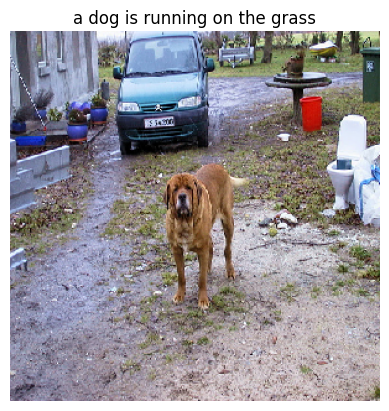

In [ ]:
def generate_caption(image_path):
    image = load_img(image_path, target_size=(299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    # Extract features using InceptionV3
    base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
    features = base_model.predict(image)
    features = features.reshape(1, -1)

    # Generate caption
    caption = predict_caption(model, features, tokenizer, max_length)
    return caption

# Example usage
new_image_path = '/content/extracted_content_image_caption/Images/2098418613_85a0c9afea.jpg'
caption = generate_caption(new_image_path)

# Display the image with the caption
image = load_img(new_image_path, target_size=(299, 299))
plt.imshow(image)
plt.title(caption)
plt.axis('off')
plt.show()